In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import xgboost
from xgboost import XGBClassifier
print("xgboost", xgboost.__version__)

from catboost import CatBoostClassifier

import lightgbm
from lightgbm import LGBMClassifier
print("lightgbm",lightgbm.__version__)

xgboost 1.5.1
lightgbm 3.3.1


# Описание задачи

Построить аппликационную модель оценки вероятности предъявления по гарантии, чтобы минимизировать потери от кредитного риска.

https://dsbattle.com/hackathons/mkb/
    
https://hackathon-mkb.ru 


Модель оценки вероятности предъявления по гарантии для 
клиентов МСБ.

Для  заключения  контрактов  в  рамках  системы  госзакупок  поставщикам 
товаров / услуг необходимо получить гарантию исполнения контракта со 
стороны  банков.  В  случае,  если  поставщик  не  выполнит  контракт, 
заказчик  предъявит  денежное  требование  выдавшему  гарантию  банку. 
Для того, чтобы минимизировать потери от кредитного риска, необходима 
модель, прогнозирующая вероятность предъявления по гарантии.  
Задача  заключается  в  построении  аппликационной  модели  оценки 
вероятности  предъявления  по  отдельной  гарантии.  В  качестве 
предикторов  для  моделирования  используются  данные  о  клиенте, 
включая различные собранные «анкетные» данные, а также финансовые 
показатели компаний. Поставщиками могут быть как юридические лица, 
так  и  индивидуальные  предприниматели.  Соответственно,  некоторые 
данные могут быть присущи только ИП или только ЮЛ. Для построения 
модели используется основная выборка (17 891 наблюдения), в которой 
указана  целевая  переменная  –  факт  предъявления  по  гарантии.  В 
качестве  результата  по  всем  наблюдениям  необходимо  получить 
балльную оценку и значение вероятности предъявления по гарантии. 
Для  выявления  победителя  будет  произведена  качественная  оценка 
построенной модели  на тестовой выборке (7 330 наблюдений), которую 
необходимо проскорить в соответствии с построенной моделью. Помимо 
качества  дифференцирующей  способности,  будет  учтена 
интерпретируемость модели. 

Решения оцениваются по метрике ROC/AUC Score (англ. Area Under Curve, площадь под кривой) — площадь, ограниченная ROC-кривой и осью доли ложных положительных классификаций.



### Описание признаков

* id_contract	Идентификатор контракта
* id_client	Идентификатор клиента
* SIGN_DATE	Дата подписания контракта
* IP_flag	Флаг ИП
* TARGET	Целевая переменная - факт наличия предъявления по гарантии
* F1100	Внеоборотные активы
* F1110	Нематериальные активы
* F1150	Основные средства
* F1160	Доходные вложения в материальные ценности
* F1170	Долгосрочные финансовые вложения
* F1180	Отложенные налоговые активы
* F1190	Прочие внеоборотные активы
* F1200	Оборотные активы
* F1210	Запасы
* F1220	НДС по приобретенным ценностям
* F1230	Дебиторская задолженность
* F1240	Краткосрочные финансовые вложения
* F1250	Денежные средства и денежные эквиваленты
* F1260	Прочие оборотные активы
* F1300	Капитал и резервы
* F1310	Уставный капитал
* F1320	Собственные акции, выкупленные у акционеров
* F1350	Добавочный капитал
* F1360	Резервный капитал
* F1370	Нераспределенная прибыль (непокрытый убыток)
* F1400	Долгосрочные обязательства
* F1410	Заёмные средства (долгосрочные)
* F1420	Отложенные налоговые обязательства
* F1450	Прочие долгосрочные обязательства
* F1500	Краткосрочные обязательства
* F1510	Заёмные средства (краткосрочные)
* F1520	Кредиторская задолженность
* F1530	Доходы будущих периодов
* F1550	Прочие краткосрочные обязательства
* F1600	Активы  всего
* F1700	Пассивы всего
* F2100	Валовая прибыль (убыток)
* F2110	Выручка
* F2120	Себестоимость продаж
* F2200	Прибыль (убыток) от продажи
* F2210	Коммерческие расходы
* F2220	Управленческие расходы
* F2300	Прибыль (убыток) до налогообложения
* F2310	Доходы от участия в других организациях
* F2320	Проценты к получению
* F2330	Проценты к уплате
* F2340	Прочие доходы
* F2350	Прочие расходы
* F2400	Чистая прибыль (убыток)
* F2410	Текущий налог на прибыль
* F1150_LAG1	Основные средства (предыдущий период)
* F1230_LAG1	Дебиторская задолженность (предыдущий период)
* F1410_LAG1	Заёмные средства (долгосрочные) (предыдущий период)
* F1510_LAG1	Заёмные средства (краткосрочные) (предыдущий период)
* F1520_LAG1	Кредиторская задолженность (предыдущий период)
* F2110_LAG1	Выручка (предыдущий период)
* F2120_LAG1	Себестоимость продаж (предыдущий период)
* F2200_LAG1	Прибыль (убыток) от продажи (предыдущий период)
* F2210_LAG1	Коммерческие расходы (предыдущий период)
* F2220_LAG1	Управленческие расходы (предыдущий период)
* F2300_LAG1	Прибыль (убыток) до налогообложения (предыдущий период)
* F2320_LAG1	Проценты к получению (предыдущий период)
* F2330_LAG1	Проценты к уплате (предыдущий период)
* F2400_LAG1	Чистая прибыль (убыток) (предыдущий период)
* EGRPOINCLUDED	Признак включения в ЕГРПО (Росстат)
* DATEFIRSTREG	Дата регистрации
* OKFS_GROUP	Группа ОКФС
* OKOPF_GROUP	Группа ОКОПФ
* OKOGU_GROUP	Группа ОКОГУ
* OKATO_REGIONCODE	ОКАТО. Код региона
* OKATO_FED	Код федерального округа по ОКАТО
* OKTMO_CODE	ОКТМО. Код
* OKTMO_FED	Код федерального округа по ОКОТМО
* WORKERSRANGE	Диапазон численности персонала
* TAXREG_REGDATE	Регистрация в ФНС. Дата регистрации
* TAXREGPAY_REGDATE	Регистрация в налоговом органе. Дата регистрации
* COUNTCOOWNERFCSM	Структура компании. Количество совладельцев (Данные компании/ФСФР)
* COUNTCOOWNERROSSTAT	Структура компании. Количество совладельцев (Ростат)
* COUNTCOOWNEREGRUL	Структура компании. Количество совладельцев (ЕГРЮЛ)
* COUNTBRANCH	Структура компании. Количество филиалов (Данные компании)
* COUNTBRANCHROSSTAT	Структура компании. Количество филиалов (Росстат)
* COUNTBRANCHEGRUL	Структура компании. Количество филиалов (ЕГРЮЛ)
* TELEPHONECOUNT	Количество компаний с аналогичными телефоном
* MANAGERCOUNTINCOUNTRY	Количество компаний с аналогичным ФИО руководителя (поиск по ФИО руководителя среди всех действующих компаний)
* MANAGERCOUNTINREGION	Количество компаний с аналогичным ФИО руководителя (поиск по ФИО руководителя среди действующих компаний, зарегистрированных в том же регионе)
* MANAGERINNCOUNT	Количество компаний с аналогичным ИНН руководителя (поиск по ИНН руководителя среди всех действующих компаний)
* OKVED_CODE	ОКВЭД
* PLAINTIFF_CASESNUMBER_YEAR	Участие в арбитражных делах в качестве истца. Количество дел (за последний год)
* PLAINTIFF_SUM_YEAR	Участие в арбитражных делах в качестве истца. Сумма, руб. (за последний год)
* DEFENDANT_CASESNUMBER_YEAR	Участие в арбитражных делах в качестве ответчика. Количество дел (за последний год)
* DEFENDANT_SUM_YEAR	Участие в арбитражных делах в качестве ответчика. Сумма, руб. (за последний год)
* THIRDOROTHERPERSON_YEAR	Участие в арбитражных делах в качестве третьего лица. (за последний год)
* PLAINTIFF_CASESNUMBER_EVER	Участие в арбитражных делах в качестве истца. Количество дел (за все время)
* PLAINTIFF_SUM_EVER	Участие в арбитражных делах в качестве истца. Сумма, руб. (за все время)
* DEFENDANT_CASESNUMBER_EVER	Участие в арбитражных делах в качестве ответчика. Количество дел (за все время)
* DEFENDANT_SUM_EVER	Участие в арбитражных делах в качестве ответчика. Сумма, руб. (за все время)
* THIRDOROTHERPERSON_EVER	Участие в арбитражных делах в качестве третьего лица. (за все время)
* ADMITTEDNUMBER_233_YEAR	Данные о тендерах за последний год. Число допусков к тендеру (ФЗ 223)
* NOTADMITTEDNUMBER_233_YEAR	Данные о тендерах за последний год. Число не допусков к тендеру (ФЗ 223)
* WINNERNUMBER_233_YEAR	Данные о тендерах за последний год. Число выигрышей тендеров (ФЗ 223)
* SIGNEDNUMBER_233_YEAR	Данные о госконтрактах за последний год. Число подписанных контрактов (ФЗ 223)
* SUM_233_YEAR	Данные о госконтрактах за последний год. Контрактов подписано на сумму, руб. (ФЗ 223)
* ADMITTEDNUMBER_233_EVER	Данные о тендерах за все время. Число допусков к тендеру (ФЗ 223)
* NOTADMITTEDNUMBER_233_EVER	Данные о тендерах за все время. Число не допусков к тендеру (ФЗ 223)
* WINNERNUMBER_233_EVER	Данные о тендерах за все время. Число выигрышей тендеров (ФЗ 223)
* SIGNEDNUMBER_233_EVER	Данные о госконтрактах за все время. Число подписанных контрактов (ФЗ 223)
* SUM_233_EVER	Данные о госконтрактах за все время. Контрактов подписано на сумму, руб. (ФЗ 223)
* ADMITTEDNUMBER_95_YEAR	Данные о тендерах за последний год. Число допусков к тендеру (ФЗ 94)
* NOTADMITTEDNUMBER_95_YEAR	Данные о тендерах за последний год. Число не допусков к тендеру (ФЗ 94)
* WINNERNUMBER_95_YEAR	Данные о тендерах за последний год. Число выигрышей тендеров (ФЗ 94)
* SIGNEDNUMBER_95_YEAR	Данные о госконтрактах за последний год. Число подписанных контрактов (ФЗ 94)
* SUM_95_YEAR	Данные о госконтрактах за последний год. Контрактов подписано на сумму, руб. (ФЗ 94)
* ADMITTEDNUMBER_95_EVER	Данные о тендерах за все время. Число допусков к тендеру (ФЗ 94)
* NOTADMITTEDNUMBER_EVER	Данные о тендерах за все время. Число не допусков к тендеру (ФЗ 94)
* WINNERNUMBER_95_EVER	Данные о тендерах за все время. Число выигрышей тендеров (ФЗ 94)
* SIGNEDNUMBER_95_EVER	Данные о госконтрактах за все время. Число подписанных контрактов (ФЗ 94)
* SUM_95_EVER	Данные о госконтрактах за все время. Контрактов подписано на сумму, руб. (ФЗ 94)
* FLAG_DISQUALIFICATION	Наличие руководителя компании, дисквалифицированного когда-либо
* COUNT_CHANGE_YEAR	Количество изменений в наименовании и организационно-правовой форме за последний год
* COUNT_CHANGE_EVER	Количество изменений в наименовании и организационно-правовой форме за все время
* BIRTHDATE	Дата рождения
* AGE	Возраст
* SEX_NAME	Пол
* CITIZENSHIP_NAME	Гражданство

## 1 EDA

In [2]:
# считываем данные

train_data = pd.read_csv("../data/external/train_dataset_hackathon_mkb.csv", sep=';', encoding='cp1251')
test_data = pd.read_csv("../data/external/test_dataset_hackathon_mkb.csv", sep=';', encoding='cp1251')

print(train_data.shape)
print(test_data.shape)

(17891, 124)
(7330, 123)


In [3]:
train_data.head()

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,...,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,...,169.0,168.0,18351739.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,4,12237,01JAN2018:00:00:00,0,0,1.937488e+09,122828000.0,6.103280e+08,NaN,809426000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,9988,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
test_data.head()

,id_contract,id_client,SIGN_DATE,IP_flag,F1100,F1110,F1150,F1160,F1170,F1180,...,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,17892,3620,08APR2019:00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17893,4101,08APR2019:00:00:00,0,1906000.0,NaN,1906000.0,NaN,NaN,NaN,...,7439.0,7100.0,1.187411e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17894,9589,08APR2019:00:00:00,0,147000.0,NaN,147000.0,NaN,NaN,NaN,...,362.0,344.0,9.836260e+07,NaN,1.0,3.0,NaN,NaN,NaN,NaN
3,17895,11546,08APR2019:00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17896,12558,08APR2019:00:00:00,0,26000.0,NaN,NaN,NaN,26000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17891 entries, 0 to 17890
Columns: 124 entries, id_contract to CITIZENSHIP_NAME
dtypes: float64(108), int64(4), object(12)
memory usage: 16.9+ MB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7330 entries, 0 to 7329
Columns: 123 entries, id_contract to CITIZENSHIP_NAME
dtypes: float64(108), int64(3), object(12)
memory usage: 6.9+ MB


Видим что имется много незаполненых данных, в случае ИП и ЮЛ используются разные данные

In [7]:
train_data[train_data['IP_flag'] == 1]

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,...,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,9988,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,10714,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,16,5567,01JAN2018:00:00:00,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,27MAY1985:00:00:00,33.0,мужской,Российская Федерация
17,18,10092,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17873,17874,10092,05APR2019:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17877,17878,10762,05APR2019:00:00:00,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11AUG1983:00:00:00,36.0,мужской,Российская Федерация
17879,17880,10762,05APR2019:00:00:00,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11AUG1983:00:00:00,36.0,мужской,Российская Федерация
17883,17884,9630,05APR2019:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11SEP1983:00:00:00,36.0,мужской,Российская Федерация


In [8]:
train_data[train_data['IP_flag'] == 0]

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,...,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,...,169.0,168.0,18351739.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,4,12237,01JAN2018:00:00:00,0,0,1.937488e+09,122828000.0,6.103280e+08,NaN,809426000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,10099,01JAN2018:00:00:00,0,0,2.946220e+08,186000.0,2.311130e+08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2740,01JAN2018:00:00:00,0,0,2.636311e+10,14172000.0,2.227751e+10,301366000.0,145000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17886,17887,3439,07APR2019:00:00:00,0,0,5.404500e+07,NaN,5.404500e+07,NaN,NaN,...,382.0,381.0,45954226.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
17887,17888,838,08APR2019:00:00:00,0,0,NaN,NaN,NaN,NaN,NaN,...,193.0,184.0,134417510.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN
17888,17889,10537,08APR2019:00:00:00,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17889,17890,1751,08APR2019:00:00:00,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# посмотрим количества записей по каждому клиенту

print(train_data['id_client'].value_counts())

10092    293
5159     291
4613     278
5357     220
2483     182
        ... 
5937       1
10640      1
11817      1
3525       1
1751       1
Name: id_client, Length: 8922, dtype: int64


0    10502
1     7389
Name: TARGET, dtype: int64


<AxesSubplot:>

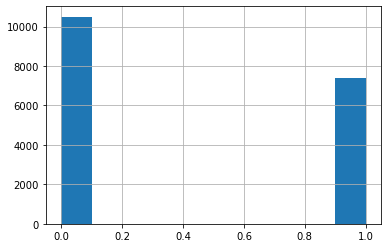

In [10]:
# посмотрим насколько сбалансированы классы

print(train_data['TARGET'].value_counts())
train_data['TARGET'].hist()

0    14391
1     3500
Name: IP_flag, dtype: int64


<AxesSubplot:>

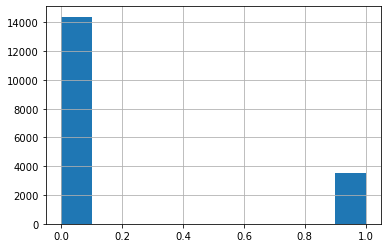

In [11]:
# посмотрим сколько клиентов являются ИП и сколько юрлицами

print(train_data['IP_flag'].value_counts())
train_data['IP_flag'].hist()

## 2 Feature selection

In [12]:
# сортируем признаки по времени и удаляем дублирующие признаки

def preprocessing(data):
    data['SIGN_DATE'] = pd.to_datetime(data['SIGN_DATE'], format='%d%b%Y:%H:%M:%S')
    data['SIGN_DATE'] = pd.to_datetime(data['SIGN_DATE'], format='%d%b%Y:%H:%M:%S')
    
    data = data.sort_values(by=['SIGN_DATE','id_client'])
    
    dropped_features = ['DATEFIRSTREG', 'OKTMO_FED', 'TAXREG_REGDATE', 'TAXREGPAY_REGDATE', 'COUNTCOOWNERROSSTAT', 
                    'COUNTCOOWNEREGRUL', 'COUNTBRANCHROSSTAT', 'COUNTBRANCHEGRUL', 'BIRTHDATE']
    data = data.drop(dropped_features, axis=1)
    
    return data

In [13]:
train_data = preprocessing(train_data)
test_data = preprocessing(test_data)

In [14]:
train_data

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,...,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,AGE,SEX_NAME,CITIZENSHIP_NAME
22,23,168,2018-01-01,0,0,1.480156e+10,6000.0,6.428252e+09,175389000.0,7.944801e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,25,410,2018-01-01,0,0,6.241600e+07,NaN,5.555000e+07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,26,562,2018-01-01,0,0,4.383630e+08,NaN,4.251110e+08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,35,822,2018-01-01,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,27,834,2018-01-01,0,0,2.956327e+10,1358000.0,2.757412e+10,NaN,1.696519e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17886,17887,3439,2019-04-07,0,0,5.404500e+07,NaN,5.404500e+07,NaN,NaN,...,3.0,382.0,381.0,45954226.0,NaN,NaN,1.0,NaN,NaN,NaN
17887,17888,838,2019-04-08,0,0,NaN,NaN,NaN,NaN,NaN,...,6.0,193.0,184.0,134417510.0,NaN,NaN,5.0,NaN,NaN,NaN
17889,17890,1751,2019-04-08,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17890,17891,3095,2019-04-08,0,0,NaN,NaN,NaN,NaN,NaN,...,35.0,274.0,271.0,55854817.0,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
test_data

,id_contract,id_client,SIGN_DATE,IP_flag,F1100,F1110,F1150,F1160,F1170,F1180,...,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,AGE,SEX_NAME,CITIZENSHIP_NAME
17,17909,217,2019-04-08,0,1488000.0,NaN,1488000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,17911,471,2019-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,...,13.0,101.0,89.0,23945371.0,NaN,NaN,NaN,NaN,NaN,NaN
20,17912,550,2019-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,267.0,257.0,64529976.0,NaN,NaN,NaN,NaN,NaN,NaN
51,17943,1149,2019-04-08,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,мужской,Российская Федерация
52,17944,1400,2019-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,848.0,843.0,317158733.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7323,25215,11021,2019-12-30,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7321,25213,11496,2019-12-30,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,44.0,28.0,18631030.0,NaN,NaN,NaN,NaN,NaN,NaN
7328,25220,537,2019-12-31,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,2.0,4000000.0,NaN,NaN,NaN,NaN,NaN,NaN
7327,25219,4932,2019-12-31,0,24000.0,NaN,24000.0,NaN,NaN,NaN,...,1.0,17.0,17.0,3012122.0,NaN,NaN,1.0,NaN,NaN,NaN


In [16]:
# посчитаем количество пропусков по столбцам и посмотрим на типы данных

def get_dataset_skips(dataset):
    skips = {}
    for col in dataset.columns:
        skips[col] = [dataset[col][dataset[col].isna()].shape[0], dataset[col].dtypes]
    return skips

train_skips = get_dataset_skips(train_data)
test_skips = get_dataset_skips(test_data)


In [17]:
train_skips

{'id_contract': [0, dtype('int64')],
 'id_client': [0, dtype('int64')],
 'SIGN_DATE': [0, dtype('<M8[ns]')],
 'IP_flag': [0, dtype('int64')],
 'TARGET': [0, dtype('int64')],
 'F1100': [10955, dtype('float64')],
 'F1110': [16471, dtype('float64')],
 'F1150': [11550, dtype('float64')],
 'F1160': [17545, dtype('float64')],
 'F1170': [16392, dtype('float64')],
 'F1180': [15391, dtype('float64')],
 'F1190': [16371, dtype('float64')],
 'F1200': [6041, dtype('float64')],
 'F1210': [8156, dtype('float64')],
 'F1220': [14593, dtype('float64')],
 'F1230': [6407, dtype('float64')],
 'F1240': [15035, dtype('float64')],
 'F1250': [6281, dtype('float64')],
 'F1260': [13529, dtype('float64')],
 'F1300': [6041, dtype('float64')],
 'F1310': [10187, dtype('float64')],
 'F1320': [17794, dtype('float64')],
 'F1350': [16933, dtype('float64')],
 'F1360': [16522, dtype('float64')],
 'F1370': [10396, dtype('float64')],
 'F1400': [13675, dtype('float64')],
 'F1410': [15475, dtype('float64')],
 'F1420': [15603,

In [18]:
test_skips

{'id_contract': [0, dtype('int64')],
 'id_client': [0, dtype('int64')],
 'SIGN_DATE': [0, dtype('<M8[ns]')],
 'IP_flag': [0, dtype('int64')],
 'F1100': [4840, dtype('float64')],
 'F1110': [6872, dtype('float64')],
 'F1150': [5009, dtype('float64')],
 'F1160': [7251, dtype('float64')],
 'F1170': [6844, dtype('float64')],
 'F1180': [6651, dtype('float64')],
 'F1190': [6872, dtype('float64')],
 'F1200': [2739, dtype('float64')],
 'F1210': [3533, dtype('float64')],
 'F1220': [6201, dtype('float64')],
 'F1230': [2949, dtype('float64')],
 'F1240': [6433, dtype('float64')],
 'F1250': [2913, dtype('float64')],
 'F1260': [5947, dtype('float64')],
 'F1300': [2735, dtype('float64')],
 'F1310': [4525, dtype('float64')],
 'F1320': [7322, dtype('float64')],
 'F1350': [7071, dtype('float64')],
 'F1360': [6945, dtype('float64')],
 'F1370': [4588, dtype('float64')],
 'F1400': [5828, dtype('float64')],
 'F1410': [6391, dtype('float64')],
 'F1420': [6697, dtype('float64')],
 'F1450': [7092, dtype('float6

In [19]:
# создадим списки с названиями по типам столбцов

cat_features = []
num_features = []
for aaa, bbb in get_dataset_skips(train_data).items():
    if 'float64' in bbb:
        num_features.append(aaa)
    elif 'O' in bbb:
        cat_features.append(aaa)
        
assert (len(num_features) + len(cat_features) + 5 == len(train_data.columns))

In [20]:
print(cat_features)
print(num_features)

['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'WORKERSRANGE', 'OKVED_CODE', 'SEX_NAME', 'CITIZENSHIP_NAME']
['F1100', 'F1110', 'F1150', 'F1160', 'F1170', 'F1180', 'F1190', 'F1200', 'F1210', 'F1220', 'F1230', 'F1240', 'F1250', 'F1260', 'F1300', 'F1310', 'F1320', 'F1350', 'F1360', 'F1370', 'F1400', 'F1410', 'F1420', 'F1450', 'F1500', 'F1510', 'F1520', 'F1530', 'F1550', 'F1600', 'F1700', 'F2100', 'F2110', 'F2120', 'F2200', 'F2210', 'F2220', 'F2300', 'F2310', 'F2320', 'F2330', 'F2340', 'F2350', 'F2400', 'F2410', 'F1150_LAG1', 'F1230_LAG1', 'F1410_LAG1', 'F1510_LAG1', 'F1520_LAG1', 'F2110_LAG1', 'F2120_LAG1', 'F2200_LAG1', 'F2210_LAG1', 'F2220_LAG1', 'F2300_LAG1', 'F2320_LAG1', 'F2330_LAG1', 'F2400_LAG1', 'EGRPOINCLUDED', 'OKATO_REGIONCODE', 'OKATO_FED', 'OKTMO_CODE', 'COUNTCOOWNERFCSM', 'COUNTBRANCH', 'TELEPHONECOUNT', 'MANAGERCOUNTINCOUNTRY', 'MANAGERCOUNTINREGION', 'MANAGERINNCOUNT', 'PLAINTIFF_CASESNUMBER_YEAR', 'PLAINTIFF_SUM_YEAR', 'DEFENDANT_CASESNUMBER_YEAR', 'DEFENDANT_SUM_YEAR', 'T

In [21]:
# Заменим пропуски строкой "None" в категориальных признаках и на 0 в числовых

def skips_processing(data):
    data.update(data.loc[:, cat_features].fillna('None'))
    data.update(data.loc[:, cat_features].astype('str'))   
    data.update(data.loc[:, num_features].fillna(0))
    
    return data

In [22]:
train_data = skips_processing(train_data)
test_data = skips_processing(test_data)

In [23]:
# Кодируем категориальные переменные для работы моделей на основе решающих деревьев методом label encoder

le=LabelEncoder()
train_data_le = train_data.copy()
test_data_le = test_data.copy()

for column in train_data_le[cat_features].columns:
    train_data_le[column] = le.fit_transform(train_data_le[column])
    test_data_le[column] = le.fit_transform(test_data_le[column])

In [24]:
# Делим выборку на обучающую и тестовую

train_size = round(train_data.shape[0] * 0.8)

train = train_data_le.iloc[:train_size, :]
test = train_data_le.iloc[train_size: , :]

print(train.shape)
print(test.shape)

(14313, 115)
(3578, 115)


In [25]:
# Формируем входные переменные и целевую, тестовый датасет

X_train = train.drop(['TARGET', 'id_contract', 'id_client', 'SIGN_DATE'], axis=1)
y_train = train['TARGET']

X_test = test.drop(['TARGET', 'id_contract', 'id_client', 'SIGN_DATE'], axis=1)
y_test = test['TARGET']

## 3 Обучение моделей

In [26]:
# функция для вывода отчета

def report(model, y_train, y_test, X_train, X_test):
    print('Тренировочные данные:\n', classification_report(y_train, model.predict(X_train)))
    print('roc_auc_score', roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
    print('Тестовые данные:\n', classification_report(y_test, model.predict(X_test)))
    print('roc_auc_score', roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    return None

In [27]:
# функция для вывода важности признаков

def feature_importances(model, X_train):
    headers = list(X_train.columns.values)
    feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)[:25]
    f, ax = plt.subplots(figsize=(6, 6))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Важность атрибутов')
    plt.ylabel('Атрибуты')
    plt.title("Наиболее важные атрибуты")
    plt.legend()
    plt.show()
    return None

### 3.1 sklearn Random Forest

Сделаем подбор параметров

In [28]:
%%time

parameters = {
    'n_estimators':range(10, 100, 10),
    'max_depth':range(5, 50, 5)
}

gsearch1 = GridSearchCV(
            estimator=RandomForestClassifier(),
            param_grid = parameters,
            scoring='accuracy',
            n_jobs=-1,
#             iid=False,
            cv=3,
            verbose=3
)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Wall time: 1min 25s


{'max_depth': 20, 'n_estimators': 50}

In [29]:
model_rf = RandomForestClassifier(n_estimators=gsearch1.best_params_['n_estimators'], 
                                max_depth=gsearch1.best_params_['max_depth'])
model_rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, n_estimators=50)

In [30]:
report(model_rf, y_train, y_test, X_train, X_test)

Тренировочные данные:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      8237
           1       0.97      0.98      0.97      6076

    accuracy                           0.98     14313
   macro avg       0.98      0.98      0.98     14313
weighted avg       0.98      0.98      0.98     14313

roc_auc_score 0.9959739259973004
Тестовые данные:
               precision    recall  f1-score   support

           0       0.73      0.97      0.83      2265
           1       0.88      0.38      0.53      1313

    accuracy                           0.75      3578
   macro avg       0.81      0.68      0.68      3578
weighted avg       0.79      0.75      0.72      3578

roc_auc_score 0.880134972233851


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


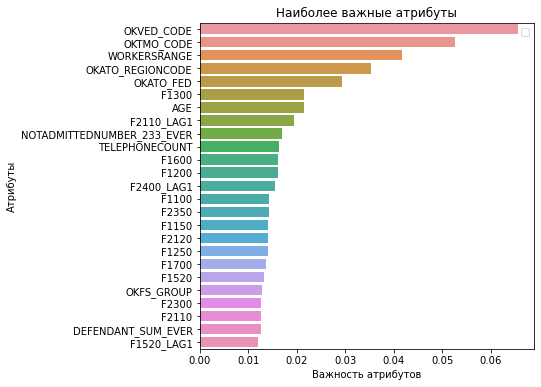

In [31]:
feature_importances(model_rf, X_train)

### 3.2 xgboost

Сделаем подбор параметров

In [32]:
%%time

parameters = {
    'max_depth':range(5, 20, 5),
    'learning_rate':np.arange(0.05, 0.4, 0.05)
}

gsearch2 = GridSearchCV(
            estimator=XGBClassifier(),
            param_grid = parameters,
            scoring='accuracy',
            n_jobs=-1,
#             iid=False,
            cv=3,
            verbose=3
)
gsearch2.fit(X_train, y_train)
gsearch2.best_params_

Fitting 3 folds for each of 21 candidates, totalling 63 fits


C:\Users\FED\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:44:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 3min 43s


{'learning_rate': 0.35000000000000003, 'max_depth': 15}

In [33]:
model_xgb = XGBClassifier(max_depth=gsearch2.best_params_['max_depth'], 
                          learning_rate=gsearch2.best_params_['learning_rate'])
model_xgb.fit(X_train, y_train)

[00:44:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.35000000000000003,
              max_delta_step=0, max_depth=15, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
report(model_xgb, y_train, y_test, X_train, X_test)

Тренировочные данные:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8237
           1       0.99      0.99      0.99      6076

    accuracy                           0.99     14313
   macro avg       0.99      0.99      0.99     14313
weighted avg       0.99      0.99      0.99     14313

roc_auc_score 0.9993545797583329
Тестовые данные:
               precision    recall  f1-score   support

           0       0.79      0.96      0.87      2265
           1       0.89      0.57      0.69      1313

    accuracy                           0.82      3578
   macro avg       0.84      0.76      0.78      3578
weighted avg       0.83      0.82      0.80      3578

roc_auc_score 0.9095970167572031


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


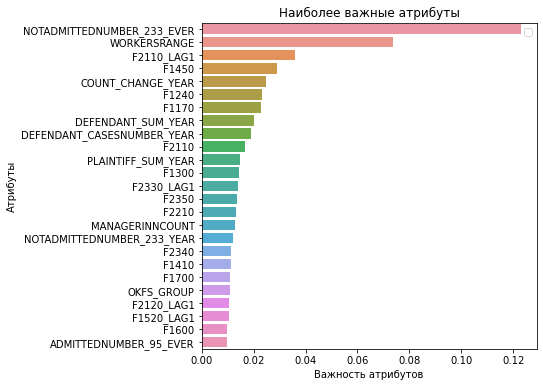

In [35]:
feature_importances(model_xgb, X_train)

### 3.3 lightgbm

Сделаем подбор параметров

In [36]:
%%time

parameters = {
    'n_estimators': range(50, 100, 10),
    'num_leaves': range(5, 50, 1),
#     'learning_rate': np.arange(0.05, 0.4, 0.05)
}

gsearch3 = GridSearchCV(
            estimator=LGBMClassifier(),
            param_grid = parameters,
            scoring='accuracy',
            n_jobs=-1,
#             iid=False,
            cv=3,
            verbose=1
)
gsearch3.fit(X_train, y_train)
gsearch3.best_params_

Fitting 3 folds for each of 225 candidates, totalling 675 fits
Wall time: 4min 41s


{'n_estimators': 80, 'num_leaves': 44}

In [37]:
model_lgbm = LGBMClassifier(n_estimators=gsearch3.best_params_['n_estimators'],
                           num_leaves=gsearch3.best_params_['num_leaves'],
                           )
model_lgbm.fit(X_train, y_train)

LGBMClassifier(n_estimators=80, num_leaves=44)

In [38]:
report(model_lgbm, y_train, y_test, X_train, X_test)

Тренировочные данные:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      8237
           1       0.95      0.92      0.93      6076

    accuracy                           0.94     14313
   macro avg       0.95      0.94      0.94     14313
weighted avg       0.94      0.94      0.94     14313

roc_auc_score 0.9870576477643108
Тестовые данные:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87      2265
           1       0.88      0.58      0.70      1313

    accuracy                           0.82      3578
   macro avg       0.84      0.77      0.78      3578
weighted avg       0.83      0.82      0.81      3578

roc_auc_score 0.9224027344150616


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


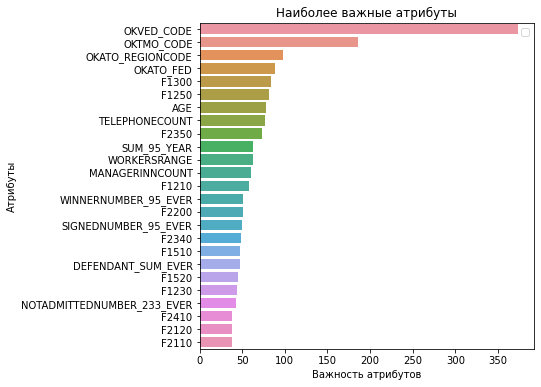

In [39]:
feature_importances(model_lgbm, X_train)

### 3.4 catboost

Подготовим данные (так как catboost непосредственно может работать с категориальными признаками, то label encoder не требуется)

In [40]:
train_cb = train_data.iloc[:train_size, :]
test_cb = train_data.iloc[train_size: , :]

print(train_cb.shape)
print(test_cb.shape)

X_train_cb = train_cb.drop(['TARGET', 'id_contract', 'id_client', 'SIGN_DATE'], axis=1)
y_train_cb = train_cb['TARGET']

X_test_cb = test_cb.drop(['TARGET', 'id_contract', 'id_client', 'SIGN_DATE'], axis=1)
y_test_cb = test_cb['TARGET']

(14313, 115)
(3578, 115)


Сделаем подбор параметров

In [41]:
%%time

param_grid = {
#     'learning_rate': [0.05, 0.1],
        'depth': [5, 10, 15],
        'l2_leaf_reg': [4, 9, 14]}

model_cb = CatBoostClassifier(cat_features = cat_features, loss_function='Logloss')


grid_search_result = model_cb.grid_search(param_grid,
                                       X=X_train_cb,
                                       y=y_train_cb,
                                       plot=True)

grid_search_result['params']


# randomized_search_result = model_cb.randomized_search(param_grid,
#                                                    X=X_train_cb,
#                                                    y=y_train_cb,
#                                                    plot=True)

# randomized_search_result['params']

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6778448	test: 0.6777084	best: 0.6777084 (0)	total: 224ms	remaining: 3m 43s
1:	learn: 0.6647414	test: 0.6648017	best: 0.6648017 (1)	total: 266ms	remaining: 2m 12s
2:	learn: 0.6516425	test: 0.6509083	best: 0.6509083 (2)	total: 310ms	remaining: 1m 43s
3:	learn: 0.6381992	test: 0.6370195	best: 0.6370195 (3)	total: 349ms	remaining: 1m 26s
4:	learn: 0.6258496	test: 0.6251414	best: 0.6251414 (4)	total: 393ms	remaining: 1m 18s
5:	learn: 0.6142488	test: 0.6137337	best: 0.6137337 (5)	total: 435ms	remaining: 1m 12s
6:	learn: 0.6036181	test: 0.6033088	best: 0.6033088 (6)	total: 480ms	remaining: 1m 8s
7:	learn: 0.5938437	test: 0.5936433	best: 0.5936433 (7)	total: 520ms	remaining: 1m 4s
8:	learn: 0.5852363	test: 0.5851635	best: 0.5851635 (8)	total: 565ms	remaining: 1m 2s
9:	learn: 0.5768346	test: 0.5768562	best: 0.5768562 (9)	total: 606ms	remaining: 1m
10:	learn: 0.5690289	test: 0.5688760	best: 0.5688760 (10)	total: 646ms	remaining: 58.1s
11:	learn: 0.5613383	test: 0.5611204	best: 0.5611

96:	learn: 0.3633799	test: 0.3659844	best: 0.3659844 (96)	total: 4.65s	remaining: 43.3s
97:	learn: 0.3626862	test: 0.3653873	best: 0.3653873 (97)	total: 4.69s	remaining: 43.2s
98:	learn: 0.3619270	test: 0.3646616	best: 0.3646616 (98)	total: 4.74s	remaining: 43.1s
99:	learn: 0.3613836	test: 0.3641853	best: 0.3641853 (99)	total: 4.78s	remaining: 43s
100:	learn: 0.3603131	test: 0.3633532	best: 0.3633532 (100)	total: 4.83s	remaining: 43s
101:	learn: 0.3598418	test: 0.3629592	best: 0.3629592 (101)	total: 4.87s	remaining: 42.9s
102:	learn: 0.3594599	test: 0.3625382	best: 0.3625382 (102)	total: 4.92s	remaining: 42.8s
103:	learn: 0.3591471	test: 0.3623238	best: 0.3623238 (103)	total: 4.96s	remaining: 42.7s
104:	learn: 0.3587168	test: 0.3619883	best: 0.3619883 (104)	total: 5.01s	remaining: 42.7s
105:	learn: 0.3581614	test: 0.3614624	best: 0.3614624 (105)	total: 5.05s	remaining: 42.6s
106:	learn: 0.3575904	test: 0.3609754	best: 0.3609754 (106)	total: 5.09s	remaining: 42.5s
107:	learn: 0.3570002	

192:	learn: 0.3259303	test: 0.3368549	best: 0.3368549 (192)	total: 9.03s	remaining: 37.8s
193:	learn: 0.3257619	test: 0.3367289	best: 0.3367289 (193)	total: 9.07s	remaining: 37.7s
194:	learn: 0.3255109	test: 0.3365776	best: 0.3365776 (194)	total: 9.12s	remaining: 37.6s
195:	learn: 0.3249887	test: 0.3361046	best: 0.3361046 (195)	total: 9.16s	remaining: 37.6s
196:	learn: 0.3244657	test: 0.3355219	best: 0.3355219 (196)	total: 9.21s	remaining: 37.5s
197:	learn: 0.3242264	test: 0.3353569	best: 0.3353569 (197)	total: 9.26s	remaining: 37.5s
198:	learn: 0.3238820	test: 0.3350399	best: 0.3350399 (198)	total: 9.3s	remaining: 37.4s
199:	learn: 0.3236630	test: 0.3347726	best: 0.3347726 (199)	total: 9.34s	remaining: 37.4s
200:	learn: 0.3233537	test: 0.3345141	best: 0.3345141 (200)	total: 9.39s	remaining: 37.3s
201:	learn: 0.3228628	test: 0.3339455	best: 0.3339455 (201)	total: 9.43s	remaining: 37.3s
202:	learn: 0.3224678	test: 0.3335641	best: 0.3335641 (202)	total: 9.47s	remaining: 37.2s
203:	learn:

287:	learn: 0.3004585	test: 0.3167989	best: 0.3167989 (287)	total: 13.3s	remaining: 33s
288:	learn: 0.3003072	test: 0.3167121	best: 0.3167121 (288)	total: 13.4s	remaining: 33s
289:	learn: 0.3001737	test: 0.3166340	best: 0.3166340 (289)	total: 13.4s	remaining: 32.9s
290:	learn: 0.2999107	test: 0.3164052	best: 0.3164052 (290)	total: 13.5s	remaining: 32.9s
291:	learn: 0.2996304	test: 0.3161319	best: 0.3161319 (291)	total: 13.5s	remaining: 32.8s
292:	learn: 0.2993950	test: 0.3160072	best: 0.3160072 (292)	total: 13.6s	remaining: 32.8s
293:	learn: 0.2989977	test: 0.3156728	best: 0.3156728 (293)	total: 13.6s	remaining: 32.7s
294:	learn: 0.2988201	test: 0.3155817	best: 0.3155817 (294)	total: 13.7s	remaining: 32.7s
295:	learn: 0.2986792	test: 0.3154704	best: 0.3154704 (295)	total: 13.7s	remaining: 32.6s
296:	learn: 0.2986154	test: 0.3154319	best: 0.3154319 (296)	total: 13.8s	remaining: 32.6s
297:	learn: 0.2985014	test: 0.3153594	best: 0.3153594 (297)	total: 13.8s	remaining: 32.5s
298:	learn: 0.

383:	learn: 0.2813408	test: 0.3028880	best: 0.3028880 (383)	total: 17.7s	remaining: 28.4s
384:	learn: 0.2813309	test: 0.3028778	best: 0.3028778 (384)	total: 17.7s	remaining: 28.3s
385:	learn: 0.2810811	test: 0.3027546	best: 0.3027546 (385)	total: 17.8s	remaining: 28.3s
386:	learn: 0.2810671	test: 0.3027463	best: 0.3027463 (386)	total: 17.8s	remaining: 28.2s
387:	learn: 0.2808126	test: 0.3025227	best: 0.3025227 (387)	total: 17.9s	remaining: 28.2s
388:	learn: 0.2806026	test: 0.3024048	best: 0.3024048 (388)	total: 17.9s	remaining: 28.2s
389:	learn: 0.2804744	test: 0.3023697	best: 0.3023697 (389)	total: 18s	remaining: 28.1s
390:	learn: 0.2803136	test: 0.3023724	best: 0.3023697 (389)	total: 18s	remaining: 28s
391:	learn: 0.2803070	test: 0.3023673	best: 0.3023673 (391)	total: 18.1s	remaining: 28s
392:	learn: 0.2801805	test: 0.3021897	best: 0.3021897 (392)	total: 18.1s	remaining: 28s
393:	learn: 0.2799474	test: 0.3021059	best: 0.3021059 (393)	total: 18.1s	remaining: 27.9s
394:	learn: 0.279830

478:	learn: 0.2680000	test: 0.2947427	best: 0.2947427 (478)	total: 22s	remaining: 23.9s
479:	learn: 0.2679943	test: 0.2947387	best: 0.2947387 (479)	total: 22s	remaining: 23.9s
480:	learn: 0.2678934	test: 0.2946545	best: 0.2946545 (480)	total: 22.1s	remaining: 23.8s
481:	learn: 0.2677610	test: 0.2946651	best: 0.2946545 (480)	total: 22.1s	remaining: 23.8s
482:	learn: 0.2677534	test: 0.2946647	best: 0.2946545 (480)	total: 22.2s	remaining: 23.7s
483:	learn: 0.2675387	test: 0.2945501	best: 0.2945501 (483)	total: 22.2s	remaining: 23.7s
484:	learn: 0.2673118	test: 0.2944134	best: 0.2944134 (484)	total: 22.3s	remaining: 23.6s
485:	learn: 0.2673072	test: 0.2944105	best: 0.2944105 (485)	total: 22.3s	remaining: 23.6s
486:	learn: 0.2672887	test: 0.2944210	best: 0.2944105 (485)	total: 22.3s	remaining: 23.5s
487:	learn: 0.2671572	test: 0.2943773	best: 0.2943773 (487)	total: 22.4s	remaining: 23.5s
488:	learn: 0.2669812	test: 0.2943464	best: 0.2943464 (488)	total: 22.4s	remaining: 23.4s
489:	learn: 0.

574:	learn: 0.2563188	test: 0.2892494	best: 0.2892494 (574)	total: 26.4s	remaining: 19.5s
575:	learn: 0.2562508	test: 0.2892338	best: 0.2892338 (575)	total: 26.4s	remaining: 19.4s
576:	learn: 0.2561642	test: 0.2891769	best: 0.2891769 (576)	total: 26.5s	remaining: 19.4s
577:	learn: 0.2561042	test: 0.2891623	best: 0.2891623 (577)	total: 26.5s	remaining: 19.3s
578:	learn: 0.2560915	test: 0.2891706	best: 0.2891623 (577)	total: 26.5s	remaining: 19.3s
579:	learn: 0.2559141	test: 0.2890547	best: 0.2890547 (579)	total: 26.6s	remaining: 19.3s
580:	learn: 0.2557189	test: 0.2889868	best: 0.2889868 (580)	total: 26.6s	remaining: 19.2s
581:	learn: 0.2555989	test: 0.2889552	best: 0.2889552 (581)	total: 26.7s	remaining: 19.2s
582:	learn: 0.2554123	test: 0.2889190	best: 0.2889190 (582)	total: 26.7s	remaining: 19.1s
583:	learn: 0.2554042	test: 0.2889179	best: 0.2889179 (583)	total: 26.8s	remaining: 19.1s
584:	learn: 0.2553660	test: 0.2889214	best: 0.2889179 (583)	total: 26.8s	remaining: 19s
585:	learn: 

670:	learn: 0.2463749	test: 0.2846807	best: 0.2846732 (669)	total: 30.7s	remaining: 15s
671:	learn: 0.2463287	test: 0.2846553	best: 0.2846553 (671)	total: 30.7s	remaining: 15s
672:	learn: 0.2462484	test: 0.2846028	best: 0.2846028 (672)	total: 30.8s	remaining: 15s
673:	learn: 0.2460309	test: 0.2844728	best: 0.2844728 (673)	total: 30.8s	remaining: 14.9s
674:	learn: 0.2458867	test: 0.2843605	best: 0.2843605 (674)	total: 30.9s	remaining: 14.9s
675:	learn: 0.2458487	test: 0.2843431	best: 0.2843431 (675)	total: 30.9s	remaining: 14.8s
676:	learn: 0.2457356	test: 0.2842471	best: 0.2842471 (676)	total: 31s	remaining: 14.8s
677:	learn: 0.2456669	test: 0.2842029	best: 0.2842029 (677)	total: 31s	remaining: 14.7s
678:	learn: 0.2455411	test: 0.2841661	best: 0.2841661 (678)	total: 31.1s	remaining: 14.7s
679:	learn: 0.2454267	test: 0.2841224	best: 0.2841224 (679)	total: 31.1s	remaining: 14.6s
680:	learn: 0.2453093	test: 0.2840826	best: 0.2840826 (680)	total: 31.1s	remaining: 14.6s
681:	learn: 0.245167

765:	learn: 0.2368104	test: 0.2807480	best: 0.2807480 (765)	total: 35s	remaining: 10.7s
766:	learn: 0.2366900	test: 0.2806508	best: 0.2806508 (766)	total: 35s	remaining: 10.6s
767:	learn: 0.2365054	test: 0.2806625	best: 0.2806508 (766)	total: 35.1s	remaining: 10.6s
768:	learn: 0.2364032	test: 0.2805404	best: 0.2805404 (768)	total: 35.1s	remaining: 10.6s
769:	learn: 0.2363059	test: 0.2805090	best: 0.2805090 (769)	total: 35.2s	remaining: 10.5s
770:	learn: 0.2360962	test: 0.2804201	best: 0.2804201 (770)	total: 35.2s	remaining: 10.5s
771:	learn: 0.2360928	test: 0.2804187	best: 0.2804187 (771)	total: 35.3s	remaining: 10.4s
772:	learn: 0.2360202	test: 0.2803771	best: 0.2803771 (772)	total: 35.3s	remaining: 10.4s
773:	learn: 0.2359863	test: 0.2803710	best: 0.2803710 (773)	total: 35.4s	remaining: 10.3s
774:	learn: 0.2358882	test: 0.2803455	best: 0.2803455 (774)	total: 35.4s	remaining: 10.3s
775:	learn: 0.2358790	test: 0.2803499	best: 0.2803455 (774)	total: 35.4s	remaining: 10.2s
776:	learn: 0.

860:	learn: 0.2282256	test: 0.2768853	best: 0.2768853 (860)	total: 39.3s	remaining: 6.34s
861:	learn: 0.2280614	test: 0.2768287	best: 0.2768287 (861)	total: 39.3s	remaining: 6.3s
862:	learn: 0.2279267	test: 0.2767392	best: 0.2767392 (862)	total: 39.4s	remaining: 6.25s
863:	learn: 0.2278472	test: 0.2767804	best: 0.2767392 (862)	total: 39.4s	remaining: 6.21s
864:	learn: 0.2278078	test: 0.2767782	best: 0.2767392 (862)	total: 39.5s	remaining: 6.16s
865:	learn: 0.2277124	test: 0.2767548	best: 0.2767392 (862)	total: 39.5s	remaining: 6.12s
866:	learn: 0.2277093	test: 0.2767551	best: 0.2767392 (862)	total: 39.6s	remaining: 6.08s
867:	learn: 0.2275785	test: 0.2767726	best: 0.2767392 (862)	total: 39.7s	remaining: 6.03s
868:	learn: 0.2275238	test: 0.2767174	best: 0.2767174 (868)	total: 39.7s	remaining: 5.99s
869:	learn: 0.2274266	test: 0.2767168	best: 0.2767168 (869)	total: 39.8s	remaining: 5.94s
870:	learn: 0.2274200	test: 0.2767228	best: 0.2767168 (869)	total: 39.8s	remaining: 5.9s
871:	learn: 

954:	learn: 0.2201078	test: 0.2746659	best: 0.2746659 (954)	total: 43.7s	remaining: 2.06s
955:	learn: 0.2200982	test: 0.2746703	best: 0.2746659 (954)	total: 43.7s	remaining: 2.01s
956:	learn: 0.2199891	test: 0.2746595	best: 0.2746595 (956)	total: 43.8s	remaining: 1.97s
957:	learn: 0.2199352	test: 0.2746368	best: 0.2746368 (957)	total: 43.8s	remaining: 1.92s
958:	learn: 0.2198216	test: 0.2746057	best: 0.2746057 (958)	total: 43.9s	remaining: 1.88s
959:	learn: 0.2196632	test: 0.2744531	best: 0.2744531 (959)	total: 43.9s	remaining: 1.83s
960:	learn: 0.2196097	test: 0.2744263	best: 0.2744263 (960)	total: 44s	remaining: 1.78s
961:	learn: 0.2195032	test: 0.2743701	best: 0.2743701 (961)	total: 44s	remaining: 1.74s
962:	learn: 0.2194234	test: 0.2743357	best: 0.2743357 (962)	total: 44.1s	remaining: 1.69s
963:	learn: 0.2193499	test: 0.2743182	best: 0.2743182 (963)	total: 44.1s	remaining: 1.65s
964:	learn: 0.2192534	test: 0.2742827	best: 0.2742827 (964)	total: 44.2s	remaining: 1.6s
965:	learn: 0.2

50:	learn: 0.4032222	test: 0.3989892	best: 0.3989892 (50)	total: 2.25s	remaining: 41.9s
51:	learn: 0.4020789	test: 0.3981123	best: 0.3981123 (51)	total: 2.29s	remaining: 41.8s
52:	learn: 0.4010722	test: 0.3972357	best: 0.3972357 (52)	total: 2.34s	remaining: 41.9s
53:	learn: 0.3996879	test: 0.3959613	best: 0.3959613 (53)	total: 2.38s	remaining: 41.8s
54:	learn: 0.3986549	test: 0.3949779	best: 0.3949779 (54)	total: 2.42s	remaining: 41.7s
55:	learn: 0.3971271	test: 0.3933701	best: 0.3933701 (55)	total: 2.47s	remaining: 41.6s
56:	learn: 0.3960116	test: 0.3924103	best: 0.3924103 (56)	total: 2.52s	remaining: 41.6s
57:	learn: 0.3945429	test: 0.3909532	best: 0.3909532 (57)	total: 2.56s	remaining: 41.6s
58:	learn: 0.3932774	test: 0.3898246	best: 0.3898246 (58)	total: 2.6s	remaining: 41.5s
59:	learn: 0.3922936	test: 0.3889205	best: 0.3889205 (59)	total: 2.66s	remaining: 41.7s
60:	learn: 0.3912305	test: 0.3879099	best: 0.3879099 (60)	total: 2.72s	remaining: 41.8s
61:	learn: 0.3904047	test: 0.3872

146:	learn: 0.3418155	test: 0.3480122	best: 0.3480122 (146)	total: 6.62s	remaining: 38.4s
147:	learn: 0.3414844	test: 0.3477641	best: 0.3477641 (147)	total: 6.67s	remaining: 38.4s
148:	learn: 0.3410200	test: 0.3473673	best: 0.3473673 (148)	total: 6.72s	remaining: 38.4s
149:	learn: 0.3406932	test: 0.3472422	best: 0.3472422 (149)	total: 6.76s	remaining: 38.3s
150:	learn: 0.3401159	test: 0.3467528	best: 0.3467528 (150)	total: 6.8s	remaining: 38.3s
151:	learn: 0.3397212	test: 0.3465975	best: 0.3465975 (151)	total: 6.85s	remaining: 38.2s
152:	learn: 0.3394792	test: 0.3463985	best: 0.3463985 (152)	total: 6.9s	remaining: 38.2s
153:	learn: 0.3392562	test: 0.3461978	best: 0.3461978 (153)	total: 6.94s	remaining: 38.1s
154:	learn: 0.3390090	test: 0.3460163	best: 0.3460163 (154)	total: 6.98s	remaining: 38.1s
155:	learn: 0.3387617	test: 0.3459091	best: 0.3459091 (155)	total: 7.02s	remaining: 38s
156:	learn: 0.3383389	test: 0.3456196	best: 0.3456196 (156)	total: 7.07s	remaining: 38s
157:	learn: 0.33

238:	learn: 0.3155223	test: 0.3276553	best: 0.3276553 (238)	total: 10.8s	remaining: 34.2s
239:	learn: 0.3154000	test: 0.3276310	best: 0.3276310 (239)	total: 10.8s	remaining: 34.2s
240:	learn: 0.3151456	test: 0.3274365	best: 0.3274365 (240)	total: 10.8s	remaining: 34.2s
241:	learn: 0.3148480	test: 0.3272243	best: 0.3272243 (241)	total: 10.9s	remaining: 34.1s
242:	learn: 0.3146516	test: 0.3270963	best: 0.3270963 (242)	total: 10.9s	remaining: 34.1s
243:	learn: 0.3145748	test: 0.3270359	best: 0.3270359 (243)	total: 11s	remaining: 34s
244:	learn: 0.3143043	test: 0.3268621	best: 0.3268621 (244)	total: 11s	remaining: 34s
245:	learn: 0.3139294	test: 0.3264848	best: 0.3264848 (245)	total: 11.1s	remaining: 33.9s
246:	learn: 0.3136189	test: 0.3263500	best: 0.3263500 (246)	total: 11.1s	remaining: 33.9s
247:	learn: 0.3133345	test: 0.3260532	best: 0.3260532 (247)	total: 11.2s	remaining: 33.8s
248:	learn: 0.3130536	test: 0.3257057	best: 0.3257057 (248)	total: 11.2s	remaining: 33.8s
249:	learn: 0.3129

334:	learn: 0.2953931	test: 0.3123507	best: 0.3123507 (334)	total: 15.1s	remaining: 30s
335:	learn: 0.2952379	test: 0.3121663	best: 0.3121663 (335)	total: 15.1s	remaining: 29.9s
336:	learn: 0.2950733	test: 0.3121308	best: 0.3121308 (336)	total: 15.2s	remaining: 29.9s
337:	learn: 0.2948243	test: 0.3119965	best: 0.3119965 (337)	total: 15.2s	remaining: 29.8s
338:	learn: 0.2944421	test: 0.3117658	best: 0.3117658 (338)	total: 15.3s	remaining: 29.8s
339:	learn: 0.2942152	test: 0.3115923	best: 0.3115923 (339)	total: 15.3s	remaining: 29.7s
340:	learn: 0.2939652	test: 0.3113938	best: 0.3113938 (340)	total: 15.4s	remaining: 29.7s
341:	learn: 0.2937284	test: 0.3113423	best: 0.3113423 (341)	total: 15.4s	remaining: 29.7s
342:	learn: 0.2936262	test: 0.3112978	best: 0.3112978 (342)	total: 15.5s	remaining: 29.6s
343:	learn: 0.2935260	test: 0.3111941	best: 0.3111941 (343)	total: 15.5s	remaining: 29.6s
344:	learn: 0.2934010	test: 0.3111569	best: 0.3111569 (344)	total: 15.5s	remaining: 29.5s
345:	learn: 

429:	learn: 0.2796775	test: 0.3021244	best: 0.3021244 (429)	total: 19.4s	remaining: 25.8s
430:	learn: 0.2796743	test: 0.3021197	best: 0.3021197 (430)	total: 19.5s	remaining: 25.7s
431:	learn: 0.2794535	test: 0.3020711	best: 0.3020711 (431)	total: 19.5s	remaining: 25.7s
432:	learn: 0.2792986	test: 0.3018701	best: 0.3018701 (432)	total: 19.6s	remaining: 25.6s
433:	learn: 0.2790409	test: 0.3016959	best: 0.3016959 (433)	total: 19.6s	remaining: 25.6s
434:	learn: 0.2790366	test: 0.3016916	best: 0.3016916 (434)	total: 19.7s	remaining: 25.6s
435:	learn: 0.2787618	test: 0.3015419	best: 0.3015419 (435)	total: 19.7s	remaining: 25.5s
436:	learn: 0.2786283	test: 0.3014445	best: 0.3014445 (436)	total: 19.8s	remaining: 25.5s
437:	learn: 0.2783145	test: 0.3012156	best: 0.3012156 (437)	total: 19.8s	remaining: 25.4s
438:	learn: 0.2782230	test: 0.3012038	best: 0.3012038 (438)	total: 19.9s	remaining: 25.4s
439:	learn: 0.2780404	test: 0.3011076	best: 0.3011076 (439)	total: 19.9s	remaining: 25.3s
440:	learn

523:	learn: 0.2685191	test: 0.2953720	best: 0.2953720 (523)	total: 23.8s	remaining: 21.6s
524:	learn: 0.2684362	test: 0.2953264	best: 0.2953264 (524)	total: 23.9s	remaining: 21.6s
525:	learn: 0.2682989	test: 0.2951580	best: 0.2951580 (525)	total: 23.9s	remaining: 21.5s
526:	learn: 0.2681950	test: 0.2951141	best: 0.2951141 (526)	total: 23.9s	remaining: 21.5s
527:	learn: 0.2680856	test: 0.2950830	best: 0.2950830 (527)	total: 24s	remaining: 21.4s
528:	learn: 0.2677591	test: 0.2949303	best: 0.2949303 (528)	total: 24.1s	remaining: 21.4s
529:	learn: 0.2677484	test: 0.2949332	best: 0.2949303 (528)	total: 24.1s	remaining: 21.4s
530:	learn: 0.2674342	test: 0.2947616	best: 0.2947616 (530)	total: 24.1s	remaining: 21.3s
531:	learn: 0.2674244	test: 0.2947618	best: 0.2947616 (530)	total: 24.2s	remaining: 21.3s
532:	learn: 0.2672882	test: 0.2947541	best: 0.2947541 (532)	total: 24.2s	remaining: 21.2s
533:	learn: 0.2672233	test: 0.2946829	best: 0.2946829 (533)	total: 24.3s	remaining: 21.2s
534:	learn: 

619:	learn: 0.2584638	test: 0.2903285	best: 0.2903285 (619)	total: 28.2s	remaining: 17.3s
620:	learn: 0.2583964	test: 0.2902913	best: 0.2902913 (620)	total: 28.3s	remaining: 17.3s
621:	learn: 0.2583910	test: 0.2902838	best: 0.2902838 (621)	total: 28.3s	remaining: 17.2s
622:	learn: 0.2583855	test: 0.2902835	best: 0.2902835 (622)	total: 28.4s	remaining: 17.2s
623:	learn: 0.2583842	test: 0.2902817	best: 0.2902817 (623)	total: 28.4s	remaining: 17.1s
624:	learn: 0.2583596	test: 0.2902862	best: 0.2902817 (623)	total: 28.5s	remaining: 17.1s
625:	learn: 0.2583573	test: 0.2902849	best: 0.2902817 (623)	total: 28.5s	remaining: 17s
626:	learn: 0.2583466	test: 0.2902884	best: 0.2902817 (623)	total: 28.5s	remaining: 17s
627:	learn: 0.2583423	test: 0.2902880	best: 0.2902817 (623)	total: 28.6s	remaining: 16.9s
628:	learn: 0.2583333	test: 0.2902864	best: 0.2902817 (623)	total: 28.6s	remaining: 16.9s
629:	learn: 0.2580530	test: 0.2901522	best: 0.2901522 (629)	total: 28.7s	remaining: 16.8s
630:	learn: 0.

713:	learn: 0.2506822	test: 0.2860774	best: 0.2860774 (713)	total: 32.8s	remaining: 13.1s
714:	learn: 0.2505082	test: 0.2859859	best: 0.2859859 (714)	total: 32.8s	remaining: 13.1s
715:	learn: 0.2504036	test: 0.2860041	best: 0.2859859 (714)	total: 32.8s	remaining: 13s
716:	learn: 0.2504018	test: 0.2860039	best: 0.2859859 (714)	total: 32.9s	remaining: 13s
717:	learn: 0.2502171	test: 0.2859242	best: 0.2859242 (717)	total: 32.9s	remaining: 12.9s
718:	learn: 0.2502106	test: 0.2859246	best: 0.2859242 (717)	total: 33s	remaining: 12.9s
719:	learn: 0.2500271	test: 0.2857565	best: 0.2857565 (719)	total: 33s	remaining: 12.8s
720:	learn: 0.2500253	test: 0.2857553	best: 0.2857553 (720)	total: 33.1s	remaining: 12.8s
721:	learn: 0.2499168	test: 0.2857498	best: 0.2857498 (721)	total: 33.1s	remaining: 12.8s
722:	learn: 0.2498273	test: 0.2857945	best: 0.2857498 (721)	total: 33.2s	remaining: 12.7s
723:	learn: 0.2497274	test: 0.2857761	best: 0.2857498 (721)	total: 33.2s	remaining: 12.7s
724:	learn: 0.2496

806:	learn: 0.2426894	test: 0.2826195	best: 0.2826071 (803)	total: 37.4s	remaining: 8.95s
807:	learn: 0.2426878	test: 0.2826186	best: 0.2826071 (803)	total: 37.5s	remaining: 8.91s
808:	learn: 0.2426169	test: 0.2826291	best: 0.2826071 (803)	total: 37.5s	remaining: 8.87s
809:	learn: 0.2426148	test: 0.2826283	best: 0.2826071 (803)	total: 37.6s	remaining: 8.82s
810:	learn: 0.2425806	test: 0.2826340	best: 0.2826071 (803)	total: 37.7s	remaining: 8.78s
811:	learn: 0.2425033	test: 0.2825789	best: 0.2825789 (811)	total: 37.7s	remaining: 8.73s
812:	learn: 0.2424922	test: 0.2825891	best: 0.2825789 (811)	total: 37.8s	remaining: 8.69s
813:	learn: 0.2424858	test: 0.2825908	best: 0.2825789 (811)	total: 37.8s	remaining: 8.64s
814:	learn: 0.2424804	test: 0.2825886	best: 0.2825789 (811)	total: 37.9s	remaining: 8.6s
815:	learn: 0.2423930	test: 0.2825052	best: 0.2825052 (815)	total: 38s	remaining: 8.56s
816:	learn: 0.2422713	test: 0.2824095	best: 0.2824095 (816)	total: 38s	remaining: 8.51s
817:	learn: 0.2

901:	learn: 0.2361852	test: 0.2800079	best: 0.2800043 (895)	total: 42.3s	remaining: 4.59s
902:	learn: 0.2361717	test: 0.2800083	best: 0.2800043 (895)	total: 42.3s	remaining: 4.55s
903:	learn: 0.2360143	test: 0.2799508	best: 0.2799508 (903)	total: 42.4s	remaining: 4.5s
904:	learn: 0.2360133	test: 0.2799502	best: 0.2799502 (904)	total: 42.4s	remaining: 4.45s
905:	learn: 0.2359593	test: 0.2799207	best: 0.2799207 (905)	total: 42.5s	remaining: 4.41s
906:	learn: 0.2359569	test: 0.2799200	best: 0.2799200 (906)	total: 42.5s	remaining: 4.36s
907:	learn: 0.2358678	test: 0.2797942	best: 0.2797942 (907)	total: 42.6s	remaining: 4.31s
908:	learn: 0.2358569	test: 0.2797939	best: 0.2797939 (908)	total: 42.6s	remaining: 4.27s
909:	learn: 0.2357625	test: 0.2797869	best: 0.2797869 (909)	total: 42.7s	remaining: 4.22s
910:	learn: 0.2357607	test: 0.2797866	best: 0.2797866 (910)	total: 42.7s	remaining: 4.17s
911:	learn: 0.2357503	test: 0.2797864	best: 0.2797864 (911)	total: 42.7s	remaining: 4.12s
912:	learn:

993:	learn: 0.2306498	test: 0.2775772	best: 0.2775772 (993)	total: 46.6s	remaining: 281ms
994:	learn: 0.2304704	test: 0.2775364	best: 0.2775364 (994)	total: 46.6s	remaining: 234ms
995:	learn: 0.2303597	test: 0.2774336	best: 0.2774336 (995)	total: 46.7s	remaining: 187ms
996:	learn: 0.2302925	test: 0.2774071	best: 0.2774071 (996)	total: 46.7s	remaining: 141ms
997:	learn: 0.2302117	test: 0.2773790	best: 0.2773790 (997)	total: 46.8s	remaining: 93.7ms
998:	learn: 0.2300894	test: 0.2773178	best: 0.2773178 (998)	total: 46.8s	remaining: 46.9ms
999:	learn: 0.2299912	test: 0.2772582	best: 0.2772582 (999)	total: 46.9s	remaining: 0us

bestTest = 0.2772582428
bestIteration = 999

1:	loss: 0.2772582	best: 0.2737047 (0)	total: 1m 33s	remaining: 5m 25s
0:	learn: 0.6778502	test: 0.6777096	best: 0.6777096 (0)	total: 45.8ms	remaining: 45.7s
1:	learn: 0.6647619	test: 0.6648029	best: 0.6648029 (1)	total: 96ms	remaining: 47.9s
2:	learn: 0.6517254	test: 0.6509763	best: 0.6509763 (2)	total: 147ms	remaining: 4

89:	learn: 0.3676457	test: 0.3682130	best: 0.3682130 (89)	total: 4.38s	remaining: 44.2s
90:	learn: 0.3670955	test: 0.3677009	best: 0.3677009 (90)	total: 4.42s	remaining: 44.2s
91:	learn: 0.3665325	test: 0.3673109	best: 0.3673109 (91)	total: 4.47s	remaining: 44.1s
92:	learn: 0.3660299	test: 0.3669475	best: 0.3669475 (92)	total: 4.53s	remaining: 44.1s
93:	learn: 0.3654851	test: 0.3665112	best: 0.3665112 (93)	total: 4.57s	remaining: 44s
94:	learn: 0.3648036	test: 0.3657329	best: 0.3657329 (94)	total: 4.62s	remaining: 44s
95:	learn: 0.3642594	test: 0.3652200	best: 0.3652200 (95)	total: 4.66s	remaining: 43.9s
96:	learn: 0.3638783	test: 0.3648069	best: 0.3648069 (96)	total: 4.71s	remaining: 43.9s
97:	learn: 0.3634474	test: 0.3645111	best: 0.3645111 (97)	total: 4.76s	remaining: 43.8s
98:	learn: 0.3628625	test: 0.3641567	best: 0.3641567 (98)	total: 4.8s	remaining: 43.7s
99:	learn: 0.3623958	test: 0.3638675	best: 0.3638675 (99)	total: 4.87s	remaining: 43.8s
100:	learn: 0.3619436	test: 0.3635774

182:	learn: 0.3315882	test: 0.3394705	best: 0.3394705 (182)	total: 9.23s	remaining: 41.2s
183:	learn: 0.3311615	test: 0.3391365	best: 0.3391365 (183)	total: 9.27s	remaining: 41.1s
184:	learn: 0.3308071	test: 0.3387996	best: 0.3387996 (184)	total: 9.33s	remaining: 41.1s
185:	learn: 0.3303920	test: 0.3384477	best: 0.3384477 (185)	total: 9.37s	remaining: 41s
186:	learn: 0.3302042	test: 0.3383198	best: 0.3383198 (186)	total: 9.42s	remaining: 40.9s
187:	learn: 0.3297837	test: 0.3379224	best: 0.3379224 (187)	total: 9.46s	remaining: 40.9s
188:	learn: 0.3296928	test: 0.3378351	best: 0.3378351 (188)	total: 9.51s	remaining: 40.8s
189:	learn: 0.3294870	test: 0.3377135	best: 0.3377135 (189)	total: 9.55s	remaining: 40.7s
190:	learn: 0.3292340	test: 0.3374874	best: 0.3374874 (190)	total: 9.6s	remaining: 40.7s
191:	learn: 0.3288433	test: 0.3371721	best: 0.3371721 (191)	total: 9.65s	remaining: 40.6s
192:	learn: 0.3285281	test: 0.3369513	best: 0.3369513 (192)	total: 9.7s	remaining: 40.5s
193:	learn: 0.

275:	learn: 0.3105231	test: 0.3229338	best: 0.3229338 (275)	total: 13.7s	remaining: 35.8s
276:	learn: 0.3102193	test: 0.3226627	best: 0.3226627 (276)	total: 13.7s	remaining: 35.8s
277:	learn: 0.3101199	test: 0.3226469	best: 0.3226469 (277)	total: 13.8s	remaining: 35.7s
278:	learn: 0.3099975	test: 0.3225523	best: 0.3225523 (278)	total: 13.8s	remaining: 35.7s
279:	learn: 0.3095413	test: 0.3220516	best: 0.3220516 (279)	total: 13.9s	remaining: 35.6s
280:	learn: 0.3093150	test: 0.3218070	best: 0.3218070 (280)	total: 13.9s	remaining: 35.6s
281:	learn: 0.3091615	test: 0.3217451	best: 0.3217451 (281)	total: 14s	remaining: 35.5s
282:	learn: 0.3090836	test: 0.3217312	best: 0.3217312 (282)	total: 14s	remaining: 35.5s
283:	learn: 0.3089379	test: 0.3216705	best: 0.3216705 (283)	total: 14s	remaining: 35.4s
284:	learn: 0.3087066	test: 0.3215265	best: 0.3215265 (284)	total: 14.1s	remaining: 35.4s
285:	learn: 0.3083047	test: 0.3210740	best: 0.3210740 (285)	total: 14.1s	remaining: 35.3s
286:	learn: 0.30

369:	learn: 0.2920158	test: 0.3094345	best: 0.3094345 (369)	total: 18.1s	remaining: 30.8s
370:	learn: 0.2919782	test: 0.3094320	best: 0.3094320 (370)	total: 18.1s	remaining: 30.7s
371:	learn: 0.2916789	test: 0.3093859	best: 0.3093859 (371)	total: 18.2s	remaining: 30.7s
372:	learn: 0.2914636	test: 0.3091154	best: 0.3091154 (372)	total: 18.2s	remaining: 30.6s
373:	learn: 0.2912688	test: 0.3090670	best: 0.3090670 (373)	total: 18.3s	remaining: 30.6s
374:	learn: 0.2912590	test: 0.3090584	best: 0.3090584 (374)	total: 18.3s	remaining: 30.5s
375:	learn: 0.2911423	test: 0.3089737	best: 0.3089737 (375)	total: 18.4s	remaining: 30.5s
376:	learn: 0.2908340	test: 0.3088262	best: 0.3088262 (376)	total: 18.4s	remaining: 30.4s
377:	learn: 0.2908263	test: 0.3088263	best: 0.3088262 (376)	total: 18.4s	remaining: 30.4s
378:	learn: 0.2905685	test: 0.3086915	best: 0.3086915 (378)	total: 18.5s	remaining: 30.3s
379:	learn: 0.2905436	test: 0.3086773	best: 0.3086773 (379)	total: 18.5s	remaining: 30.3s
380:	learn

462:	learn: 0.2800304	test: 0.3023440	best: 0.3023440 (462)	total: 22.6s	remaining: 26.2s
463:	learn: 0.2799458	test: 0.3023125	best: 0.3023125 (463)	total: 22.6s	remaining: 26.1s
464:	learn: 0.2795555	test: 0.3020319	best: 0.3020319 (464)	total: 22.7s	remaining: 26.1s
465:	learn: 0.2794046	test: 0.3018905	best: 0.3018905 (465)	total: 22.7s	remaining: 26s
466:	learn: 0.2791937	test: 0.3018362	best: 0.3018362 (466)	total: 22.8s	remaining: 26s
467:	learn: 0.2789978	test: 0.3017855	best: 0.3017855 (467)	total: 22.8s	remaining: 25.9s
468:	learn: 0.2789921	test: 0.3017833	best: 0.3017833 (468)	total: 22.9s	remaining: 25.9s
469:	learn: 0.2787212	test: 0.3015858	best: 0.3015858 (469)	total: 22.9s	remaining: 25.8s
470:	learn: 0.2786175	test: 0.3015213	best: 0.3015213 (470)	total: 23s	remaining: 25.8s
471:	learn: 0.2783874	test: 0.3013619	best: 0.3013619 (471)	total: 23s	remaining: 25.7s
472:	learn: 0.2783847	test: 0.3013605	best: 0.3013605 (472)	total: 23.1s	remaining: 25.7s
473:	learn: 0.2782

557:	learn: 0.2703923	test: 0.2967746	best: 0.2967716 (555)	total: 27.2s	remaining: 21.5s
558:	learn: 0.2702944	test: 0.2966652	best: 0.2966652 (558)	total: 27.2s	remaining: 21.5s
559:	learn: 0.2702926	test: 0.2966624	best: 0.2966624 (559)	total: 27.3s	remaining: 21.4s
560:	learn: 0.2702904	test: 0.2966608	best: 0.2966608 (560)	total: 27.3s	remaining: 21.4s
561:	learn: 0.2700978	test: 0.2965391	best: 0.2965391 (561)	total: 27.4s	remaining: 21.3s
562:	learn: 0.2700957	test: 0.2965382	best: 0.2965382 (562)	total: 27.4s	remaining: 21.3s
563:	learn: 0.2698795	test: 0.2963891	best: 0.2963891 (563)	total: 27.5s	remaining: 21.2s
564:	learn: 0.2698732	test: 0.2963899	best: 0.2963891 (563)	total: 27.5s	remaining: 21.2s
565:	learn: 0.2698305	test: 0.2963833	best: 0.2963833 (565)	total: 27.5s	remaining: 21.1s
566:	learn: 0.2698276	test: 0.2963811	best: 0.2963811 (566)	total: 27.6s	remaining: 21.1s
567:	learn: 0.2698255	test: 0.2963796	best: 0.2963796 (567)	total: 27.6s	remaining: 21s
568:	learn: 

652:	learn: 0.2621838	test: 0.2926162	best: 0.2926162 (652)	total: 31.5s	remaining: 16.8s
653:	learn: 0.2620307	test: 0.2925826	best: 0.2925826 (653)	total: 31.6s	remaining: 16.7s
654:	learn: 0.2620287	test: 0.2925821	best: 0.2925821 (654)	total: 31.6s	remaining: 16.7s
655:	learn: 0.2619200	test: 0.2924851	best: 0.2924851 (655)	total: 31.7s	remaining: 16.6s
656:	learn: 0.2617455	test: 0.2923936	best: 0.2923936 (656)	total: 31.7s	remaining: 16.6s
657:	learn: 0.2617075	test: 0.2923917	best: 0.2923917 (657)	total: 31.8s	remaining: 16.5s
658:	learn: 0.2615567	test: 0.2923008	best: 0.2923008 (658)	total: 31.8s	remaining: 16.5s
659:	learn: 0.2615550	test: 0.2923011	best: 0.2923008 (658)	total: 31.8s	remaining: 16.4s
660:	learn: 0.2615058	test: 0.2922853	best: 0.2922853 (660)	total: 31.9s	remaining: 16.4s
661:	learn: 0.2615039	test: 0.2922848	best: 0.2922848 (661)	total: 31.9s	remaining: 16.3s
662:	learn: 0.2613926	test: 0.2922286	best: 0.2922286 (662)	total: 32s	remaining: 16.3s
663:	learn: 

746:	learn: 0.2547362	test: 0.2889037	best: 0.2889037 (746)	total: 35.9s	remaining: 12.2s
747:	learn: 0.2547321	test: 0.2889044	best: 0.2889037 (746)	total: 35.9s	remaining: 12.1s
748:	learn: 0.2545750	test: 0.2888102	best: 0.2888102 (748)	total: 36s	remaining: 12.1s
749:	learn: 0.2545722	test: 0.2888098	best: 0.2888098 (749)	total: 36.1s	remaining: 12s
750:	learn: 0.2545685	test: 0.2888111	best: 0.2888098 (749)	total: 36.1s	remaining: 12s
751:	learn: 0.2545185	test: 0.2887802	best: 0.2887802 (751)	total: 36.2s	remaining: 11.9s
752:	learn: 0.2543228	test: 0.2887445	best: 0.2887445 (752)	total: 36.2s	remaining: 11.9s
753:	learn: 0.2543201	test: 0.2887446	best: 0.2887445 (752)	total: 36.3s	remaining: 11.8s
754:	learn: 0.2541687	test: 0.2886851	best: 0.2886851 (754)	total: 36.3s	remaining: 11.8s
755:	learn: 0.2541672	test: 0.2886858	best: 0.2886851 (754)	total: 36.4s	remaining: 11.7s
756:	learn: 0.2541658	test: 0.2886854	best: 0.2886851 (754)	total: 36.4s	remaining: 11.7s
757:	learn: 0.25

841:	learn: 0.2487477	test: 0.2860579	best: 0.2860579 (841)	total: 40.7s	remaining: 7.63s
842:	learn: 0.2486346	test: 0.2859724	best: 0.2859724 (842)	total: 40.7s	remaining: 7.58s
843:	learn: 0.2485173	test: 0.2859227	best: 0.2859227 (843)	total: 40.8s	remaining: 7.53s
844:	learn: 0.2485155	test: 0.2859239	best: 0.2859227 (843)	total: 40.8s	remaining: 7.49s
845:	learn: 0.2485024	test: 0.2859289	best: 0.2859227 (843)	total: 40.9s	remaining: 7.44s
846:	learn: 0.2485011	test: 0.2859288	best: 0.2859227 (843)	total: 40.9s	remaining: 7.39s
847:	learn: 0.2484978	test: 0.2859339	best: 0.2859227 (843)	total: 41s	remaining: 7.34s
848:	learn: 0.2484919	test: 0.2859374	best: 0.2859227 (843)	total: 41s	remaining: 7.29s
849:	learn: 0.2484907	test: 0.2859378	best: 0.2859227 (843)	total: 41.1s	remaining: 7.25s
850:	learn: 0.2484871	test: 0.2859389	best: 0.2859227 (843)	total: 41.1s	remaining: 7.2s
851:	learn: 0.2484859	test: 0.2859389	best: 0.2859227 (843)	total: 41.1s	remaining: 7.15s
852:	learn: 0.2

935:	learn: 0.2424557	test: 0.2828009	best: 0.2828009 (935)	total: 45.2s	remaining: 3.09s
936:	learn: 0.2424045	test: 0.2827774	best: 0.2827774 (936)	total: 45.3s	remaining: 3.04s
937:	learn: 0.2423884	test: 0.2827778	best: 0.2827774 (936)	total: 45.3s	remaining: 3s
938:	learn: 0.2422829	test: 0.2827087	best: 0.2827087 (938)	total: 45.4s	remaining: 2.95s
939:	learn: 0.2422273	test: 0.2827151	best: 0.2827087 (938)	total: 45.4s	remaining: 2.9s
940:	learn: 0.2422186	test: 0.2827246	best: 0.2827087 (938)	total: 45.4s	remaining: 2.85s
941:	learn: 0.2422176	test: 0.2827247	best: 0.2827087 (938)	total: 45.5s	remaining: 2.8s
942:	learn: 0.2422056	test: 0.2827246	best: 0.2827087 (938)	total: 45.5s	remaining: 2.75s
943:	learn: 0.2422004	test: 0.2827187	best: 0.2827087 (938)	total: 45.6s	remaining: 2.7s
944:	learn: 0.2421467	test: 0.2826957	best: 0.2826957 (944)	total: 45.6s	remaining: 2.65s
945:	learn: 0.2421452	test: 0.2826960	best: 0.2826957 (944)	total: 45.7s	remaining: 2.61s
946:	learn: 0.24

26:	learn: 0.3987057	test: 0.4084233	best: 0.4084233 (26)	total: 9.4s	remaining: 5m 38s
27:	learn: 0.3950777	test: 0.4047829	best: 0.4047829 (27)	total: 9.74s	remaining: 5m 38s
28:	learn: 0.3897128	test: 0.3998886	best: 0.3998886 (28)	total: 10.1s	remaining: 5m 38s
29:	learn: 0.3848229	test: 0.3952002	best: 0.3952002 (29)	total: 10.4s	remaining: 5m 37s
30:	learn: 0.3825427	test: 0.3928438	best: 0.3928438 (30)	total: 10.5s	remaining: 5m 28s
31:	learn: 0.3779651	test: 0.3888068	best: 0.3888068 (31)	total: 10.8s	remaining: 5m 28s
32:	learn: 0.3745799	test: 0.3856447	best: 0.3856447 (32)	total: 11.2s	remaining: 5m 27s
33:	learn: 0.3719313	test: 0.3830583	best: 0.3830583 (33)	total: 11.5s	remaining: 5m 27s
34:	learn: 0.3687699	test: 0.3802075	best: 0.3802075 (34)	total: 11.9s	remaining: 5m 27s
35:	learn: 0.3660385	test: 0.3775988	best: 0.3775988 (35)	total: 12.3s	remaining: 5m 28s
36:	learn: 0.3623119	test: 0.3745350	best: 0.3745350 (36)	total: 12.7s	remaining: 5m 29s
37:	learn: 0.3600803	t

118:	learn: 0.2591770	test: 0.2990671	best: 0.2990671 (118)	total: 42.1s	remaining: 5m 11s
119:	learn: 0.2586665	test: 0.2987568	best: 0.2987568 (119)	total: 42.4s	remaining: 5m 10s
120:	learn: 0.2578246	test: 0.2981864	best: 0.2981864 (120)	total: 42.7s	remaining: 5m 10s
121:	learn: 0.2575199	test: 0.2980923	best: 0.2980923 (121)	total: 43.1s	remaining: 5m 10s
122:	learn: 0.2567446	test: 0.2976970	best: 0.2976970 (122)	total: 43.5s	remaining: 5m 9s
123:	learn: 0.2560711	test: 0.2974598	best: 0.2974598 (123)	total: 43.8s	remaining: 5m 9s
124:	learn: 0.2557892	test: 0.2972515	best: 0.2972515 (124)	total: 44.2s	remaining: 5m 9s
125:	learn: 0.2551788	test: 0.2969724	best: 0.2969724 (125)	total: 44.6s	remaining: 5m 9s
126:	learn: 0.2544630	test: 0.2966713	best: 0.2966713 (126)	total: 44.9s	remaining: 5m 8s
127:	learn: 0.2543885	test: 0.2965843	best: 0.2965843 (127)	total: 44.9s	remaining: 5m 6s
128:	learn: 0.2535604	test: 0.2960170	best: 0.2960170 (128)	total: 45.3s	remaining: 5m 5s
129:	l

209:	learn: 0.2143144	test: 0.2771385	best: 0.2771385 (209)	total: 1m 13s	remaining: 4m 38s
210:	learn: 0.2140844	test: 0.2770149	best: 0.2770149 (210)	total: 1m 14s	remaining: 4m 37s
211:	learn: 0.2137303	test: 0.2768695	best: 0.2768695 (211)	total: 1m 14s	remaining: 4m 37s
212:	learn: 0.2132472	test: 0.2767350	best: 0.2767350 (212)	total: 1m 15s	remaining: 4m 37s
213:	learn: 0.2131242	test: 0.2766887	best: 0.2766887 (213)	total: 1m 15s	remaining: 4m 37s
214:	learn: 0.2129596	test: 0.2766597	best: 0.2766597 (214)	total: 1m 15s	remaining: 4m 36s
215:	learn: 0.2125829	test: 0.2766271	best: 0.2766271 (215)	total: 1m 16s	remaining: 4m 36s
216:	learn: 0.2121834	test: 0.2763650	best: 0.2763650 (216)	total: 1m 16s	remaining: 4m 36s
217:	learn: 0.2117658	test: 0.2761603	best: 0.2761603 (217)	total: 1m 16s	remaining: 4m 35s
218:	learn: 0.2116154	test: 0.2761431	best: 0.2761431 (218)	total: 1m 17s	remaining: 4m 35s
219:	learn: 0.2113057	test: 0.2760609	best: 0.2760609 (219)	total: 1m 17s	remain

299:	learn: 0.1872649	test: 0.2665906	best: 0.2665906 (299)	total: 1m 45s	remaining: 4m 6s
300:	learn: 0.1869497	test: 0.2664986	best: 0.2664986 (300)	total: 1m 46s	remaining: 4m 6s
301:	learn: 0.1867673	test: 0.2664642	best: 0.2664642 (301)	total: 1m 46s	remaining: 4m 6s
302:	learn: 0.1866268	test: 0.2665212	best: 0.2664642 (301)	total: 1m 46s	remaining: 4m 5s
303:	learn: 0.1862321	test: 0.2663691	best: 0.2663691 (303)	total: 1m 47s	remaining: 4m 5s
304:	learn: 0.1857626	test: 0.2662645	best: 0.2662645 (304)	total: 1m 47s	remaining: 4m 5s
305:	learn: 0.1857003	test: 0.2662676	best: 0.2662645 (304)	total: 1m 48s	remaining: 4m 4s
306:	learn: 0.1855371	test: 0.2662235	best: 0.2662235 (306)	total: 1m 48s	remaining: 4m 4s
307:	learn: 0.1852901	test: 0.2660973	best: 0.2660973 (307)	total: 1m 48s	remaining: 4m 4s
308:	learn: 0.1852155	test: 0.2660623	best: 0.2660623 (308)	total: 1m 49s	remaining: 4m 3s
309:	learn: 0.1850659	test: 0.2660011	best: 0.2660011 (309)	total: 1m 49s	remaining: 4m 3s

389:	learn: 0.1673908	test: 0.2605925	best: 0.2605925 (389)	total: 2m 14s	remaining: 3m 29s
390:	learn: 0.1673840	test: 0.2605980	best: 0.2605925 (389)	total: 2m 14s	remaining: 3m 29s
391:	learn: 0.1668810	test: 0.2604783	best: 0.2604783 (391)	total: 2m 14s	remaining: 3m 29s
392:	learn: 0.1666764	test: 0.2603166	best: 0.2603166 (392)	total: 2m 15s	remaining: 3m 28s
393:	learn: 0.1665530	test: 0.2603037	best: 0.2603037 (393)	total: 2m 15s	remaining: 3m 28s
394:	learn: 0.1661141	test: 0.2602035	best: 0.2602035 (394)	total: 2m 15s	remaining: 3m 28s
395:	learn: 0.1658819	test: 0.2601410	best: 0.2601410 (395)	total: 2m 16s	remaining: 3m 27s
396:	learn: 0.1657769	test: 0.2600747	best: 0.2600747 (396)	total: 2m 16s	remaining: 3m 27s
397:	learn: 0.1657699	test: 0.2600746	best: 0.2600746 (397)	total: 2m 16s	remaining: 3m 27s
398:	learn: 0.1657597	test: 0.2600680	best: 0.2600680 (398)	total: 2m 17s	remaining: 3m 26s
399:	learn: 0.1654978	test: 0.2599832	best: 0.2599832 (399)	total: 2m 17s	remain

479:	learn: 0.1516271	test: 0.2563160	best: 0.2563160 (479)	total: 2m 47s	remaining: 3m 1s
480:	learn: 0.1515987	test: 0.2562862	best: 0.2562862 (480)	total: 2m 47s	remaining: 3m
481:	learn: 0.1515081	test: 0.2562504	best: 0.2562504 (481)	total: 2m 47s	remaining: 3m
482:	learn: 0.1514525	test: 0.2562318	best: 0.2562318 (482)	total: 2m 48s	remaining: 3m
483:	learn: 0.1512666	test: 0.2562049	best: 0.2562049 (483)	total: 2m 48s	remaining: 2m 59s
484:	learn: 0.1512336	test: 0.2561813	best: 0.2561813 (484)	total: 2m 49s	remaining: 2m 59s
485:	learn: 0.1512018	test: 0.2561875	best: 0.2561813 (484)	total: 2m 49s	remaining: 2m 59s
486:	learn: 0.1509784	test: 0.2561443	best: 0.2561443 (486)	total: 2m 49s	remaining: 2m 58s
487:	learn: 0.1507726	test: 0.2560888	best: 0.2560888 (487)	total: 2m 50s	remaining: 2m 58s
488:	learn: 0.1504940	test: 0.2560604	best: 0.2560604 (488)	total: 2m 50s	remaining: 2m 58s
489:	learn: 0.1503549	test: 0.2559899	best: 0.2559899 (489)	total: 2m 50s	remaining: 2m 57s
4

569:	learn: 0.1378207	test: 0.2538999	best: 0.2538946 (567)	total: 3m 17s	remaining: 2m 29s
570:	learn: 0.1377796	test: 0.2539156	best: 0.2538946 (567)	total: 3m 18s	remaining: 2m 28s
571:	learn: 0.1375399	test: 0.2539052	best: 0.2538946 (567)	total: 3m 18s	remaining: 2m 28s
572:	learn: 0.1375361	test: 0.2539012	best: 0.2538946 (567)	total: 3m 18s	remaining: 2m 28s
573:	learn: 0.1374158	test: 0.2538429	best: 0.2538429 (573)	total: 3m 19s	remaining: 2m 27s
574:	learn: 0.1374105	test: 0.2538414	best: 0.2538414 (574)	total: 3m 19s	remaining: 2m 27s
575:	learn: 0.1372848	test: 0.2538089	best: 0.2538089 (575)	total: 3m 19s	remaining: 2m 27s
576:	learn: 0.1372653	test: 0.2538054	best: 0.2538054 (576)	total: 3m 20s	remaining: 2m 26s
577:	learn: 0.1371450	test: 0.2537775	best: 0.2537775 (577)	total: 3m 20s	remaining: 2m 26s
578:	learn: 0.1369513	test: 0.2537374	best: 0.2537374 (578)	total: 3m 20s	remaining: 2m 26s
579:	learn: 0.1367239	test: 0.2536927	best: 0.2536927 (579)	total: 3m 21s	remain

659:	learn: 0.1262177	test: 0.2517385	best: 0.2516509 (657)	total: 3m 48s	remaining: 1m 57s
660:	learn: 0.1260802	test: 0.2517848	best: 0.2516509 (657)	total: 3m 48s	remaining: 1m 57s
661:	learn: 0.1259197	test: 0.2517845	best: 0.2516509 (657)	total: 3m 49s	remaining: 1m 57s
662:	learn: 0.1257201	test: 0.2517122	best: 0.2516509 (657)	total: 3m 49s	remaining: 1m 56s
663:	learn: 0.1256593	test: 0.2516585	best: 0.2516509 (657)	total: 3m 49s	remaining: 1m 56s
664:	learn: 0.1255681	test: 0.2516958	best: 0.2516509 (657)	total: 3m 50s	remaining: 1m 55s
665:	learn: 0.1255608	test: 0.2516909	best: 0.2516509 (657)	total: 3m 50s	remaining: 1m 55s
666:	learn: 0.1255534	test: 0.2516860	best: 0.2516509 (657)	total: 3m 50s	remaining: 1m 55s
667:	learn: 0.1253885	test: 0.2516765	best: 0.2516509 (657)	total: 3m 51s	remaining: 1m 54s
668:	learn: 0.1252103	test: 0.2516449	best: 0.2516449 (668)	total: 3m 51s	remaining: 1m 54s
669:	learn: 0.1252038	test: 0.2516396	best: 0.2516396 (669)	total: 3m 51s	remain

749:	learn: 0.1179950	test: 0.2503295	best: 0.2503295 (749)	total: 4m 19s	remaining: 1m 26s
750:	learn: 0.1179179	test: 0.2502632	best: 0.2502632 (750)	total: 4m 19s	remaining: 1m 26s
751:	learn: 0.1177543	test: 0.2502958	best: 0.2502632 (750)	total: 4m 19s	remaining: 1m 25s
752:	learn: 0.1176302	test: 0.2503265	best: 0.2502632 (750)	total: 4m 20s	remaining: 1m 25s
753:	learn: 0.1174063	test: 0.2502447	best: 0.2502447 (753)	total: 4m 20s	remaining: 1m 25s
754:	learn: 0.1173248	test: 0.2502173	best: 0.2502173 (754)	total: 4m 21s	remaining: 1m 24s
755:	learn: 0.1171977	test: 0.2502093	best: 0.2502093 (755)	total: 4m 21s	remaining: 1m 24s
756:	learn: 0.1171703	test: 0.2502147	best: 0.2502093 (755)	total: 4m 21s	remaining: 1m 23s
757:	learn: 0.1171117	test: 0.2502462	best: 0.2502093 (755)	total: 4m 22s	remaining: 1m 23s
758:	learn: 0.1170019	test: 0.2502500	best: 0.2502093 (755)	total: 4m 22s	remaining: 1m 23s
759:	learn: 0.1169969	test: 0.2502513	best: 0.2502093 (755)	total: 4m 22s	remain

839:	learn: 0.1104463	test: 0.2501224	best: 0.2501221 (837)	total: 4m 49s	remaining: 55.2s
840:	learn: 0.1103375	test: 0.2501294	best: 0.2501221 (837)	total: 4m 50s	remaining: 54.9s
841:	learn: 0.1102415	test: 0.2500986	best: 0.2500986 (841)	total: 4m 50s	remaining: 54.5s
842:	learn: 0.1101476	test: 0.2500442	best: 0.2500442 (842)	total: 4m 50s	remaining: 54.2s
843:	learn: 0.1100882	test: 0.2500222	best: 0.2500222 (843)	total: 4m 51s	remaining: 53.8s
844:	learn: 0.1099950	test: 0.2500717	best: 0.2500222 (843)	total: 4m 51s	remaining: 53.5s
845:	learn: 0.1098790	test: 0.2500016	best: 0.2500016 (845)	total: 4m 51s	remaining: 53.1s
846:	learn: 0.1097084	test: 0.2500828	best: 0.2500016 (845)	total: 4m 52s	remaining: 52.8s
847:	learn: 0.1096835	test: 0.2500961	best: 0.2500016 (845)	total: 4m 52s	remaining: 52.4s
848:	learn: 0.1095673	test: 0.2500401	best: 0.2500016 (845)	total: 4m 52s	remaining: 52.1s
849:	learn: 0.1092218	test: 0.2499634	best: 0.2499634 (849)	total: 4m 53s	remaining: 51.8s

930:	learn: 0.1016702	test: 0.2496861	best: 0.2495242 (901)	total: 5m 21s	remaining: 23.8s
931:	learn: 0.1016176	test: 0.2497089	best: 0.2495242 (901)	total: 5m 21s	remaining: 23.5s
932:	learn: 0.1015749	test: 0.2497438	best: 0.2495242 (901)	total: 5m 22s	remaining: 23.1s
933:	learn: 0.1015188	test: 0.2497440	best: 0.2495242 (901)	total: 5m 22s	remaining: 22.8s
934:	learn: 0.1014742	test: 0.2497356	best: 0.2495242 (901)	total: 5m 22s	remaining: 22.4s
935:	learn: 0.1013829	test: 0.2497392	best: 0.2495242 (901)	total: 5m 23s	remaining: 22.1s
936:	learn: 0.1013522	test: 0.2497458	best: 0.2495242 (901)	total: 5m 23s	remaining: 21.7s
937:	learn: 0.1013190	test: 0.2497165	best: 0.2495242 (901)	total: 5m 23s	remaining: 21.4s
938:	learn: 0.1012463	test: 0.2497223	best: 0.2495242 (901)	total: 5m 24s	remaining: 21.1s
939:	learn: 0.1011243	test: 0.2497604	best: 0.2495242 (901)	total: 5m 24s	remaining: 20.7s
940:	learn: 0.1009593	test: 0.2498361	best: 0.2495242 (901)	total: 5m 24s	remaining: 20.4s

20:	learn: 0.4427749	test: 0.4501097	best: 0.4501097 (20)	total: 7.39s	remaining: 5m 44s
21:	learn: 0.4379681	test: 0.4458473	best: 0.4458473 (21)	total: 7.73s	remaining: 5m 43s
22:	learn: 0.4321025	test: 0.4404668	best: 0.4404668 (22)	total: 8.08s	remaining: 5m 43s
23:	learn: 0.4282033	test: 0.4366889	best: 0.4366889 (23)	total: 8.41s	remaining: 5m 42s
24:	learn: 0.4218711	test: 0.4302634	best: 0.4302634 (24)	total: 8.75s	remaining: 5m 41s
25:	learn: 0.4164337	test: 0.4249364	best: 0.4249364 (25)	total: 9.1s	remaining: 5m 40s
26:	learn: 0.4114578	test: 0.4198575	best: 0.4198575 (26)	total: 9.46s	remaining: 5m 41s
27:	learn: 0.4066268	test: 0.4150766	best: 0.4150766 (27)	total: 9.82s	remaining: 5m 40s
28:	learn: 0.4023688	test: 0.4109793	best: 0.4109793 (28)	total: 10.1s	remaining: 5m 39s
29:	learn: 0.3982342	test: 0.4069424	best: 0.4069424 (29)	total: 10.5s	remaining: 5m 39s
30:	learn: 0.3943498	test: 0.4030292	best: 0.4030292 (30)	total: 10.8s	remaining: 5m 38s
31:	learn: 0.3908570	t

113:	learn: 0.2755000	test: 0.3055093	best: 0.3055093 (113)	total: 39.3s	remaining: 5m 5s
114:	learn: 0.2748689	test: 0.3052344	best: 0.3052344 (114)	total: 39.6s	remaining: 5m 4s
115:	learn: 0.2741372	test: 0.3046895	best: 0.3046895 (115)	total: 40s	remaining: 5m 4s
116:	learn: 0.2731736	test: 0.3040634	best: 0.3040634 (116)	total: 40.3s	remaining: 5m 4s
117:	learn: 0.2726732	test: 0.3036664	best: 0.3036664 (117)	total: 40.7s	remaining: 5m 3s
118:	learn: 0.2720916	test: 0.3034115	best: 0.3034115 (118)	total: 41s	remaining: 5m 3s
119:	learn: 0.2718028	test: 0.3032456	best: 0.3032456 (119)	total: 41.3s	remaining: 5m 3s
120:	learn: 0.2709408	test: 0.3025261	best: 0.3025261 (120)	total: 41.7s	remaining: 5m 2s
121:	learn: 0.2702810	test: 0.3021034	best: 0.3021034 (121)	total: 42s	remaining: 5m 2s
122:	learn: 0.2699348	test: 0.3018512	best: 0.3018512 (122)	total: 42.4s	remaining: 5m 1s
123:	learn: 0.2693119	test: 0.3015579	best: 0.3015579 (123)	total: 42.7s	remaining: 5m 1s
124:	learn: 0.26

204:	learn: 0.2344147	test: 0.2828309	best: 0.2828309 (204)	total: 1m 9s	remaining: 4m 30s
205:	learn: 0.2341804	test: 0.2826271	best: 0.2826271 (205)	total: 1m 10s	remaining: 4m 30s
206:	learn: 0.2336325	test: 0.2823603	best: 0.2823603 (206)	total: 1m 10s	remaining: 4m 30s
207:	learn: 0.2333361	test: 0.2822796	best: 0.2822796 (207)	total: 1m 10s	remaining: 4m 29s
208:	learn: 0.2331649	test: 0.2821391	best: 0.2821391 (208)	total: 1m 11s	remaining: 4m 29s
209:	learn: 0.2330028	test: 0.2820227	best: 0.2820227 (209)	total: 1m 11s	remaining: 4m 29s
210:	learn: 0.2326467	test: 0.2818086	best: 0.2818086 (210)	total: 1m 11s	remaining: 4m 29s
211:	learn: 0.2323376	test: 0.2816829	best: 0.2816829 (211)	total: 1m 12s	remaining: 4m 28s
212:	learn: 0.2322375	test: 0.2817013	best: 0.2816829 (211)	total: 1m 12s	remaining: 4m 27s
213:	learn: 0.2316672	test: 0.2814560	best: 0.2814560 (213)	total: 1m 12s	remaining: 4m 27s
214:	learn: 0.2315366	test: 0.2814462	best: 0.2814462 (214)	total: 1m 13s	remaini

294:	learn: 0.2072079	test: 0.2704390	best: 0.2704390 (294)	total: 1m 40s	remaining: 3m 59s
295:	learn: 0.2071378	test: 0.2704649	best: 0.2704390 (294)	total: 1m 40s	remaining: 3m 59s
296:	learn: 0.2068950	test: 0.2703399	best: 0.2703399 (296)	total: 1m 40s	remaining: 3m 58s
297:	learn: 0.2064787	test: 0.2702819	best: 0.2702819 (297)	total: 1m 41s	remaining: 3m 58s
298:	learn: 0.2060325	test: 0.2699698	best: 0.2699698 (298)	total: 1m 41s	remaining: 3m 58s
299:	learn: 0.2057885	test: 0.2698043	best: 0.2698043 (299)	total: 1m 41s	remaining: 3m 57s
300:	learn: 0.2057088	test: 0.2698325	best: 0.2698043 (299)	total: 1m 42s	remaining: 3m 57s
301:	learn: 0.2053837	test: 0.2695534	best: 0.2695534 (301)	total: 1m 42s	remaining: 3m 57s
302:	learn: 0.2053810	test: 0.2695564	best: 0.2695534 (301)	total: 1m 42s	remaining: 3m 56s
303:	learn: 0.2051298	test: 0.2694607	best: 0.2694607 (303)	total: 1m 42s	remaining: 3m 55s
304:	learn: 0.2049920	test: 0.2694503	best: 0.2694503 (304)	total: 1m 43s	remain

384:	learn: 0.1907403	test: 0.2648047	best: 0.2647912 (381)	total: 2m 7s	remaining: 3m 23s
385:	learn: 0.1907391	test: 0.2648036	best: 0.2647912 (381)	total: 2m 7s	remaining: 3m 22s
386:	learn: 0.1907368	test: 0.2648016	best: 0.2647912 (381)	total: 2m 7s	remaining: 3m 22s
387:	learn: 0.1907287	test: 0.2647973	best: 0.2647912 (381)	total: 2m 7s	remaining: 3m 21s
388:	learn: 0.1907270	test: 0.2647952	best: 0.2647912 (381)	total: 2m 8s	remaining: 3m 21s
389:	learn: 0.1903403	test: 0.2646215	best: 0.2646215 (389)	total: 2m 8s	remaining: 3m 20s
390:	learn: 0.1901961	test: 0.2644834	best: 0.2644834 (390)	total: 2m 8s	remaining: 3m 20s
391:	learn: 0.1901920	test: 0.2644822	best: 0.2644822 (391)	total: 2m 9s	remaining: 3m 20s
392:	learn: 0.1900711	test: 0.2644318	best: 0.2644318 (392)	total: 2m 9s	remaining: 3m 19s
393:	learn: 0.1900506	test: 0.2644334	best: 0.2644318 (392)	total: 2m 9s	remaining: 3m 19s
394:	learn: 0.1900407	test: 0.2644344	best: 0.2644318 (392)	total: 2m 10s	remaining: 3m 19

474:	learn: 0.1824514	test: 0.2620374	best: 0.2620355 (473)	total: 2m 36s	remaining: 2m 53s
475:	learn: 0.1821387	test: 0.2619130	best: 0.2619130 (475)	total: 2m 37s	remaining: 2m 52s
476:	learn: 0.1818514	test: 0.2618166	best: 0.2618166 (476)	total: 2m 37s	remaining: 2m 52s
477:	learn: 0.1817444	test: 0.2618283	best: 0.2618166 (476)	total: 2m 37s	remaining: 2m 52s
478:	learn: 0.1817416	test: 0.2618237	best: 0.2618166 (476)	total: 2m 38s	remaining: 2m 51s
479:	learn: 0.1817371	test: 0.2618238	best: 0.2618166 (476)	total: 2m 38s	remaining: 2m 51s
480:	learn: 0.1815940	test: 0.2617885	best: 0.2617885 (480)	total: 2m 38s	remaining: 2m 51s
481:	learn: 0.1815899	test: 0.2617880	best: 0.2617880 (481)	total: 2m 39s	remaining: 2m 50s
482:	learn: 0.1811718	test: 0.2615533	best: 0.2615533 (482)	total: 2m 39s	remaining: 2m 50s
483:	learn: 0.1810706	test: 0.2614290	best: 0.2614290 (483)	total: 2m 39s	remaining: 2m 50s
484:	learn: 0.1810693	test: 0.2614276	best: 0.2614276 (484)	total: 2m 40s	remain

564:	learn: 0.1714828	test: 0.2584193	best: 0.2584193 (564)	total: 3m 8s	remaining: 2m 25s
565:	learn: 0.1712158	test: 0.2583137	best: 0.2583137 (565)	total: 3m 9s	remaining: 2m 24s
566:	learn: 0.1710933	test: 0.2583154	best: 0.2583137 (565)	total: 3m 9s	remaining: 2m 24s
567:	learn: 0.1710816	test: 0.2583068	best: 0.2583068 (567)	total: 3m 9s	remaining: 2m 24s
568:	learn: 0.1710607	test: 0.2583107	best: 0.2583068 (567)	total: 3m 10s	remaining: 2m 23s
569:	learn: 0.1709150	test: 0.2582659	best: 0.2582659 (569)	total: 3m 10s	remaining: 2m 23s
570:	learn: 0.1708110	test: 0.2582580	best: 0.2582580 (570)	total: 3m 10s	remaining: 2m 23s
571:	learn: 0.1708092	test: 0.2582561	best: 0.2582561 (571)	total: 3m 11s	remaining: 2m 22s
572:	learn: 0.1705378	test: 0.2582537	best: 0.2582537 (572)	total: 3m 11s	remaining: 2m 22s
573:	learn: 0.1703447	test: 0.2581905	best: 0.2581905 (573)	total: 3m 11s	remaining: 2m 22s
574:	learn: 0.1703150	test: 0.2581821	best: 0.2581821 (574)	total: 3m 12s	remaining:

654:	learn: 0.1593398	test: 0.2552601	best: 0.2552601 (654)	total: 3m 39s	remaining: 1m 55s
655:	learn: 0.1592036	test: 0.2552423	best: 0.2552423 (655)	total: 3m 40s	remaining: 1m 55s
656:	learn: 0.1590989	test: 0.2552371	best: 0.2552371 (656)	total: 3m 40s	remaining: 1m 55s
657:	learn: 0.1590046	test: 0.2552068	best: 0.2552068 (657)	total: 3m 40s	remaining: 1m 54s
658:	learn: 0.1588339	test: 0.2551307	best: 0.2551307 (658)	total: 3m 41s	remaining: 1m 54s
659:	learn: 0.1588165	test: 0.2551327	best: 0.2551307 (658)	total: 3m 41s	remaining: 1m 54s
660:	learn: 0.1586651	test: 0.2551033	best: 0.2551033 (660)	total: 3m 41s	remaining: 1m 53s
661:	learn: 0.1584830	test: 0.2550334	best: 0.2550334 (661)	total: 3m 42s	remaining: 1m 53s
662:	learn: 0.1582020	test: 0.2550587	best: 0.2550334 (661)	total: 3m 42s	remaining: 1m 53s
663:	learn: 0.1580417	test: 0.2550719	best: 0.2550334 (661)	total: 3m 42s	remaining: 1m 52s
664:	learn: 0.1580211	test: 0.2550899	best: 0.2550334 (661)	total: 3m 43s	remain

744:	learn: 0.1474851	test: 0.2533099	best: 0.2532966 (742)	total: 4m 9s	remaining: 1m 25s
745:	learn: 0.1473834	test: 0.2533175	best: 0.2532966 (742)	total: 4m 10s	remaining: 1m 25s
746:	learn: 0.1471360	test: 0.2532599	best: 0.2532599 (746)	total: 4m 10s	remaining: 1m 24s
747:	learn: 0.1469347	test: 0.2532411	best: 0.2532411 (747)	total: 4m 10s	remaining: 1m 24s
748:	learn: 0.1469147	test: 0.2532257	best: 0.2532257 (748)	total: 4m 11s	remaining: 1m 24s
749:	learn: 0.1467575	test: 0.2532155	best: 0.2532155 (749)	total: 4m 11s	remaining: 1m 23s
750:	learn: 0.1464976	test: 0.2531979	best: 0.2531979 (750)	total: 4m 11s	remaining: 1m 23s
751:	learn: 0.1462964	test: 0.2531146	best: 0.2531146 (751)	total: 4m 12s	remaining: 1m 23s
752:	learn: 0.1462824	test: 0.2531208	best: 0.2531146 (751)	total: 4m 12s	remaining: 1m 22s
753:	learn: 0.1461132	test: 0.2530737	best: 0.2530737 (753)	total: 4m 12s	remaining: 1m 22s
754:	learn: 0.1459831	test: 0.2530296	best: 0.2530296 (754)	total: 4m 12s	remaini

834:	learn: 0.1397437	test: 0.2513277	best: 0.2512878 (829)	total: 4m 39s	remaining: 55.3s
835:	learn: 0.1397420	test: 0.2513291	best: 0.2512878 (829)	total: 4m 40s	remaining: 55s
836:	learn: 0.1397411	test: 0.2513291	best: 0.2512878 (829)	total: 4m 40s	remaining: 54.6s
837:	learn: 0.1395471	test: 0.2513978	best: 0.2512878 (829)	total: 4m 40s	remaining: 54.3s
838:	learn: 0.1395463	test: 0.2513979	best: 0.2512878 (829)	total: 4m 41s	remaining: 54s
839:	learn: 0.1394485	test: 0.2513946	best: 0.2512878 (829)	total: 4m 41s	remaining: 53.6s
840:	learn: 0.1394053	test: 0.2513634	best: 0.2512878 (829)	total: 4m 41s	remaining: 53.3s
841:	learn: 0.1394018	test: 0.2513633	best: 0.2512878 (829)	total: 4m 42s	remaining: 53s
842:	learn: 0.1394010	test: 0.2513624	best: 0.2512878 (829)	total: 4m 42s	remaining: 52.6s
843:	learn: 0.1392191	test: 0.2513593	best: 0.2512878 (829)	total: 4m 42s	remaining: 52.3s
844:	learn: 0.1391079	test: 0.2512970	best: 0.2512878 (829)	total: 4m 43s	remaining: 52s
845:	le

925:	learn: 0.1317381	test: 0.2502552	best: 0.2502430 (924)	total: 5m 10s	remaining: 24.8s
926:	learn: 0.1317097	test: 0.2502749	best: 0.2502430 (924)	total: 5m 10s	remaining: 24.4s
927:	learn: 0.1316261	test: 0.2502594	best: 0.2502430 (924)	total: 5m 10s	remaining: 24.1s
928:	learn: 0.1315447	test: 0.2502589	best: 0.2502430 (924)	total: 5m 11s	remaining: 23.8s
929:	learn: 0.1314481	test: 0.2502308	best: 0.2502308 (929)	total: 5m 11s	remaining: 23.4s
930:	learn: 0.1314106	test: 0.2502374	best: 0.2502308 (929)	total: 5m 11s	remaining: 23.1s
931:	learn: 0.1314106	test: 0.2502376	best: 0.2502308 (929)	total: 5m 12s	remaining: 22.8s
932:	learn: 0.1312825	test: 0.2502768	best: 0.2502308 (929)	total: 5m 12s	remaining: 22.4s
933:	learn: 0.1312289	test: 0.2502996	best: 0.2502308 (929)	total: 5m 12s	remaining: 22.1s
934:	learn: 0.1311305	test: 0.2503105	best: 0.2502308 (929)	total: 5m 13s	remaining: 21.8s
935:	learn: 0.1310590	test: 0.2502620	best: 0.2502308 (929)	total: 5m 13s	remaining: 21.4s

15:	learn: 0.4864334	test: 0.4906679	best: 0.4906679 (15)	total: 5.45s	remaining: 5m 35s
16:	learn: 0.4787736	test: 0.4834486	best: 0.4834486 (16)	total: 5.79s	remaining: 5m 34s
17:	learn: 0.4715036	test: 0.4768062	best: 0.4768062 (17)	total: 6.12s	remaining: 5m 33s
18:	learn: 0.4641210	test: 0.4698545	best: 0.4698545 (18)	total: 6.47s	remaining: 5m 33s
19:	learn: 0.4581489	test: 0.4643089	best: 0.4643089 (19)	total: 6.82s	remaining: 5m 34s
20:	learn: 0.4532050	test: 0.4596616	best: 0.4596616 (20)	total: 7.17s	remaining: 5m 34s
21:	learn: 0.4471048	test: 0.4541757	best: 0.4541757 (21)	total: 7.51s	remaining: 5m 33s
22:	learn: 0.4411672	test: 0.4484649	best: 0.4484649 (22)	total: 7.85s	remaining: 5m 33s
23:	learn: 0.4351285	test: 0.4423550	best: 0.4423550 (23)	total: 8.19s	remaining: 5m 33s
24:	learn: 0.4296546	test: 0.4368192	best: 0.4368192 (24)	total: 8.54s	remaining: 5m 33s
25:	learn: 0.4234932	test: 0.4305903	best: 0.4305903 (25)	total: 8.88s	remaining: 5m 32s
26:	learn: 0.4181256	

108:	learn: 0.2899065	test: 0.3147452	best: 0.3147452 (108)	total: 36.4s	remaining: 4m 57s
109:	learn: 0.2895874	test: 0.3145990	best: 0.3145990 (109)	total: 36.7s	remaining: 4m 57s
110:	learn: 0.2888748	test: 0.3141983	best: 0.3141983 (110)	total: 37.1s	remaining: 4m 56s
111:	learn: 0.2884875	test: 0.3140370	best: 0.3140370 (111)	total: 37.4s	remaining: 4m 56s
112:	learn: 0.2879833	test: 0.3137389	best: 0.3137389 (112)	total: 37.7s	remaining: 4m 56s
113:	learn: 0.2875905	test: 0.3134482	best: 0.3134482 (113)	total: 38.1s	remaining: 4m 55s
114:	learn: 0.2867649	test: 0.3128039	best: 0.3128039 (114)	total: 38.4s	remaining: 4m 55s
115:	learn: 0.2862566	test: 0.3124538	best: 0.3124538 (115)	total: 38.8s	remaining: 4m 55s
116:	learn: 0.2855264	test: 0.3119346	best: 0.3119346 (116)	total: 39.1s	remaining: 4m 55s
117:	learn: 0.2848847	test: 0.3115634	best: 0.3115634 (117)	total: 39.4s	remaining: 4m 54s
118:	learn: 0.2845170	test: 0.3112511	best: 0.3112511 (118)	total: 39.8s	remaining: 4m 54s

199:	learn: 0.2481290	test: 0.2911703	best: 0.2911703 (199)	total: 1m 6s	remaining: 4m 27s
200:	learn: 0.2477460	test: 0.2910816	best: 0.2910816 (200)	total: 1m 7s	remaining: 4m 27s
201:	learn: 0.2473615	test: 0.2908871	best: 0.2908871 (201)	total: 1m 7s	remaining: 4m 27s
202:	learn: 0.2464132	test: 0.2905389	best: 0.2905389 (202)	total: 1m 7s	remaining: 4m 26s
203:	learn: 0.2459009	test: 0.2903041	best: 0.2903041 (203)	total: 1m 8s	remaining: 4m 26s
204:	learn: 0.2455640	test: 0.2900143	best: 0.2900143 (204)	total: 1m 8s	remaining: 4m 26s
205:	learn: 0.2450796	test: 0.2895826	best: 0.2895826 (205)	total: 1m 8s	remaining: 4m 25s
206:	learn: 0.2446905	test: 0.2893420	best: 0.2893420 (206)	total: 1m 9s	remaining: 4m 25s
207:	learn: 0.2442629	test: 0.2889824	best: 0.2889824 (207)	total: 1m 9s	remaining: 4m 25s
208:	learn: 0.2438073	test: 0.2886347	best: 0.2886347 (208)	total: 1m 10s	remaining: 4m 25s
209:	learn: 0.2434537	test: 0.2884045	best: 0.2884045 (209)	total: 1m 10s	remaining: 4m 2

289:	learn: 0.2205568	test: 0.2772147	best: 0.2772147 (289)	total: 1m 35s	remaining: 3m 54s
290:	learn: 0.2202355	test: 0.2769795	best: 0.2769795 (290)	total: 1m 36s	remaining: 3m 54s
291:	learn: 0.2200647	test: 0.2769058	best: 0.2769058 (291)	total: 1m 36s	remaining: 3m 53s
292:	learn: 0.2196517	test: 0.2766931	best: 0.2766931 (292)	total: 1m 36s	remaining: 3m 53s
293:	learn: 0.2194408	test: 0.2766428	best: 0.2766428 (293)	total: 1m 37s	remaining: 3m 53s
294:	learn: 0.2191532	test: 0.2765624	best: 0.2765624 (294)	total: 1m 37s	remaining: 3m 52s
295:	learn: 0.2188850	test: 0.2763629	best: 0.2763629 (295)	total: 1m 37s	remaining: 3m 52s
296:	learn: 0.2184974	test: 0.2761917	best: 0.2761917 (296)	total: 1m 38s	remaining: 3m 52s
297:	learn: 0.2182920	test: 0.2761262	best: 0.2761262 (297)	total: 1m 38s	remaining: 3m 51s
298:	learn: 0.2179466	test: 0.2760116	best: 0.2760116 (298)	total: 1m 38s	remaining: 3m 51s
299:	learn: 0.2179039	test: 0.2759702	best: 0.2759702 (299)	total: 1m 39s	remain

379:	learn: 0.2024405	test: 0.2696042	best: 0.2696042 (379)	total: 2m 4s	remaining: 3m 23s
380:	learn: 0.2023715	test: 0.2695847	best: 0.2695847 (380)	total: 2m 4s	remaining: 3m 22s
381:	learn: 0.2021979	test: 0.2695202	best: 0.2695202 (381)	total: 2m 5s	remaining: 3m 22s
382:	learn: 0.2019334	test: 0.2694039	best: 0.2694039 (382)	total: 2m 5s	remaining: 3m 22s
383:	learn: 0.2019301	test: 0.2694052	best: 0.2694039 (382)	total: 2m 5s	remaining: 3m 21s
384:	learn: 0.2018487	test: 0.2693865	best: 0.2693865 (384)	total: 2m 5s	remaining: 3m 21s
385:	learn: 0.2018243	test: 0.2693947	best: 0.2693865 (384)	total: 2m 6s	remaining: 3m 20s
386:	learn: 0.2013732	test: 0.2691342	best: 0.2691342 (386)	total: 2m 6s	remaining: 3m 20s
387:	learn: 0.2012444	test: 0.2690910	best: 0.2690910 (387)	total: 2m 6s	remaining: 3m 20s
388:	learn: 0.2012363	test: 0.2690908	best: 0.2690908 (388)	total: 2m 7s	remaining: 3m 19s
389:	learn: 0.2010171	test: 0.2689680	best: 0.2689680 (389)	total: 2m 7s	remaining: 3m 19s

469:	learn: 0.1960577	test: 0.2670682	best: 0.2670658 (468)	total: 2m 33s	remaining: 2m 53s
470:	learn: 0.1959170	test: 0.2669706	best: 0.2669706 (470)	total: 2m 34s	remaining: 2m 53s
471:	learn: 0.1956879	test: 0.2669044	best: 0.2669044 (471)	total: 2m 34s	remaining: 2m 52s
472:	learn: 0.1952038	test: 0.2667679	best: 0.2667679 (472)	total: 2m 34s	remaining: 2m 52s
473:	learn: 0.1949189	test: 0.2666474	best: 0.2666474 (473)	total: 2m 35s	remaining: 2m 52s
474:	learn: 0.1949159	test: 0.2666457	best: 0.2666457 (474)	total: 2m 35s	remaining: 2m 51s
475:	learn: 0.1947399	test: 0.2666005	best: 0.2666005 (475)	total: 2m 35s	remaining: 2m 51s
476:	learn: 0.1947304	test: 0.2666019	best: 0.2666005 (475)	total: 2m 36s	remaining: 2m 51s
477:	learn: 0.1946249	test: 0.2665552	best: 0.2665552 (477)	total: 2m 36s	remaining: 2m 50s
478:	learn: 0.1946234	test: 0.2665551	best: 0.2665551 (478)	total: 2m 36s	remaining: 2m 50s
479:	learn: 0.1946174	test: 0.2665495	best: 0.2665495 (479)	total: 2m 37s	remain

559:	learn: 0.1860236	test: 0.2641424	best: 0.2641364 (557)	total: 3m 3s	remaining: 2m 24s
560:	learn: 0.1860157	test: 0.2641426	best: 0.2641364 (557)	total: 3m 4s	remaining: 2m 24s
561:	learn: 0.1860111	test: 0.2641437	best: 0.2641364 (557)	total: 3m 4s	remaining: 2m 23s
562:	learn: 0.1860067	test: 0.2641433	best: 0.2641364 (557)	total: 3m 4s	remaining: 2m 23s
563:	learn: 0.1859977	test: 0.2641439	best: 0.2641364 (557)	total: 3m 5s	remaining: 2m 23s
564:	learn: 0.1859965	test: 0.2641434	best: 0.2641364 (557)	total: 3m 5s	remaining: 2m 22s
565:	learn: 0.1857028	test: 0.2640400	best: 0.2640400 (565)	total: 3m 5s	remaining: 2m 22s
566:	learn: 0.1854603	test: 0.2639316	best: 0.2639316 (566)	total: 3m 6s	remaining: 2m 22s
567:	learn: 0.1854544	test: 0.2639308	best: 0.2639308 (567)	total: 3m 6s	remaining: 2m 21s
568:	learn: 0.1854223	test: 0.2639030	best: 0.2639030 (568)	total: 3m 6s	remaining: 2m 21s
569:	learn: 0.1851373	test: 0.2638347	best: 0.2638347 (569)	total: 3m 7s	remaining: 2m 21s

649:	learn: 0.1758258	test: 0.2611974	best: 0.2611974 (649)	total: 3m 34s	remaining: 1m 55s
650:	learn: 0.1757274	test: 0.2611749	best: 0.2611749 (650)	total: 3m 34s	remaining: 1m 55s
651:	learn: 0.1755766	test: 0.2611417	best: 0.2611417 (651)	total: 3m 35s	remaining: 1m 54s
652:	learn: 0.1754512	test: 0.2610806	best: 0.2610806 (652)	total: 3m 35s	remaining: 1m 54s
653:	learn: 0.1753680	test: 0.2610984	best: 0.2610806 (652)	total: 3m 35s	remaining: 1m 54s
654:	learn: 0.1751737	test: 0.2611167	best: 0.2610806 (652)	total: 3m 36s	remaining: 1m 53s
655:	learn: 0.1751210	test: 0.2611109	best: 0.2610806 (652)	total: 3m 36s	remaining: 1m 53s
656:	learn: 0.1751173	test: 0.2611133	best: 0.2610806 (652)	total: 3m 36s	remaining: 1m 53s
657:	learn: 0.1748951	test: 0.2610477	best: 0.2610477 (657)	total: 3m 37s	remaining: 1m 52s
658:	learn: 0.1746250	test: 0.2609198	best: 0.2609198 (658)	total: 3m 37s	remaining: 1m 52s
659:	learn: 0.1745532	test: 0.2609297	best: 0.2609198 (658)	total: 3m 37s	remain

739:	learn: 0.1659864	test: 0.2589716	best: 0.2589716 (739)	total: 4m 5s	remaining: 1m 26s
740:	learn: 0.1659812	test: 0.2589727	best: 0.2589716 (739)	total: 4m 5s	remaining: 1m 25s
741:	learn: 0.1658412	test: 0.2589386	best: 0.2589386 (741)	total: 4m 5s	remaining: 1m 25s
742:	learn: 0.1658241	test: 0.2589373	best: 0.2589373 (742)	total: 4m 6s	remaining: 1m 25s
743:	learn: 0.1656704	test: 0.2588736	best: 0.2588736 (743)	total: 4m 6s	remaining: 1m 24s
744:	learn: 0.1655598	test: 0.2588418	best: 0.2588418 (744)	total: 4m 6s	remaining: 1m 24s
745:	learn: 0.1655586	test: 0.2588408	best: 0.2588408 (745)	total: 4m 7s	remaining: 1m 24s
746:	learn: 0.1654622	test: 0.2588066	best: 0.2588066 (746)	total: 4m 7s	remaining: 1m 23s
747:	learn: 0.1653315	test: 0.2588098	best: 0.2588066 (746)	total: 4m 7s	remaining: 1m 23s
748:	learn: 0.1652018	test: 0.2587708	best: 0.2587708 (748)	total: 4m 8s	remaining: 1m 23s
749:	learn: 0.1651259	test: 0.2587204	best: 0.2587204 (749)	total: 4m 8s	remaining: 1m 22s

829:	learn: 0.1568099	test: 0.2571727	best: 0.2571549 (823)	total: 4m 35s	remaining: 56.5s
830:	learn: 0.1567914	test: 0.2571801	best: 0.2571549 (823)	total: 4m 36s	remaining: 56.1s
831:	learn: 0.1567015	test: 0.2571596	best: 0.2571549 (823)	total: 4m 36s	remaining: 55.8s
832:	learn: 0.1566168	test: 0.2571678	best: 0.2571549 (823)	total: 4m 36s	remaining: 55.5s
833:	learn: 0.1565598	test: 0.2571814	best: 0.2571549 (823)	total: 4m 37s	remaining: 55.2s
834:	learn: 0.1565518	test: 0.2571804	best: 0.2571549 (823)	total: 4m 37s	remaining: 54.8s
835:	learn: 0.1563621	test: 0.2570931	best: 0.2570931 (835)	total: 4m 37s	remaining: 54.5s
836:	learn: 0.1562525	test: 0.2570841	best: 0.2570841 (836)	total: 4m 38s	remaining: 54.2s
837:	learn: 0.1562439	test: 0.2570929	best: 0.2570841 (836)	total: 4m 38s	remaining: 53.8s
838:	learn: 0.1561241	test: 0.2570195	best: 0.2570195 (838)	total: 4m 38s	remaining: 53.5s
839:	learn: 0.1560327	test: 0.2569618	best: 0.2569618 (839)	total: 4m 39s	remaining: 53.2s

920:	learn: 0.1492774	test: 0.2558161	best: 0.2558161 (920)	total: 5m 6s	remaining: 26.3s
921:	learn: 0.1492694	test: 0.2558205	best: 0.2558161 (920)	total: 5m 6s	remaining: 26s
922:	learn: 0.1492170	test: 0.2558578	best: 0.2558161 (920)	total: 5m 7s	remaining: 25.6s
923:	learn: 0.1492162	test: 0.2558561	best: 0.2558161 (920)	total: 5m 7s	remaining: 25.3s
924:	learn: 0.1491085	test: 0.2558435	best: 0.2558161 (920)	total: 5m 7s	remaining: 24.9s
925:	learn: 0.1490285	test: 0.2558234	best: 0.2558161 (920)	total: 5m 7s	remaining: 24.6s
926:	learn: 0.1490277	test: 0.2558218	best: 0.2558161 (920)	total: 5m 8s	remaining: 24.3s
927:	learn: 0.1489830	test: 0.2558208	best: 0.2558161 (920)	total: 5m 8s	remaining: 23.9s
928:	learn: 0.1489820	test: 0.2558203	best: 0.2558161 (920)	total: 5m 8s	remaining: 23.6s
929:	learn: 0.1489062	test: 0.2558119	best: 0.2558119 (929)	total: 5m 9s	remaining: 23.3s
930:	learn: 0.1489051	test: 0.2558115	best: 0.2558115 (930)	total: 5m 9s	remaining: 22.9s
931:	learn: 

9:	learn: 0.5003414	test: 0.5151920	best: 0.5151920 (9)	total: 1m 17s	remaining: 2h 8m 12s
10:	learn: 0.4863291	test: 0.5033598	best: 0.5033598 (10)	total: 1m 26s	remaining: 2h 9m 59s
11:	learn: 0.4744754	test: 0.4931686	best: 0.4931686 (11)	total: 1m 34s	remaining: 2h 10m 4s
12:	learn: 0.4602438	test: 0.4810367	best: 0.4810367 (12)	total: 1m 43s	remaining: 2h 10m 56s
13:	learn: 0.4490278	test: 0.4709710	best: 0.4709710 (13)	total: 1m 52s	remaining: 2h 11m 56s
14:	learn: 0.4375530	test: 0.4610003	best: 0.4610003 (14)	total: 2m	remaining: 2h 12m 10s
15:	learn: 0.4277119	test: 0.4527649	best: 0.4527649 (15)	total: 2m 9s	remaining: 2h 12m 45s
16:	learn: 0.4180607	test: 0.4443258	best: 0.4443258 (16)	total: 2m 18s	remaining: 2h 13m 23s
17:	learn: 0.4083109	test: 0.4363280	best: 0.4363280 (17)	total: 2m 27s	remaining: 2h 14m 11s
18:	learn: 0.3999826	test: 0.4291059	best: 0.4291059 (18)	total: 2m 36s	remaining: 2h 14m 42s
19:	learn: 0.3912070	test: 0.4219821	best: 0.4219821 (19)	total: 2m 45

97:	learn: 0.1884253	test: 0.2786743	best: 0.2786743 (97)	total: 13m 30s	remaining: 2h 4m 16s
98:	learn: 0.1877939	test: 0.2782704	best: 0.2782704 (98)	total: 13m 38s	remaining: 2h 4m 9s
99:	learn: 0.1870301	test: 0.2778182	best: 0.2778182 (99)	total: 13m 47s	remaining: 2h 4m 5s
100:	learn: 0.1863888	test: 0.2775285	best: 0.2775285 (100)	total: 13m 55s	remaining: 2h 3m 59s
101:	learn: 0.1855296	test: 0.2771987	best: 0.2771987 (101)	total: 14m 4s	remaining: 2h 3m 54s
102:	learn: 0.1850969	test: 0.2769130	best: 0.2769130 (102)	total: 14m 13s	remaining: 2h 3m 49s
103:	learn: 0.1844179	test: 0.2767197	best: 0.2767197 (103)	total: 14m 21s	remaining: 2h 3m 39s
104:	learn: 0.1835105	test: 0.2763872	best: 0.2763872 (104)	total: 14m 30s	remaining: 2h 3m 38s
105:	learn: 0.1830597	test: 0.2762604	best: 0.2762604 (105)	total: 14m 39s	remaining: 2h 3m 34s
106:	learn: 0.1820227	test: 0.2758510	best: 0.2758510 (106)	total: 14m 47s	remaining: 2h 3m 27s
107:	learn: 0.1810531	test: 0.2755450	best: 0.275

183:	learn: 0.1406420	test: 0.2616257	best: 0.2616257 (183)	total: 25m 20s	remaining: 1h 52m 25s
184:	learn: 0.1402757	test: 0.2615338	best: 0.2615338 (184)	total: 25m 30s	remaining: 1h 52m 21s
185:	learn: 0.1395554	test: 0.2613801	best: 0.2613801 (185)	total: 25m 39s	remaining: 1h 52m 16s
186:	learn: 0.1394300	test: 0.2613462	best: 0.2613462 (186)	total: 25m 48s	remaining: 1h 52m 11s
187:	learn: 0.1390149	test: 0.2612119	best: 0.2612119 (187)	total: 25m 56s	remaining: 1h 52m 4s
188:	learn: 0.1389878	test: 0.2612125	best: 0.2612119 (187)	total: 25m 56s	remaining: 1h 51m 20s
189:	learn: 0.1382258	test: 0.2609692	best: 0.2609692 (189)	total: 26m 5s	remaining: 1h 51m 15s
190:	learn: 0.1378064	test: 0.2608861	best: 0.2608861 (190)	total: 26m 14s	remaining: 1h 51m 9s
191:	learn: 0.1366656	test: 0.2603985	best: 0.2603985 (191)	total: 26m 23s	remaining: 1h 51m 3s
192:	learn: 0.1363023	test: 0.2603364	best: 0.2603364 (192)	total: 26m 32s	remaining: 1h 51m
193:	learn: 0.1359252	test: 0.2601521	

268:	learn: 0.1105526	test: 0.2530095	best: 0.2530095 (268)	total: 36m 58s	remaining: 1h 40m 29s
269:	learn: 0.1102169	test: 0.2529482	best: 0.2529482 (269)	total: 37m 7s	remaining: 1h 40m 22s
270:	learn: 0.1100360	test: 0.2528974	best: 0.2528974 (270)	total: 37m 16s	remaining: 1h 40m 15s
271:	learn: 0.1097419	test: 0.2528721	best: 0.2528721 (271)	total: 37m 25s	remaining: 1h 40m 10s
272:	learn: 0.1091981	test: 0.2527238	best: 0.2527238 (272)	total: 37m 34s	remaining: 1h 40m 3s
273:	learn: 0.1091770	test: 0.2527187	best: 0.2527187 (273)	total: 37m 34s	remaining: 1h 39m 34s
274:	learn: 0.1090466	test: 0.2527137	best: 0.2527137 (274)	total: 37m 44s	remaining: 1h 39m 29s
275:	learn: 0.1086851	test: 0.2527934	best: 0.2527137 (274)	total: 37m 52s	remaining: 1h 39m 21s
276:	learn: 0.1083063	test: 0.2526504	best: 0.2526504 (276)	total: 38m 1s	remaining: 1h 39m 14s
277:	learn: 0.1083012	test: 0.2526541	best: 0.2526504 (276)	total: 38m 1s	remaining: 1h 38m 45s
278:	learn: 0.1079563	test: 0.2525

353:	learn: 0.0919613	test: 0.2489395	best: 0.2489395 (353)	total: 48m 23s	remaining: 1h 28m 17s
354:	learn: 0.0917161	test: 0.2488897	best: 0.2488897 (354)	total: 48m 32s	remaining: 1h 28m 11s
355:	learn: 0.0917104	test: 0.2488951	best: 0.2488897 (354)	total: 48m 32s	remaining: 1h 27m 48s
356:	learn: 0.0913213	test: 0.2487755	best: 0.2487755 (356)	total: 48m 41s	remaining: 1h 27m 42s
357:	learn: 0.0913156	test: 0.2487820	best: 0.2487755 (356)	total: 48m 51s	remaining: 1h 27m 36s
358:	learn: 0.0911638	test: 0.2487622	best: 0.2487622 (358)	total: 48m 59s	remaining: 1h 27m 28s
359:	learn: 0.0908891	test: 0.2486637	best: 0.2486637 (359)	total: 49m 8s	remaining: 1h 27m 21s
360:	learn: 0.0904720	test: 0.2486232	best: 0.2486232 (360)	total: 49m 17s	remaining: 1h 27m 14s
361:	learn: 0.0901595	test: 0.2485701	best: 0.2485701 (361)	total: 49m 26s	remaining: 1h 27m 8s
362:	learn: 0.0899210	test: 0.2485279	best: 0.2485279 (362)	total: 49m 35s	remaining: 1h 27m 1s
363:	learn: 0.0899053	test: 0.248

438:	learn: 0.0749426	test: 0.2467842	best: 0.2465763 (429)	total: 1h	remaining: 1h 16m 41s
439:	learn: 0.0746758	test: 0.2467000	best: 0.2465763 (429)	total: 1h 9s	remaining: 1h 16m 34s
440:	learn: 0.0745244	test: 0.2466798	best: 0.2465763 (429)	total: 1h 18s	remaining: 1h 16m 26s
441:	learn: 0.0744008	test: 0.2467169	best: 0.2465763 (429)	total: 1h 27s	remaining: 1h 16m 19s
442:	learn: 0.0741312	test: 0.2466703	best: 0.2465763 (429)	total: 1h 36s	remaining: 1h 16m 12s
443:	learn: 0.0740144	test: 0.2467070	best: 0.2465763 (429)	total: 1h 45s	remaining: 1h 16m 4s
444:	learn: 0.0738077	test: 0.2466108	best: 0.2465763 (429)	total: 1h 54s	remaining: 1h 15m 57s
445:	learn: 0.0736870	test: 0.2466643	best: 0.2465763 (429)	total: 1h 1m 3s	remaining: 1h 15m 50s
446:	learn: 0.0735843	test: 0.2466024	best: 0.2465763 (429)	total: 1h 1m 12s	remaining: 1h 15m 42s
447:	learn: 0.0733109	test: 0.2466637	best: 0.2465763 (429)	total: 1h 1m 21s	remaining: 1h 15m 35s
448:	learn: 0.0730568	test: 0.2466607	

522:	learn: 0.0613633	test: 0.2474202	best: 0.2465309 (488)	total: 1h 12m 27s	remaining: 1h 6m 5s
523:	learn: 0.0613541	test: 0.2474310	best: 0.2465309 (488)	total: 1h 12m 29s	remaining: 1h 5m 51s
524:	learn: 0.0611543	test: 0.2474608	best: 0.2465309 (488)	total: 1h 12m 38s	remaining: 1h 5m 43s
525:	learn: 0.0609864	test: 0.2475553	best: 0.2465309 (488)	total: 1h 12m 46s	remaining: 1h 5m 35s
526:	learn: 0.0608714	test: 0.2475693	best: 0.2465309 (488)	total: 1h 12m 55s	remaining: 1h 5m 27s
527:	learn: 0.0607904	test: 0.2475641	best: 0.2465309 (488)	total: 1h 13m 4s	remaining: 1h 5m 19s
528:	learn: 0.0606194	test: 0.2474737	best: 0.2465309 (488)	total: 1h 13m 13s	remaining: 1h 5m 11s
529:	learn: 0.0603916	test: 0.2475135	best: 0.2465309 (488)	total: 1h 13m 22s	remaining: 1h 5m 3s
530:	learn: 0.0603395	test: 0.2474975	best: 0.2465309 (488)	total: 1h 13m 31s	remaining: 1h 4m 56s
531:	learn: 0.0601566	test: 0.2475017	best: 0.2465309 (488)	total: 1h 13m 40s	remaining: 1h 4m 48s
532:	learn: 0

607:	learn: 0.0522786	test: 0.2491099	best: 0.2465309 (488)	total: 1h 24m 34s	remaining: 54m 31s
608:	learn: 0.0522376	test: 0.2491064	best: 0.2465309 (488)	total: 1h 24m 42s	remaining: 54m 23s
609:	learn: 0.0521840	test: 0.2490959	best: 0.2465309 (488)	total: 1h 24m 51s	remaining: 54m 15s
610:	learn: 0.0521594	test: 0.2491060	best: 0.2465309 (488)	total: 1h 25m	remaining: 54m 7s
611:	learn: 0.0521122	test: 0.2490969	best: 0.2465309 (488)	total: 1h 25m 9s	remaining: 53m 59s
612:	learn: 0.0520502	test: 0.2491530	best: 0.2465309 (488)	total: 1h 25m 18s	remaining: 53m 51s
613:	learn: 0.0520178	test: 0.2492215	best: 0.2465309 (488)	total: 1h 25m 25s	remaining: 53m 42s
614:	learn: 0.0518777	test: 0.2492723	best: 0.2465309 (488)	total: 1h 25m 34s	remaining: 53m 34s
615:	learn: 0.0518104	test: 0.2493459	best: 0.2465309 (488)	total: 1h 25m 44s	remaining: 53m 26s
616:	learn: 0.0517832	test: 0.2493970	best: 0.2465309 (488)	total: 1h 25m 46s	remaining: 53m 14s
617:	learn: 0.0517214	test: 0.249437

692:	learn: 0.0464626	test: 0.2511436	best: 0.2465309 (488)	total: 1h 36m 18s	remaining: 42m 39s
693:	learn: 0.0464116	test: 0.2511631	best: 0.2465309 (488)	total: 1h 36m 27s	remaining: 42m 31s
694:	learn: 0.0463523	test: 0.2511908	best: 0.2465309 (488)	total: 1h 36m 36s	remaining: 42m 23s
695:	learn: 0.0462618	test: 0.2511565	best: 0.2465309 (488)	total: 1h 36m 45s	remaining: 42m 15s
696:	learn: 0.0462385	test: 0.2511643	best: 0.2465309 (488)	total: 1h 36m 49s	remaining: 42m 5s
697:	learn: 0.0462020	test: 0.2512101	best: 0.2465309 (488)	total: 1h 36m 58s	remaining: 41m 57s
698:	learn: 0.0461526	test: 0.2512445	best: 0.2465309 (488)	total: 1h 37m 7s	remaining: 41m 49s
699:	learn: 0.0460260	test: 0.2512189	best: 0.2465309 (488)	total: 1h 37m 16s	remaining: 41m 41s
700:	learn: 0.0459616	test: 0.2512341	best: 0.2465309 (488)	total: 1h 37m 25s	remaining: 41m 33s
701:	learn: 0.0458876	test: 0.2512845	best: 0.2465309 (488)	total: 1h 37m 33s	remaining: 41m 24s
702:	learn: 0.0457825	test: 0.25

777:	learn: 0.0412779	test: 0.2531364	best: 0.2465309 (488)	total: 1h 48m 31s	remaining: 30m 58s
778:	learn: 0.0412116	test: 0.2531664	best: 0.2465309 (488)	total: 1h 48m 40s	remaining: 30m 49s
779:	learn: 0.0412011	test: 0.2531761	best: 0.2465309 (488)	total: 1h 48m 40s	remaining: 30m 39s
780:	learn: 0.0411169	test: 0.2531714	best: 0.2465309 (488)	total: 1h 48m 49s	remaining: 30m 30s
781:	learn: 0.0410194	test: 0.2531699	best: 0.2465309 (488)	total: 1h 48m 58s	remaining: 30m 22s
782:	learn: 0.0409450	test: 0.2531241	best: 0.2465309 (488)	total: 1h 49m 7s	remaining: 30m 14s
783:	learn: 0.0408750	test: 0.2531200	best: 0.2465309 (488)	total: 1h 49m 16s	remaining: 30m 6s
784:	learn: 0.0408310	test: 0.2531759	best: 0.2465309 (488)	total: 1h 49m 25s	remaining: 29m 58s
785:	learn: 0.0407850	test: 0.2532229	best: 0.2465309 (488)	total: 1h 49m 34s	remaining: 29m 50s
786:	learn: 0.0407577	test: 0.2532227	best: 0.2465309 (488)	total: 1h 49m 43s	remaining: 29m 41s
787:	learn: 0.0407099	test: 0.25

862:	learn: 0.0372413	test: 0.2548096	best: 0.2465309 (488)	total: 2h 12s	remaining: 19m 4s
863:	learn: 0.0372229	test: 0.2548412	best: 0.2465309 (488)	total: 2h 14s	remaining: 18m 55s
864:	learn: 0.0371751	test: 0.2548776	best: 0.2465309 (488)	total: 2h 23s	remaining: 18m 47s
865:	learn: 0.0371011	test: 0.2548960	best: 0.2465309 (488)	total: 2h 32s	remaining: 18m 39s
866:	learn: 0.0370639	test: 0.2549139	best: 0.2465309 (488)	total: 2h 41s	remaining: 18m 30s
867:	learn: 0.0370303	test: 0.2548926	best: 0.2465309 (488)	total: 2h 50s	remaining: 18m 22s
868:	learn: 0.0369987	test: 0.2549545	best: 0.2465309 (488)	total: 2h 59s	remaining: 18m 14s
869:	learn: 0.0369347	test: 0.2549909	best: 0.2465309 (488)	total: 2h 1m 7s	remaining: 18m 5s
870:	learn: 0.0369214	test: 0.2550038	best: 0.2465309 (488)	total: 2h 1m 16s	remaining: 17m 57s
871:	learn: 0.0368713	test: 0.2550065	best: 0.2465309 (488)	total: 2h 1m 25s	remaining: 17m 49s
872:	learn: 0.0368567	test: 0.2550337	best: 0.2465309 (488)	tota

949:	learn: 0.0345836	test: 0.2564761	best: 0.2465309 (488)	total: 2h 11m 45s	remaining: 6m 56s
950:	learn: 0.0345189	test: 0.2565681	best: 0.2465309 (488)	total: 2h 11m 53s	remaining: 6m 47s
951:	learn: 0.0344893	test: 0.2565917	best: 0.2465309 (488)	total: 2h 12m 2s	remaining: 6m 39s
952:	learn: 0.0344581	test: 0.2566238	best: 0.2465309 (488)	total: 2h 12m 12s	remaining: 6m 31s
953:	learn: 0.0344341	test: 0.2566588	best: 0.2465309 (488)	total: 2h 12m 20s	remaining: 6m 22s
954:	learn: 0.0343904	test: 0.2566620	best: 0.2465309 (488)	total: 2h 12m 29s	remaining: 6m 14s
955:	learn: 0.0343649	test: 0.2566611	best: 0.2465309 (488)	total: 2h 12m 34s	remaining: 6m 6s
956:	learn: 0.0343020	test: 0.2567045	best: 0.2465309 (488)	total: 2h 12m 43s	remaining: 5m 57s
957:	learn: 0.0342800	test: 0.2567065	best: 0.2465309 (488)	total: 2h 12m 45s	remaining: 5m 49s
958:	learn: 0.0342554	test: 0.2567465	best: 0.2465309 (488)	total: 2h 12m 54s	remaining: 5m 40s
959:	learn: 0.0342347	test: 0.2567956	best

35:	learn: 0.3397217	test: 0.3677456	best: 0.3677456 (35)	total: 5m 13s	remaining: 2h 20m 1s
36:	learn: 0.3377682	test: 0.3656363	best: 0.3656363 (36)	total: 5m 13s	remaining: 2h 16m 6s
37:	learn: 0.3339112	test: 0.3625580	best: 0.3625580 (37)	total: 5m 22s	remaining: 2h 16m 4s
38:	learn: 0.3307726	test: 0.3601111	best: 0.3601111 (38)	total: 5m 31s	remaining: 2h 16m 17s
39:	learn: 0.3271316	test: 0.3572693	best: 0.3572693 (39)	total: 5m 40s	remaining: 2h 16m 5s
40:	learn: 0.3244377	test: 0.3547529	best: 0.3547529 (40)	total: 5m 49s	remaining: 2h 16m 15s
41:	learn: 0.3214215	test: 0.3522612	best: 0.3522612 (41)	total: 5m 59s	remaining: 2h 16m 31s
42:	learn: 0.3176550	test: 0.3495142	best: 0.3495142 (42)	total: 6m 7s	remaining: 2h 16m 20s
43:	learn: 0.3146635	test: 0.3470501	best: 0.3470501 (43)	total: 6m 16s	remaining: 2h 16m 23s
44:	learn: 0.3118668	test: 0.3447226	best: 0.3447226 (44)	total: 6m 25s	remaining: 2h 16m 25s
45:	learn: 0.3089451	test: 0.3422007	best: 0.3422007 (45)	total: 

122:	learn: 0.2105417	test: 0.2821957	best: 0.2821957 (122)	total: 17m 44s	remaining: 2h 6m 31s
123:	learn: 0.2097021	test: 0.2817753	best: 0.2817753 (123)	total: 17m 53s	remaining: 2h 6m 24s
124:	learn: 0.2088470	test: 0.2812830	best: 0.2812830 (124)	total: 18m 3s	remaining: 2h 6m 23s
125:	learn: 0.2082209	test: 0.2809612	best: 0.2809612 (125)	total: 18m 12s	remaining: 2h 6m 17s
126:	learn: 0.2074164	test: 0.2805254	best: 0.2805254 (126)	total: 18m 21s	remaining: 2h 6m 11s
127:	learn: 0.2067274	test: 0.2802635	best: 0.2802635 (127)	total: 18m 30s	remaining: 2h 6m 2s
128:	learn: 0.2061505	test: 0.2799953	best: 0.2799953 (128)	total: 18m 38s	remaining: 2h 5m 55s
129:	learn: 0.2053692	test: 0.2797104	best: 0.2797104 (129)	total: 18m 48s	remaining: 2h 5m 49s
130:	learn: 0.2044878	test: 0.2793454	best: 0.2793454 (130)	total: 18m 57s	remaining: 2h 5m 47s
131:	learn: 0.2038817	test: 0.2791422	best: 0.2791422 (131)	total: 19m 6s	remaining: 2h 5m 38s
132:	learn: 0.2031647	test: 0.2788799	best:

208:	learn: 0.1658896	test: 0.2634861	best: 0.2634861 (208)	total: 29m 24s	remaining: 1h 51m 18s
209:	learn: 0.1657268	test: 0.2634087	best: 0.2634087 (209)	total: 29m 25s	remaining: 1h 50m 40s
210:	learn: 0.1653335	test: 0.2632449	best: 0.2632449 (210)	total: 29m 33s	remaining: 1h 50m 31s
211:	learn: 0.1648312	test: 0.2630793	best: 0.2630793 (211)	total: 29m 42s	remaining: 1h 50m 24s
212:	learn: 0.1644932	test: 0.2629394	best: 0.2629394 (212)	total: 29m 50s	remaining: 1h 50m 16s
213:	learn: 0.1637785	test: 0.2627433	best: 0.2627433 (213)	total: 29m 59s	remaining: 1h 50m 10s
214:	learn: 0.1634019	test: 0.2625791	best: 0.2625791 (214)	total: 30m 8s	remaining: 1h 50m 2s
215:	learn: 0.1629594	test: 0.2624913	best: 0.2624913 (215)	total: 30m 17s	remaining: 1h 49m 55s
216:	learn: 0.1626198	test: 0.2623888	best: 0.2623888 (216)	total: 30m 25s	remaining: 1h 49m 46s
217:	learn: 0.1622173	test: 0.2622756	best: 0.2622756 (217)	total: 30m 33s	remaining: 1h 49m 36s
218:	learn: 0.1616464	test: 0.26

293:	learn: 0.1382156	test: 0.2557529	best: 0.2557529 (293)	total: 41m 20s	remaining: 1h 39m 15s
294:	learn: 0.1379732	test: 0.2557286	best: 0.2557286 (294)	total: 41m 28s	remaining: 1h 39m 6s
295:	learn: 0.1376456	test: 0.2555911	best: 0.2555911 (295)	total: 41m 37s	remaining: 1h 38m 59s
296:	learn: 0.1370937	test: 0.2554744	best: 0.2554744 (296)	total: 41m 46s	remaining: 1h 38m 52s
297:	learn: 0.1369691	test: 0.2554917	best: 0.2554744 (296)	total: 41m 50s	remaining: 1h 38m 34s
298:	learn: 0.1364717	test: 0.2554764	best: 0.2554744 (296)	total: 42m	remaining: 1h 38m 29s
299:	learn: 0.1359821	test: 0.2554041	best: 0.2554041 (299)	total: 42m 9s	remaining: 1h 38m 22s
300:	learn: 0.1359069	test: 0.2554243	best: 0.2554041 (299)	total: 42m 18s	remaining: 1h 38m 15s
301:	learn: 0.1356315	test: 0.2553709	best: 0.2553709 (301)	total: 42m 27s	remaining: 1h 38m 7s
302:	learn: 0.1353314	test: 0.2552912	best: 0.2552912 (302)	total: 42m 36s	remaining: 1h 37m 59s
303:	learn: 0.1351656	test: 0.2552653

378:	learn: 0.1162437	test: 0.2514275	best: 0.2514275 (378)	total: 53m 54s	remaining: 1h 28m 19s
379:	learn: 0.1159633	test: 0.2513813	best: 0.2513813 (379)	total: 54m 3s	remaining: 1h 28m 12s
380:	learn: 0.1157970	test: 0.2513864	best: 0.2513813 (379)	total: 54m 12s	remaining: 1h 28m 4s
381:	learn: 0.1155426	test: 0.2513247	best: 0.2513247 (381)	total: 54m 21s	remaining: 1h 27m 56s
382:	learn: 0.1152690	test: 0.2512718	best: 0.2512718 (382)	total: 54m 30s	remaining: 1h 27m 47s
383:	learn: 0.1150700	test: 0.2512792	best: 0.2512718 (382)	total: 54m 39s	remaining: 1h 27m 40s
384:	learn: 0.1148024	test: 0.2512266	best: 0.2512266 (384)	total: 54m 48s	remaining: 1h 27m 33s
385:	learn: 0.1146001	test: 0.2511585	best: 0.2511585 (385)	total: 54m 57s	remaining: 1h 27m 24s
386:	learn: 0.1143756	test: 0.2511423	best: 0.2511423 (386)	total: 55m 6s	remaining: 1h 27m 17s
387:	learn: 0.1140919	test: 0.2510728	best: 0.2510728 (387)	total: 55m 15s	remaining: 1h 27m 9s
388:	learn: 0.1139275	test: 0.2510

463:	learn: 0.0993194	test: 0.2488145	best: 0.2488077 (457)	total: 1h 6m 13s	remaining: 1h 16m 29s
464:	learn: 0.0992000	test: 0.2487830	best: 0.2487830 (464)	total: 1h 6m 22s	remaining: 1h 16m 22s
465:	learn: 0.0990887	test: 0.2487695	best: 0.2487695 (465)	total: 1h 6m 31s	remaining: 1h 16m 13s
466:	learn: 0.0988693	test: 0.2486795	best: 0.2486795 (466)	total: 1h 6m 40s	remaining: 1h 16m 5s
467:	learn: 0.0986919	test: 0.2486279	best: 0.2486279 (467)	total: 1h 6m 49s	remaining: 1h 15m 57s
468:	learn: 0.0986667	test: 0.2486164	best: 0.2486164 (468)	total: 1h 6m 58s	remaining: 1h 15m 50s
469:	learn: 0.0984773	test: 0.2485703	best: 0.2485703 (469)	total: 1h 7m 7s	remaining: 1h 15m 41s
470:	learn: 0.0984191	test: 0.2485548	best: 0.2485548 (470)	total: 1h 7m 16s	remaining: 1h 15m 33s
471:	learn: 0.0984099	test: 0.2485450	best: 0.2485450 (471)	total: 1h 7m 26s	remaining: 1h 15m 26s
472:	learn: 0.0982653	test: 0.2485476	best: 0.2485450 (471)	total: 1h 7m 34s	remaining: 1h 15m 17s
473:	learn: 

546:	learn: 0.0878593	test: 0.2473562	best: 0.2473562 (546)	total: 1h 18m 3s	remaining: 1h 4m 38s
547:	learn: 0.0877628	test: 0.2473558	best: 0.2473558 (547)	total: 1h 18m 13s	remaining: 1h 4m 30s
548:	learn: 0.0875888	test: 0.2473018	best: 0.2473018 (548)	total: 1h 18m 22s	remaining: 1h 4m 22s
549:	learn: 0.0873608	test: 0.2472741	best: 0.2472741 (549)	total: 1h 18m 31s	remaining: 1h 4m 14s
550:	learn: 0.0872565	test: 0.2472452	best: 0.2472452 (550)	total: 1h 18m 40s	remaining: 1h 4m 6s
551:	learn: 0.0871172	test: 0.2472797	best: 0.2472452 (550)	total: 1h 18m 49s	remaining: 1h 3m 58s
552:	learn: 0.0869303	test: 0.2471804	best: 0.2471804 (552)	total: 1h 18m 58s	remaining: 1h 3m 50s
553:	learn: 0.0868504	test: 0.2471651	best: 0.2471651 (553)	total: 1h 19m 8s	remaining: 1h 3m 42s
554:	learn: 0.0867414	test: 0.2471766	best: 0.2471651 (553)	total: 1h 19m 16s	remaining: 1h 3m 34s
555:	learn: 0.0865710	test: 0.2471300	best: 0.2471300 (555)	total: 1h 19m 26s	remaining: 1h 3m 25s
556:	learn: 0

631:	learn: 0.0767022	test: 0.2472218	best: 0.2466579 (574)	total: 1h 30m 4s	remaining: 52m 27s
632:	learn: 0.0765888	test: 0.2472475	best: 0.2466579 (574)	total: 1h 30m 13s	remaining: 52m 18s
633:	learn: 0.0764625	test: 0.2472757	best: 0.2466579 (574)	total: 1h 30m 22s	remaining: 52m 10s
634:	learn: 0.0763334	test: 0.2473845	best: 0.2466579 (574)	total: 1h 30m 31s	remaining: 52m 2s
635:	learn: 0.0762375	test: 0.2473826	best: 0.2466579 (574)	total: 1h 30m 40s	remaining: 51m 53s
636:	learn: 0.0761252	test: 0.2474277	best: 0.2466579 (574)	total: 1h 30m 49s	remaining: 51m 45s
637:	learn: 0.0761003	test: 0.2474483	best: 0.2466579 (574)	total: 1h 30m 59s	remaining: 51m 37s
638:	learn: 0.0759185	test: 0.2474320	best: 0.2466579 (574)	total: 1h 31m 8s	remaining: 51m 29s
639:	learn: 0.0757979	test: 0.2474665	best: 0.2466579 (574)	total: 1h 31m 17s	remaining: 51m 21s
640:	learn: 0.0756283	test: 0.2474508	best: 0.2466579 (574)	total: 1h 31m 26s	remaining: 51m 12s
641:	learn: 0.0755357	test: 0.247

716:	learn: 0.0683755	test: 0.2481227	best: 0.2466579 (574)	total: 1h 42m 50s	remaining: 40m 35s
717:	learn: 0.0683154	test: 0.2481556	best: 0.2466579 (574)	total: 1h 42m 59s	remaining: 40m 27s
718:	learn: 0.0682602	test: 0.2481324	best: 0.2466579 (574)	total: 1h 43m 9s	remaining: 40m 18s
719:	learn: 0.0682021	test: 0.2481656	best: 0.2466579 (574)	total: 1h 43m 18s	remaining: 40m 10s
720:	learn: 0.0681170	test: 0.2481821	best: 0.2466579 (574)	total: 1h 43m 27s	remaining: 40m 1s
721:	learn: 0.0680471	test: 0.2481798	best: 0.2466579 (574)	total: 1h 43m 36s	remaining: 39m 53s
722:	learn: 0.0679525	test: 0.2481813	best: 0.2466579 (574)	total: 1h 43m 45s	remaining: 39m 45s
723:	learn: 0.0678945	test: 0.2481862	best: 0.2466579 (574)	total: 1h 43m 54s	remaining: 39m 36s
724:	learn: 0.0678506	test: 0.2481658	best: 0.2466579 (574)	total: 1h 44m 4s	remaining: 39m 28s
725:	learn: 0.0677933	test: 0.2481551	best: 0.2466579 (574)	total: 1h 44m 13s	remaining: 39m 20s
726:	learn: 0.0677080	test: 0.248

801:	learn: 0.0630418	test: 0.2489092	best: 0.2466579 (574)	total: 1h 55m 5s	remaining: 28m 24s
802:	learn: 0.0629610	test: 0.2489030	best: 0.2466579 (574)	total: 1h 55m 14s	remaining: 28m 16s
803:	learn: 0.0629567	test: 0.2489053	best: 0.2466579 (574)	total: 1h 55m 23s	remaining: 28m 7s
804:	learn: 0.0629497	test: 0.2489148	best: 0.2466579 (574)	total: 1h 55m 23s	remaining: 27m 57s
805:	learn: 0.0629396	test: 0.2489195	best: 0.2466579 (574)	total: 1h 55m 28s	remaining: 27m 47s
806:	learn: 0.0629337	test: 0.2489249	best: 0.2466579 (574)	total: 1h 55m 37s	remaining: 27m 39s
807:	learn: 0.0628783	test: 0.2489321	best: 0.2466579 (574)	total: 1h 55m 46s	remaining: 27m 30s
808:	learn: 0.0628152	test: 0.2489259	best: 0.2466579 (574)	total: 1h 55m 55s	remaining: 27m 22s
809:	learn: 0.0627254	test: 0.2489092	best: 0.2466579 (574)	total: 1h 56m 4s	remaining: 27m 13s
810:	learn: 0.0626438	test: 0.2488885	best: 0.2466579 (574)	total: 1h 56m 13s	remaining: 27m 5s
811:	learn: 0.0624986	test: 0.2488

887:	learn: 0.0579146	test: 0.2492778	best: 0.2466579 (574)	total: 2h 7m 21s	remaining: 16m 3s
888:	learn: 0.0578074	test: 0.2493127	best: 0.2466579 (574)	total: 2h 7m 30s	remaining: 15m 55s
889:	learn: 0.0577067	test: 0.2493262	best: 0.2466579 (574)	total: 2h 7m 39s	remaining: 15m 46s
890:	learn: 0.0576030	test: 0.2493628	best: 0.2466579 (574)	total: 2h 7m 48s	remaining: 15m 38s
891:	learn: 0.0575502	test: 0.2493605	best: 0.2466579 (574)	total: 2h 7m 57s	remaining: 15m 29s
892:	learn: 0.0574989	test: 0.2493594	best: 0.2466579 (574)	total: 2h 8m 7s	remaining: 15m 21s
893:	learn: 0.0574913	test: 0.2493691	best: 0.2466579 (574)	total: 2h 8m 15s	remaining: 15m 12s
894:	learn: 0.0574140	test: 0.2493313	best: 0.2466579 (574)	total: 2h 8m 24s	remaining: 15m 3s
895:	learn: 0.0573513	test: 0.2493237	best: 0.2466579 (574)	total: 2h 8m 33s	remaining: 14m 55s
896:	learn: 0.0572533	test: 0.2493099	best: 0.2466579 (574)	total: 2h 8m 42s	remaining: 14m 46s
897:	learn: 0.0571921	test: 0.2493035	best:

973:	learn: 0.0525985	test: 0.2504491	best: 0.2466579 (574)	total: 2h 20m 15s	remaining: 3m 44s
974:	learn: 0.0525404	test: 0.2504892	best: 0.2466579 (574)	total: 2h 20m 24s	remaining: 3m 36s
975:	learn: 0.0524766	test: 0.2505530	best: 0.2466579 (574)	total: 2h 20m 33s	remaining: 3m 27s
976:	learn: 0.0524149	test: 0.2506166	best: 0.2466579 (574)	total: 2h 20m 42s	remaining: 3m 18s
977:	learn: 0.0523930	test: 0.2506664	best: 0.2466579 (574)	total: 2h 20m 51s	remaining: 3m 10s
978:	learn: 0.0523287	test: 0.2507329	best: 0.2466579 (574)	total: 2h 21m 1s	remaining: 3m 1s
979:	learn: 0.0522730	test: 0.2507487	best: 0.2466579 (574)	total: 2h 21m 10s	remaining: 2m 52s
980:	learn: 0.0522248	test: 0.2507253	best: 0.2466579 (574)	total: 2h 21m 19s	remaining: 2m 44s
981:	learn: 0.0522012	test: 0.2507190	best: 0.2466579 (574)	total: 2h 21m 28s	remaining: 2m 35s
982:	learn: 0.0521417	test: 0.2507480	best: 0.2466579 (574)	total: 2h 21m 37s	remaining: 2m 26s
983:	learn: 0.0520934	test: 0.2507434	best

60:	learn: 0.2948441	test: 0.3282708	best: 0.3282708 (60)	total: 8m 29s	remaining: 2h 10m 44s
61:	learn: 0.2932544	test: 0.3271639	best: 0.3271639 (61)	total: 8m 38s	remaining: 2h 10m 48s
62:	learn: 0.2916719	test: 0.3260571	best: 0.3260571 (62)	total: 8m 47s	remaining: 2h 10m 47s
63:	learn: 0.2901483	test: 0.3249426	best: 0.3249426 (63)	total: 8m 56s	remaining: 2h 10m 51s
64:	learn: 0.2885942	test: 0.3240168	best: 0.3240168 (64)	total: 9m 6s	remaining: 2h 10m 55s
65:	learn: 0.2868652	test: 0.3229377	best: 0.3229377 (65)	total: 9m 15s	remaining: 2h 11m 7s
66:	learn: 0.2850570	test: 0.3216662	best: 0.3216662 (66)	total: 9m 24s	remaining: 2h 11m 6s
67:	learn: 0.2836916	test: 0.3207979	best: 0.3207979 (67)	total: 9m 33s	remaining: 2h 11m 5s
68:	learn: 0.2822842	test: 0.3200423	best: 0.3200423 (68)	total: 9m 42s	remaining: 2h 11m 4s
69:	learn: 0.2805352	test: 0.3190799	best: 0.3190799 (69)	total: 9m 51s	remaining: 2h 11m 2s
70:	learn: 0.2792949	test: 0.3181963	best: 0.3181963 (70)	total: 1

147:	learn: 0.2130737	test: 0.2832716	best: 0.2832716 (147)	total: 21m 4s	remaining: 2h 1m 16s
148:	learn: 0.2126222	test: 0.2830520	best: 0.2830520 (148)	total: 21m 12s	remaining: 2h 1m 9s
149:	learn: 0.2123240	test: 0.2828926	best: 0.2828926 (149)	total: 21m 21s	remaining: 2h 1m 1s
150:	learn: 0.2117175	test: 0.2826002	best: 0.2826002 (150)	total: 21m 30s	remaining: 2h 54s
151:	learn: 0.2113232	test: 0.2824246	best: 0.2824246 (151)	total: 21m 38s	remaining: 2h 46s
152:	learn: 0.2106364	test: 0.2822016	best: 0.2822016 (152)	total: 21m 47s	remaining: 2h 39s
153:	learn: 0.2100530	test: 0.2819890	best: 0.2819890 (153)	total: 21m 56s	remaining: 2h 34s
154:	learn: 0.2094859	test: 0.2816933	best: 0.2816933 (154)	total: 22m 5s	remaining: 2h 24s
155:	learn: 0.2091663	test: 0.2815777	best: 0.2815777 (155)	total: 22m 13s	remaining: 2h 16s
156:	learn: 0.2086206	test: 0.2813689	best: 0.2813689 (156)	total: 22m 22s	remaining: 2h 9s
157:	learn: 0.2080547	test: 0.2812421	best: 0.2812421 (157)	total:

233:	learn: 0.1770021	test: 0.2686407	best: 0.2686407 (233)	total: 33m 23s	remaining: 1h 49m 19s
234:	learn: 0.1767365	test: 0.2685774	best: 0.2685774 (234)	total: 33m 32s	remaining: 1h 49m 10s
235:	learn: 0.1764225	test: 0.2684728	best: 0.2684728 (235)	total: 33m 40s	remaining: 1h 49m 2s
236:	learn: 0.1761675	test: 0.2683493	best: 0.2683493 (236)	total: 33m 50s	remaining: 1h 48m 55s
237:	learn: 0.1759049	test: 0.2682654	best: 0.2682654 (237)	total: 33m 58s	remaining: 1h 48m 45s
238:	learn: 0.1757122	test: 0.2682167	best: 0.2682167 (238)	total: 34m 6s	remaining: 1h 48m 37s
239:	learn: 0.1754071	test: 0.2681270	best: 0.2681270 (239)	total: 34m 7s	remaining: 1h 48m 2s
240:	learn: 0.1750486	test: 0.2680331	best: 0.2680331 (240)	total: 34m 15s	remaining: 1h 47m 53s
241:	learn: 0.1747796	test: 0.2679848	best: 0.2679848 (241)	total: 34m 24s	remaining: 1h 47m 45s
242:	learn: 0.1745279	test: 0.2678223	best: 0.2678223 (242)	total: 34m 32s	remaining: 1h 47m 36s
243:	learn: 0.1741769	test: 0.2676

318:	learn: 0.1507007	test: 0.2601702	best: 0.2601702 (318)	total: 44m 51s	remaining: 1h 35m 45s
319:	learn: 0.1504325	test: 0.2600480	best: 0.2600480 (319)	total: 45m	remaining: 1h 35m 37s
320:	learn: 0.1501147	test: 0.2599537	best: 0.2599537 (320)	total: 45m 8s	remaining: 1h 35m 28s
321:	learn: 0.1497638	test: 0.2598214	best: 0.2598214 (321)	total: 45m 17s	remaining: 1h 35m 22s
322:	learn: 0.1495920	test: 0.2597718	best: 0.2597718 (322)	total: 45m 26s	remaining: 1h 35m 15s
323:	learn: 0.1493963	test: 0.2597368	best: 0.2597368 (323)	total: 45m 35s	remaining: 1h 35m 7s
324:	learn: 0.1489348	test: 0.2595980	best: 0.2595980 (324)	total: 45m 44s	remaining: 1h 35m
325:	learn: 0.1486685	test: 0.2595427	best: 0.2595427 (325)	total: 45m 53s	remaining: 1h 34m 52s
326:	learn: 0.1483014	test: 0.2593558	best: 0.2593558 (326)	total: 46m 1s	remaining: 1h 34m 44s
327:	learn: 0.1479530	test: 0.2592488	best: 0.2592488 (327)	total: 46m 11s	remaining: 1h 34m 37s
328:	learn: 0.1477161	test: 0.2591075	bes

403:	learn: 0.1286159	test: 0.2537065	best: 0.2535854 (400)	total: 57m 7s	remaining: 1h 24m 16s
404:	learn: 0.1285748	test: 0.2537207	best: 0.2535854 (400)	total: 57m 16s	remaining: 1h 24m 9s
405:	learn: 0.1282966	test: 0.2536012	best: 0.2535854 (400)	total: 57m 25s	remaining: 1h 24m
406:	learn: 0.1282854	test: 0.2536051	best: 0.2535854 (400)	total: 57m 34s	remaining: 1h 23m 53s
407:	learn: 0.1282220	test: 0.2536226	best: 0.2535854 (400)	total: 57m 35s	remaining: 1h 23m 33s
408:	learn: 0.1281921	test: 0.2536108	best: 0.2535854 (400)	total: 57m 44s	remaining: 1h 23m 26s
409:	learn: 0.1280931	test: 0.2535757	best: 0.2535757 (409)	total: 57m 54s	remaining: 1h 23m 19s
410:	learn: 0.1279075	test: 0.2535340	best: 0.2535340 (410)	total: 58m 2s	remaining: 1h 23m 11s
411:	learn: 0.1277209	test: 0.2534506	best: 0.2534506 (411)	total: 58m 11s	remaining: 1h 23m 2s
412:	learn: 0.1275399	test: 0.2534090	best: 0.2534090 (412)	total: 58m 20s	remaining: 1h 22m 54s
413:	learn: 0.1271689	test: 0.2532945	

487:	learn: 0.1134361	test: 0.2498108	best: 0.2498108 (487)	total: 1h 9m 37s	remaining: 1h 13m 2s
488:	learn: 0.1133332	test: 0.2498032	best: 0.2498032 (488)	total: 1h 9m 46s	remaining: 1h 12m 55s
489:	learn: 0.1131167	test: 0.2498116	best: 0.2498032 (488)	total: 1h 9m 56s	remaining: 1h 12m 47s
490:	learn: 0.1130172	test: 0.2498056	best: 0.2498032 (488)	total: 1h 10m 5s	remaining: 1h 12m 39s
491:	learn: 0.1129204	test: 0.2498009	best: 0.2498009 (491)	total: 1h 10m 14s	remaining: 1h 12m 31s
492:	learn: 0.1127231	test: 0.2497795	best: 0.2497795 (492)	total: 1h 10m 23s	remaining: 1h 12m 23s
493:	learn: 0.1124750	test: 0.2496972	best: 0.2496972 (493)	total: 1h 10m 31s	remaining: 1h 12m 14s
494:	learn: 0.1121705	test: 0.2497354	best: 0.2496972 (493)	total: 1h 10m 40s	remaining: 1h 12m 6s
495:	learn: 0.1120515	test: 0.2497041	best: 0.2496972 (493)	total: 1h 10m 49s	remaining: 1h 11m 58s
496:	learn: 0.1119585	test: 0.2497013	best: 0.2496972 (493)	total: 1h 10m 59s	remaining: 1h 11m 50s
497:	l

570:	learn: 0.1008625	test: 0.2486786	best: 0.2486241 (536)	total: 1h 21m 56s	remaining: 1h 1m 34s
571:	learn: 0.1008523	test: 0.2486830	best: 0.2486241 (536)	total: 1h 22m 1s	remaining: 1h 1m 22s
572:	learn: 0.1008154	test: 0.2486776	best: 0.2486241 (536)	total: 1h 22m 11s	remaining: 1h 1m 15s
573:	learn: 0.1006836	test: 0.2486308	best: 0.2486241 (536)	total: 1h 22m 21s	remaining: 1h 1m 7s
574:	learn: 0.1006481	test: 0.2486222	best: 0.2486222 (574)	total: 1h 22m 23s	remaining: 1h 53s
575:	learn: 0.1006186	test: 0.2486142	best: 0.2486142 (575)	total: 1h 22m 32s	remaining: 1h 45s
576:	learn: 0.1006114	test: 0.2486185	best: 0.2486142 (575)	total: 1h 22m 32s	remaining: 1h 30s
577:	learn: 0.1004903	test: 0.2486108	best: 0.2486108 (577)	total: 1h 22m 42s	remaining: 1h 22s
578:	learn: 0.1003353	test: 0.2485822	best: 0.2485822 (578)	total: 1h 22m 51s	remaining: 1h 14s
579:	learn: 0.1002038	test: 0.2485463	best: 0.2485463 (579)	total: 1h 23m	remaining: 1h 6s
580:	learn: 0.1001660	test: 0.24856

655:	learn: 0.0927459	test: 0.2477271	best: 0.2477271 (655)	total: 1h 33m 48s	remaining: 49m 11s
656:	learn: 0.0926098	test: 0.2477418	best: 0.2477271 (655)	total: 1h 33m 57s	remaining: 49m 3s
657:	learn: 0.0925465	test: 0.2477063	best: 0.2477063 (657)	total: 1h 33m 58s	remaining: 48m 50s
658:	learn: 0.0924423	test: 0.2477230	best: 0.2477063 (657)	total: 1h 34m 7s	remaining: 48m 42s
659:	learn: 0.0922661	test: 0.2476827	best: 0.2476827 (659)	total: 1h 34m 16s	remaining: 48m 33s
660:	learn: 0.0921212	test: 0.2476469	best: 0.2476469 (660)	total: 1h 34m 25s	remaining: 48m 25s
661:	learn: 0.0920906	test: 0.2476351	best: 0.2476351 (661)	total: 1h 34m 27s	remaining: 48m 13s
662:	learn: 0.0919847	test: 0.2476550	best: 0.2476351 (661)	total: 1h 34m 36s	remaining: 48m 5s
663:	learn: 0.0918858	test: 0.2476259	best: 0.2476259 (663)	total: 1h 34m 44s	remaining: 47m 56s
664:	learn: 0.0918061	test: 0.2475971	best: 0.2475971 (664)	total: 1h 34m 53s	remaining: 47m 48s
665:	learn: 0.0917165	test: 0.247

740:	learn: 0.0838091	test: 0.2474987	best: 0.2474877 (690)	total: 1h 45m 54s	remaining: 37m 1s
741:	learn: 0.0837222	test: 0.2475226	best: 0.2474877 (690)	total: 1h 46m 3s	remaining: 36m 52s
742:	learn: 0.0836165	test: 0.2475143	best: 0.2474877 (690)	total: 1h 46m 12s	remaining: 36m 44s
743:	learn: 0.0835017	test: 0.2475099	best: 0.2474877 (690)	total: 1h 46m 21s	remaining: 36m 35s
744:	learn: 0.0834093	test: 0.2474779	best: 0.2474779 (744)	total: 1h 46m 30s	remaining: 36m 27s
745:	learn: 0.0832798	test: 0.2475279	best: 0.2474779 (744)	total: 1h 46m 39s	remaining: 36m 19s
746:	learn: 0.0832148	test: 0.2475173	best: 0.2474779 (744)	total: 1h 46m 48s	remaining: 36m 10s
747:	learn: 0.0831312	test: 0.2475350	best: 0.2474779 (744)	total: 1h 46m 57s	remaining: 36m 1s
748:	learn: 0.0830040	test: 0.2475330	best: 0.2474779 (744)	total: 1h 47m 6s	remaining: 35m 53s
749:	learn: 0.0828679	test: 0.2475024	best: 0.2474779 (744)	total: 1h 47m 15s	remaining: 35m 45s
750:	learn: 0.0828048	test: 0.2474

825:	learn: 0.0767372	test: 0.2479414	best: 0.2474620 (751)	total: 1h 58m 29s	remaining: 24m 57s
826:	learn: 0.0766816	test: 0.2479390	best: 0.2474620 (751)	total: 1h 58m 38s	remaining: 24m 49s
827:	learn: 0.0766294	test: 0.2479175	best: 0.2474620 (751)	total: 1h 58m 47s	remaining: 24m 40s
828:	learn: 0.0765562	test: 0.2479208	best: 0.2474620 (751)	total: 1h 58m 56s	remaining: 24m 32s
829:	learn: 0.0765000	test: 0.2478925	best: 0.2474620 (751)	total: 1h 59m 4s	remaining: 24m 23s
830:	learn: 0.0764411	test: 0.2478705	best: 0.2474620 (751)	total: 1h 59m 13s	remaining: 24m 14s
831:	learn: 0.0763680	test: 0.2478847	best: 0.2474620 (751)	total: 1h 59m 22s	remaining: 24m 6s
832:	learn: 0.0763647	test: 0.2478912	best: 0.2474620 (751)	total: 1h 59m 22s	remaining: 23m 56s
833:	learn: 0.0762967	test: 0.2478998	best: 0.2474620 (751)	total: 1h 59m 31s	remaining: 23m 47s
834:	learn: 0.0762437	test: 0.2478742	best: 0.2474620 (751)	total: 1h 59m 40s	remaining: 23m 38s
835:	learn: 0.0761921	test: 0.24

911:	learn: 0.0714937	test: 0.2478848	best: 0.2474620 (751)	total: 2h 11m 8s	remaining: 12m 39s
912:	learn: 0.0714576	test: 0.2478769	best: 0.2474620 (751)	total: 2h 11m 17s	remaining: 12m 30s
913:	learn: 0.0713920	test: 0.2478473	best: 0.2474620 (751)	total: 2h 11m 26s	remaining: 12m 22s
914:	learn: 0.0713322	test: 0.2478414	best: 0.2474620 (751)	total: 2h 11m 35s	remaining: 12m 13s
915:	learn: 0.0712737	test: 0.2478612	best: 0.2474620 (751)	total: 2h 11m 43s	remaining: 12m 4s
916:	learn: 0.0712122	test: 0.2478773	best: 0.2474620 (751)	total: 2h 11m 52s	remaining: 11m 56s
917:	learn: 0.0711613	test: 0.2478737	best: 0.2474620 (751)	total: 2h 12m 1s	remaining: 11m 47s
918:	learn: 0.0710951	test: 0.2479095	best: 0.2474620 (751)	total: 2h 12m 11s	remaining: 11m 39s
919:	learn: 0.0709784	test: 0.2479040	best: 0.2474620 (751)	total: 2h 12m 20s	remaining: 11m 30s
920:	learn: 0.0708997	test: 0.2478922	best: 0.2474620 (751)	total: 2h 12m 28s	remaining: 11m 21s
921:	learn: 0.0708499	test: 0.247

997:	learn: 0.0668522	test: 0.2484736	best: 0.2474620 (751)	total: 2h 23m 58s	remaining: 17.3s
998:	learn: 0.0668045	test: 0.2484951	best: 0.2474620 (751)	total: 2h 24m 8s	remaining: 8.66s
999:	learn: 0.0667577	test: 0.2485033	best: 0.2474620 (751)	total: 2h 24m 17s	remaining: 0us

bestTest = 0.2474620277
bestIteration = 751

8:	loss: 0.2474620	best: 0.2465309 (6)	total: 7h 26m 15s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 0.6661759	test: 0.6676402	best: 0.6676402 (0)	total: 6.49s	remaining: 1h 48m 6s
1:	learn: 0.6404143	test: 0.6446106	best: 0.6446106 (1)	total: 13.4s	remaining: 1h 51m 45s
2:	learn: 0.6180704	test: 0.6234366	best: 0.6234366 (2)	total: 20.6s	remaining: 1h 54m 7s
3:	learn: 0.5981649	test: 0.6055750	best: 0.6055750 (3)	total: 27.7s	remaining: 1h 54m 57s
4:	learn: 0.5786366	test: 0.5880996	best: 0.5880996 (4)	total: 34.9s	remaining: 1h 55m 36s
5:	learn: 0.5596999	test: 0.5712548	best: 0.5712548 (5)	total: 41.8s	remaining: 1h 55m 26s
6:	le

83:	learn: 0.1982398	test: 0.2902363	best: 0.2902363 (83)	total: 9m 55s	remaining: 1h 48m 9s
84:	learn: 0.1974609	test: 0.2898886	best: 0.2898886 (84)	total: 10m 1s	remaining: 1h 48m
85:	learn: 0.1968292	test: 0.2894684	best: 0.2894684 (85)	total: 10m 9s	remaining: 1h 47m 56s
86:	learn: 0.1960230	test: 0.2889014	best: 0.2889014 (86)	total: 10m 16s	remaining: 1h 47m 50s
87:	learn: 0.1951604	test: 0.2884667	best: 0.2884667 (87)	total: 10m 23s	remaining: 1h 47m 42s
88:	learn: 0.1938210	test: 0.2877933	best: 0.2877933 (88)	total: 10m 30s	remaining: 1h 47m 38s
89:	learn: 0.1923891	test: 0.2872630	best: 0.2872630 (89)	total: 10m 38s	remaining: 1h 47m 31s
90:	learn: 0.1919695	test: 0.2869295	best: 0.2869295 (90)	total: 10m 45s	remaining: 1h 47m 25s
91:	learn: 0.1905589	test: 0.2863164	best: 0.2863164 (91)	total: 10m 52s	remaining: 1h 47m 16s
92:	learn: 0.1895935	test: 0.2858967	best: 0.2858967 (92)	total: 10m 59s	remaining: 1h 47m 10s
93:	learn: 0.1884469	test: 0.2856212	best: 0.2856212 (93)	

169:	learn: 0.1428710	test: 0.2679750	best: 0.2679750 (169)	total: 19m 34s	remaining: 1h 35m 36s
170:	learn: 0.1422784	test: 0.2678155	best: 0.2678155 (170)	total: 19m 41s	remaining: 1h 35m 30s
171:	learn: 0.1414385	test: 0.2676657	best: 0.2676657 (171)	total: 19m 49s	remaining: 1h 35m 24s
172:	learn: 0.1408057	test: 0.2675569	best: 0.2675569 (172)	total: 19m 55s	remaining: 1h 35m 17s
173:	learn: 0.1407671	test: 0.2675252	best: 0.2675252 (173)	total: 19m 56s	remaining: 1h 34m 37s
174:	learn: 0.1405532	test: 0.2673859	best: 0.2673859 (174)	total: 20m 3s	remaining: 1h 34m 31s
175:	learn: 0.1403727	test: 0.2673163	best: 0.2673163 (175)	total: 20m 9s	remaining: 1h 34m 24s
176:	learn: 0.1395905	test: 0.2671225	best: 0.2671225 (176)	total: 20m 17s	remaining: 1h 34m 18s
177:	learn: 0.1391420	test: 0.2668409	best: 0.2668409 (177)	total: 20m 24s	remaining: 1h 34m 13s
178:	learn: 0.1387810	test: 0.2667443	best: 0.2667443 (178)	total: 20m 31s	remaining: 1h 34m 9s
179:	learn: 0.1386295	test: 0.266

254:	learn: 0.1122139	test: 0.2597348	best: 0.2597348 (254)	total: 28m 55s	remaining: 1h 24m 30s
255:	learn: 0.1121556	test: 0.2596820	best: 0.2596820 (255)	total: 28m 57s	remaining: 1h 24m 9s
256:	learn: 0.1115027	test: 0.2596355	best: 0.2596355 (256)	total: 29m 4s	remaining: 1h 24m 3s
257:	learn: 0.1111157	test: 0.2595554	best: 0.2595554 (257)	total: 29m 11s	remaining: 1h 23m 58s
258:	learn: 0.1109332	test: 0.2594699	best: 0.2594699 (258)	total: 29m 18s	remaining: 1h 23m 51s
259:	learn: 0.1106097	test: 0.2593940	best: 0.2593940 (259)	total: 29m 26s	remaining: 1h 23m 47s
260:	learn: 0.1103691	test: 0.2593784	best: 0.2593784 (260)	total: 29m 33s	remaining: 1h 23m 41s
261:	learn: 0.1100297	test: 0.2593492	best: 0.2593492 (261)	total: 29m 40s	remaining: 1h 23m 34s
262:	learn: 0.1096411	test: 0.2594217	best: 0.2593492 (261)	total: 29m 47s	remaining: 1h 23m 29s
263:	learn: 0.1093227	test: 0.2593313	best: 0.2593313 (263)	total: 29m 54s	remaining: 1h 23m 23s
264:	learn: 0.1090812	test: 0.259

339:	learn: 0.0905106	test: 0.2562593	best: 0.2562148 (338)	total: 38m 30s	remaining: 1h 14m 45s
340:	learn: 0.0903344	test: 0.2562034	best: 0.2562034 (340)	total: 38m 38s	remaining: 1h 14m 39s
341:	learn: 0.0901136	test: 0.2561612	best: 0.2561612 (341)	total: 38m 45s	remaining: 1h 14m 33s
342:	learn: 0.0896815	test: 0.2561020	best: 0.2561020 (342)	total: 38m 52s	remaining: 1h 14m 28s
343:	learn: 0.0894446	test: 0.2561073	best: 0.2561020 (342)	total: 39m	remaining: 1h 14m 22s
344:	learn: 0.0892151	test: 0.2561749	best: 0.2561020 (342)	total: 39m 7s	remaining: 1h 14m 16s
345:	learn: 0.0887539	test: 0.2561928	best: 0.2561020 (342)	total: 39m 14s	remaining: 1h 14m 9s
346:	learn: 0.0884949	test: 0.2561871	best: 0.2561020 (342)	total: 39m 21s	remaining: 1h 14m 4s
347:	learn: 0.0881975	test: 0.2561533	best: 0.2561020 (342)	total: 39m 29s	remaining: 1h 13m 58s
348:	learn: 0.0881048	test: 0.2561752	best: 0.2561020 (342)	total: 39m 36s	remaining: 1h 13m 53s
349:	learn: 0.0879882	test: 0.2561502

425:	learn: 0.0737813	test: 0.2555935	best: 0.2555231 (380)	total: 48m 17s	remaining: 1h 5m 3s
426:	learn: 0.0736291	test: 0.2556227	best: 0.2555231 (380)	total: 48m 23s	remaining: 1h 4m 56s
427:	learn: 0.0735732	test: 0.2556033	best: 0.2555231 (380)	total: 48m 25s	remaining: 1h 4m 42s
428:	learn: 0.0734461	test: 0.2556086	best: 0.2555231 (380)	total: 48m 32s	remaining: 1h 4m 35s
429:	learn: 0.0734341	test: 0.2555945	best: 0.2555231 (380)	total: 48m 32s	remaining: 1h 4m 20s
430:	learn: 0.0732793	test: 0.2555598	best: 0.2555231 (380)	total: 48m 39s	remaining: 1h 4m 13s
431:	learn: 0.0731445	test: 0.2555715	best: 0.2555231 (380)	total: 48m 46s	remaining: 1h 4m 7s
432:	learn: 0.0729947	test: 0.2555417	best: 0.2555231 (380)	total: 48m 53s	remaining: 1h 4m 1s
433:	learn: 0.0725450	test: 0.2554861	best: 0.2554861 (433)	total: 49m	remaining: 1h 3m 55s
434:	learn: 0.0724972	test: 0.2554863	best: 0.2554861 (433)	total: 49m 8s	remaining: 1h 3m 49s
435:	learn: 0.0723422	test: 0.2555019	best: 0.25

512:	learn: 0.0621306	test: 0.2551373	best: 0.2551179 (486)	total: 57m 41s	remaining: 54m 46s
513:	learn: 0.0620660	test: 0.2551084	best: 0.2551084 (513)	total: 57m 48s	remaining: 54m 39s
514:	learn: 0.0618662	test: 0.2551208	best: 0.2551084 (513)	total: 57m 55s	remaining: 54m 33s
515:	learn: 0.0617113	test: 0.2551294	best: 0.2551084 (513)	total: 58m 3s	remaining: 54m 27s
516:	learn: 0.0614838	test: 0.2552355	best: 0.2551084 (513)	total: 58m 10s	remaining: 54m 20s
517:	learn: 0.0613843	test: 0.2552074	best: 0.2551084 (513)	total: 58m 17s	remaining: 54m 14s
518:	learn: 0.0612880	test: 0.2552383	best: 0.2551084 (513)	total: 58m 24s	remaining: 54m 8s
519:	learn: 0.0611557	test: 0.2552463	best: 0.2551084 (513)	total: 58m 32s	remaining: 54m 2s
520:	learn: 0.0610560	test: 0.2552956	best: 0.2551084 (513)	total: 58m 39s	remaining: 53m 55s
521:	learn: 0.0610074	test: 0.2552709	best: 0.2551084 (513)	total: 58m 46s	remaining: 53m 49s
522:	learn: 0.0608733	test: 0.2552621	best: 0.2551084 (513)	tot

599:	learn: 0.0524610	test: 0.2557192	best: 0.2550781 (566)	total: 1h 7m 54s	remaining: 45m 16s
600:	learn: 0.0523674	test: 0.2557216	best: 0.2550781 (566)	total: 1h 8m 1s	remaining: 45m 9s
601:	learn: 0.0523002	test: 0.2557724	best: 0.2550781 (566)	total: 1h 8m 8s	remaining: 45m 3s
602:	learn: 0.0521935	test: 0.2557896	best: 0.2550781 (566)	total: 1h 8m 16s	remaining: 44m 56s
603:	learn: 0.0521388	test: 0.2558197	best: 0.2550781 (566)	total: 1h 8m 23s	remaining: 44m 50s
604:	learn: 0.0519689	test: 0.2558576	best: 0.2550781 (566)	total: 1h 8m 31s	remaining: 44m 44s
605:	learn: 0.0517919	test: 0.2559199	best: 0.2550781 (566)	total: 1h 8m 38s	remaining: 44m 37s
606:	learn: 0.0516944	test: 0.2559291	best: 0.2550781 (566)	total: 1h 8m 45s	remaining: 44m 31s
607:	learn: 0.0516376	test: 0.2559663	best: 0.2550781 (566)	total: 1h 8m 53s	remaining: 44m 24s
608:	learn: 0.0515829	test: 0.2560039	best: 0.2550781 (566)	total: 1h 9m	remaining: 44m 18s
609:	learn: 0.0514894	test: 0.2560142	best: 0.25

685:	learn: 0.0457155	test: 0.2575008	best: 0.2550781 (566)	total: 1h 17m 55s	remaining: 35m 40s
686:	learn: 0.0456407	test: 0.2574819	best: 0.2550781 (566)	total: 1h 18m 2s	remaining: 35m 33s
687:	learn: 0.0455399	test: 0.2575118	best: 0.2550781 (566)	total: 1h 18m 9s	remaining: 35m 26s
688:	learn: 0.0455001	test: 0.2575303	best: 0.2550781 (566)	total: 1h 18m 16s	remaining: 35m 20s
689:	learn: 0.0454108	test: 0.2575300	best: 0.2550781 (566)	total: 1h 18m 23s	remaining: 35m 13s
690:	learn: 0.0452999	test: 0.2575210	best: 0.2550781 (566)	total: 1h 18m 31s	remaining: 35m 6s
691:	learn: 0.0452689	test: 0.2575507	best: 0.2550781 (566)	total: 1h 18m 39s	remaining: 35m
692:	learn: 0.0451446	test: 0.2575800	best: 0.2550781 (566)	total: 1h 18m 46s	remaining: 34m 53s
693:	learn: 0.0450247	test: 0.2576109	best: 0.2550781 (566)	total: 1h 18m 53s	remaining: 34m 47s
694:	learn: 0.0449528	test: 0.2576004	best: 0.2550781 (566)	total: 1h 19m	remaining: 34m 40s
695:	learn: 0.0449257	test: 0.2576188	bes

770:	learn: 0.0405112	test: 0.2592502	best: 0.2550781 (566)	total: 1h 27m 23s	remaining: 25m 57s
771:	learn: 0.0404738	test: 0.2592592	best: 0.2550781 (566)	total: 1h 27m 31s	remaining: 25m 50s
772:	learn: 0.0404698	test: 0.2592579	best: 0.2550781 (566)	total: 1h 27m 38s	remaining: 25m 44s
773:	learn: 0.0404103	test: 0.2592628	best: 0.2550781 (566)	total: 1h 27m 45s	remaining: 25m 37s
774:	learn: 0.0403462	test: 0.2593239	best: 0.2550781 (566)	total: 1h 27m 52s	remaining: 25m 30s
775:	learn: 0.0403277	test: 0.2593401	best: 0.2550781 (566)	total: 1h 27m 59s	remaining: 25m 24s
776:	learn: 0.0402572	test: 0.2593222	best: 0.2550781 (566)	total: 1h 28m 7s	remaining: 25m 17s
777:	learn: 0.0401894	test: 0.2593477	best: 0.2550781 (566)	total: 1h 28m 14s	remaining: 25m 10s
778:	learn: 0.0400907	test: 0.2594587	best: 0.2550781 (566)	total: 1h 28m 21s	remaining: 25m 3s
779:	learn: 0.0400119	test: 0.2594747	best: 0.2550781 (566)	total: 1h 28m 28s	remaining: 24m 57s
780:	learn: 0.0399683	test: 0.25

855:	learn: 0.0367411	test: 0.2609237	best: 0.2550781 (566)	total: 1h 37m 18s	remaining: 16m 22s
856:	learn: 0.0366864	test: 0.2609081	best: 0.2550781 (566)	total: 1h 37m 25s	remaining: 16m 15s
857:	learn: 0.0366815	test: 0.2609134	best: 0.2550781 (566)	total: 1h 37m 33s	remaining: 16m 8s
858:	learn: 0.0366382	test: 0.2609498	best: 0.2550781 (566)	total: 1h 37m 40s	remaining: 16m 2s
859:	learn: 0.0365875	test: 0.2609673	best: 0.2550781 (566)	total: 1h 37m 48s	remaining: 15m 55s
860:	learn: 0.0365428	test: 0.2610052	best: 0.2550781 (566)	total: 1h 37m 55s	remaining: 15m 48s
861:	learn: 0.0365009	test: 0.2610507	best: 0.2550781 (566)	total: 1h 38m 2s	remaining: 15m 41s
862:	learn: 0.0364760	test: 0.2610999	best: 0.2550781 (566)	total: 1h 38m 10s	remaining: 15m 35s
863:	learn: 0.0364392	test: 0.2611065	best: 0.2550781 (566)	total: 1h 38m 17s	remaining: 15m 28s
864:	learn: 0.0363987	test: 0.2611500	best: 0.2550781 (566)	total: 1h 38m 24s	remaining: 15m 21s
865:	learn: 0.0363646	test: 0.261

941:	learn: 0.0333963	test: 0.2628799	best: 0.2550781 (566)	total: 1h 47m 16s	remaining: 6m 36s
942:	learn: 0.0333633	test: 0.2629060	best: 0.2550781 (566)	total: 1h 47m 23s	remaining: 6m 29s
943:	learn: 0.0333045	test: 0.2629159	best: 0.2550781 (566)	total: 1h 47m 30s	remaining: 6m 22s
944:	learn: 0.0332454	test: 0.2629030	best: 0.2550781 (566)	total: 1h 47m 37s	remaining: 6m 15s
945:	learn: 0.0332410	test: 0.2629085	best: 0.2550781 (566)	total: 1h 47m 44s	remaining: 6m 9s
946:	learn: 0.0332271	test: 0.2629390	best: 0.2550781 (566)	total: 1h 47m 52s	remaining: 6m 2s
947:	learn: 0.0331934	test: 0.2629618	best: 0.2550781 (566)	total: 1h 47m 59s	remaining: 5m 55s
948:	learn: 0.0331396	test: 0.2629870	best: 0.2550781 (566)	total: 1h 48m 6s	remaining: 5m 48s
949:	learn: 0.0330928	test: 0.2629906	best: 0.2550781 (566)	total: 1h 48m 13s	remaining: 5m 41s
950:	learn: 0.0330601	test: 0.2630139	best: 0.2550781 (566)	total: 1h 48m 20s	remaining: 5m 34s
951:	learn: 0.0330027	test: 0.2629859	best:

27:	learn: 0.3479026	test: 0.3808845	best: 0.3808845 (27)	total: 3m 17s	remaining: 1h 54m 15s
28:	learn: 0.3431606	test: 0.3774257	best: 0.3774257 (28)	total: 3m 24s	remaining: 1h 54m 21s
29:	learn: 0.3388762	test: 0.3736742	best: 0.3736742 (29)	total: 3m 31s	remaining: 1h 54m 14s
30:	learn: 0.3347101	test: 0.3701641	best: 0.3701641 (30)	total: 3m 39s	remaining: 1h 54m 12s
31:	learn: 0.3331465	test: 0.3682313	best: 0.3682313 (31)	total: 3m 39s	remaining: 1h 50m 33s
32:	learn: 0.3288513	test: 0.3641216	best: 0.3641216 (32)	total: 3m 46s	remaining: 1h 50m 36s
33:	learn: 0.3267465	test: 0.3612873	best: 0.3612873 (33)	total: 3m 46s	remaining: 1h 47m 16s
34:	learn: 0.3231029	test: 0.3578457	best: 0.3578457 (34)	total: 3m 53s	remaining: 1h 47m 21s
35:	learn: 0.3189996	test: 0.3542186	best: 0.3542186 (35)	total: 4m	remaining: 1h 47m 32s
36:	learn: 0.3146220	test: 0.3503930	best: 0.3503930 (36)	total: 4m 7s	remaining: 1h 47m 33s
37:	learn: 0.3096906	test: 0.3467561	best: 0.3467561 (37)	total: 

115:	learn: 0.1829698	test: 0.2670326	best: 0.2670326 (115)	total: 13m 15s	remaining: 1h 41m 5s
116:	learn: 0.1823227	test: 0.2666603	best: 0.2666603 (116)	total: 13m 22s	remaining: 1h 40m 59s
117:	learn: 0.1818868	test: 0.2664162	best: 0.2664162 (117)	total: 13m 29s	remaining: 1h 40m 53s
118:	learn: 0.1814999	test: 0.2661715	best: 0.2661715 (118)	total: 13m 37s	remaining: 1h 40m 50s
119:	learn: 0.1810029	test: 0.2659819	best: 0.2659819 (119)	total: 13m 44s	remaining: 1h 40m 44s
120:	learn: 0.1801916	test: 0.2656256	best: 0.2656256 (120)	total: 13m 51s	remaining: 1h 40m 41s
121:	learn: 0.1790700	test: 0.2650921	best: 0.2650921 (121)	total: 13m 59s	remaining: 1h 40m 38s
122:	learn: 0.1784309	test: 0.2648842	best: 0.2648842 (122)	total: 14m 6s	remaining: 1h 40m 35s
123:	learn: 0.1775750	test: 0.2646013	best: 0.2646013 (123)	total: 14m 13s	remaining: 1h 40m 28s
124:	learn: 0.1766635	test: 0.2643489	best: 0.2643489 (124)	total: 14m 20s	remaining: 1h 40m 22s
125:	learn: 0.1760618	test: 0.26

200:	learn: 0.1356617	test: 0.2492306	best: 0.2492306 (200)	total: 22m 30s	remaining: 1h 29m 29s
201:	learn: 0.1352178	test: 0.2490151	best: 0.2490151 (201)	total: 22m 37s	remaining: 1h 29m 23s
202:	learn: 0.1350412	test: 0.2489796	best: 0.2489796 (202)	total: 22m 44s	remaining: 1h 29m 16s
203:	learn: 0.1348717	test: 0.2488503	best: 0.2488503 (203)	total: 22m 51s	remaining: 1h 29m 10s
204:	learn: 0.1340764	test: 0.2486644	best: 0.2486644 (204)	total: 22m 58s	remaining: 1h 29m 5s
205:	learn: 0.1338360	test: 0.2485779	best: 0.2485779 (205)	total: 23m 5s	remaining: 1h 28m 59s
206:	learn: 0.1336455	test: 0.2484998	best: 0.2484998 (206)	total: 23m 12s	remaining: 1h 28m 54s
207:	learn: 0.1328170	test: 0.2483115	best: 0.2483115 (207)	total: 23m 19s	remaining: 1h 28m 49s
208:	learn: 0.1326248	test: 0.2482122	best: 0.2482122 (208)	total: 23m 26s	remaining: 1h 28m 43s
209:	learn: 0.1324107	test: 0.2480859	best: 0.2480859 (209)	total: 23m 33s	remaining: 1h 28m 38s
210:	learn: 0.1323186	test: 0.24

285:	learn: 0.1088856	test: 0.2420710	best: 0.2420710 (285)	total: 32m 18s	remaining: 1h 20m 40s
286:	learn: 0.1085384	test: 0.2420091	best: 0.2420091 (286)	total: 32m 25s	remaining: 1h 20m 34s
287:	learn: 0.1081245	test: 0.2419345	best: 0.2419345 (287)	total: 32m 33s	remaining: 1h 20m 28s
288:	learn: 0.1077827	test: 0.2418834	best: 0.2418834 (288)	total: 32m 39s	remaining: 1h 20m 21s
289:	learn: 0.1075470	test: 0.2418911	best: 0.2418834 (288)	total: 32m 47s	remaining: 1h 20m 15s
290:	learn: 0.1071768	test: 0.2419804	best: 0.2418834 (288)	total: 32m 54s	remaining: 1h 20m 9s
291:	learn: 0.1071419	test: 0.2419410	best: 0.2418834 (288)	total: 32m 54s	remaining: 1h 19m 47s
292:	learn: 0.1067515	test: 0.2419793	best: 0.2418834 (288)	total: 33m 1s	remaining: 1h 19m 41s
293:	learn: 0.1063994	test: 0.2418327	best: 0.2418327 (293)	total: 33m 8s	remaining: 1h 19m 36s
294:	learn: 0.1060365	test: 0.2417559	best: 0.2417559 (294)	total: 33m 16s	remaining: 1h 19m 30s
295:	learn: 0.1058804	test: 0.241

370:	learn: 0.0866209	test: 0.2384322	best: 0.2384322 (370)	total: 41m 48s	remaining: 1h 10m 52s
371:	learn: 0.0863718	test: 0.2384297	best: 0.2384297 (371)	total: 41m 55s	remaining: 1h 10m 46s
372:	learn: 0.0861353	test: 0.2383452	best: 0.2383452 (372)	total: 42m 2s	remaining: 1h 10m 40s
373:	learn: 0.0858643	test: 0.2383522	best: 0.2383452 (372)	total: 42m 9s	remaining: 1h 10m 34s
374:	learn: 0.0857126	test: 0.2383146	best: 0.2383146 (374)	total: 42m 17s	remaining: 1h 10m 28s
375:	learn: 0.0854585	test: 0.2382185	best: 0.2382185 (375)	total: 42m 24s	remaining: 1h 10m 23s
376:	learn: 0.0851791	test: 0.2381784	best: 0.2381784 (376)	total: 42m 31s	remaining: 1h 10m 16s
377:	learn: 0.0848365	test: 0.2381032	best: 0.2381032 (377)	total: 42m 38s	remaining: 1h 10m 10s
378:	learn: 0.0845691	test: 0.2381150	best: 0.2381032 (377)	total: 42m 46s	remaining: 1h 10m 4s
379:	learn: 0.0843279	test: 0.2380931	best: 0.2380931 (379)	total: 42m 53s	remaining: 1h 9m 58s
380:	learn: 0.0841962	test: 0.2380

456:	learn: 0.0693968	test: 0.2363671	best: 0.2362807 (450)	total: 51m 45s	remaining: 1h 1m 30s
457:	learn: 0.0692383	test: 0.2363938	best: 0.2362807 (450)	total: 51m 52s	remaining: 1h 1m 23s
458:	learn: 0.0689510	test: 0.2364010	best: 0.2362807 (450)	total: 51m 59s	remaining: 1h 1m 17s
459:	learn: 0.0688181	test: 0.2363998	best: 0.2362807 (450)	total: 52m 6s	remaining: 1h 1m 10s
460:	learn: 0.0686484	test: 0.2364135	best: 0.2362807 (450)	total: 52m 14s	remaining: 1h 1m 4s
461:	learn: 0.0685017	test: 0.2363843	best: 0.2362807 (450)	total: 52m 21s	remaining: 1h 58s
462:	learn: 0.0684850	test: 0.2363844	best: 0.2362807 (450)	total: 52m 21s	remaining: 1h 43s
463:	learn: 0.0683222	test: 0.2363740	best: 0.2362807 (450)	total: 52m 28s	remaining: 1h 37s
464:	learn: 0.0681776	test: 0.2363755	best: 0.2362807 (450)	total: 52m 35s	remaining: 1h 30s
465:	learn: 0.0680746	test: 0.2363747	best: 0.2362807 (450)	total: 52m 42s	remaining: 1h 24s
466:	learn: 0.0679282	test: 0.2363296	best: 0.2362807 (45

544:	learn: 0.0584035	test: 0.2363931	best: 0.2360632 (491)	total: 1h 1m 36s	remaining: 51m 26s
545:	learn: 0.0582994	test: 0.2363866	best: 0.2360632 (491)	total: 1h 1m 43s	remaining: 51m 19s
546:	learn: 0.0581733	test: 0.2364000	best: 0.2360632 (491)	total: 1h 1m 51s	remaining: 51m 13s
547:	learn: 0.0580333	test: 0.2364528	best: 0.2360632 (491)	total: 1h 1m 58s	remaining: 51m 6s
548:	learn: 0.0579236	test: 0.2364761	best: 0.2360632 (491)	total: 1h 2m 5s	remaining: 51m
549:	learn: 0.0578320	test: 0.2365258	best: 0.2360632 (491)	total: 1h 2m 12s	remaining: 50m 54s
550:	learn: 0.0577173	test: 0.2365522	best: 0.2360632 (491)	total: 1h 2m 20s	remaining: 50m 47s
551:	learn: 0.0575942	test: 0.2365468	best: 0.2360632 (491)	total: 1h 2m 27s	remaining: 50m 41s
552:	learn: 0.0574771	test: 0.2365661	best: 0.2360632 (491)	total: 1h 2m 34s	remaining: 50m 34s
553:	learn: 0.0573860	test: 0.2366091	best: 0.2360632 (491)	total: 1h 2m 42s	remaining: 50m 28s
554:	learn: 0.0573022	test: 0.2366476	best: 0.

630:	learn: 0.0508248	test: 0.2369044	best: 0.2360632 (491)	total: 1h 11m 55s	remaining: 42m 3s
631:	learn: 0.0508126	test: 0.2369019	best: 0.2360632 (491)	total: 1h 12m 3s	remaining: 41m 57s
632:	learn: 0.0507179	test: 0.2368882	best: 0.2360632 (491)	total: 1h 12m 10s	remaining: 41m 50s
633:	learn: 0.0505941	test: 0.2368833	best: 0.2360632 (491)	total: 1h 12m 17s	remaining: 41m 43s
634:	learn: 0.0505133	test: 0.2369391	best: 0.2360632 (491)	total: 1h 12m 24s	remaining: 41m 37s
635:	learn: 0.0504480	test: 0.2369343	best: 0.2360632 (491)	total: 1h 12m 30s	remaining: 41m 30s
636:	learn: 0.0503803	test: 0.2369293	best: 0.2360632 (491)	total: 1h 12m 38s	remaining: 41m 23s
637:	learn: 0.0502809	test: 0.2368571	best: 0.2360632 (491)	total: 1h 12m 45s	remaining: 41m 16s
638:	learn: 0.0502074	test: 0.2368521	best: 0.2360632 (491)	total: 1h 12m 52s	remaining: 41m 10s
639:	learn: 0.0501349	test: 0.2368440	best: 0.2360632 (491)	total: 1h 12m 59s	remaining: 41m 3s
640:	learn: 0.0500127	test: 0.236

715:	learn: 0.0432808	test: 0.2378773	best: 0.2360632 (491)	total: 1h 21m 58s	remaining: 32m 30s
716:	learn: 0.0432600	test: 0.2379101	best: 0.2360632 (491)	total: 1h 22m 5s	remaining: 32m 24s
717:	learn: 0.0432336	test: 0.2379048	best: 0.2360632 (491)	total: 1h 22m 13s	remaining: 32m 17s
718:	learn: 0.0431361	test: 0.2379122	best: 0.2360632 (491)	total: 1h 22m 20s	remaining: 32m 10s
719:	learn: 0.0430565	test: 0.2379388	best: 0.2360632 (491)	total: 1h 22m 27s	remaining: 32m 4s
720:	learn: 0.0429810	test: 0.2379012	best: 0.2360632 (491)	total: 1h 22m 34s	remaining: 31m 57s
721:	learn: 0.0429338	test: 0.2378834	best: 0.2360632 (491)	total: 1h 22m 41s	remaining: 31m 50s
722:	learn: 0.0428747	test: 0.2379218	best: 0.2360632 (491)	total: 1h 22m 48s	remaining: 31m 43s
723:	learn: 0.0428285	test: 0.2379195	best: 0.2360632 (491)	total: 1h 22m 56s	remaining: 31m 37s
724:	learn: 0.0427606	test: 0.2379401	best: 0.2360632 (491)	total: 1h 23m 3s	remaining: 31m 30s
725:	learn: 0.0426932	test: 0.237

800:	learn: 0.0391806	test: 0.2393010	best: 0.2360632 (491)	total: 1h 32m 12s	remaining: 22m 54s
801:	learn: 0.0391072	test: 0.2393016	best: 0.2360632 (491)	total: 1h 32m 19s	remaining: 22m 47s
802:	learn: 0.0390558	test: 0.2393006	best: 0.2360632 (491)	total: 1h 32m 26s	remaining: 22m 40s
803:	learn: 0.0390338	test: 0.2393267	best: 0.2360632 (491)	total: 1h 32m 34s	remaining: 22m 34s
804:	learn: 0.0389850	test: 0.2393565	best: 0.2360632 (491)	total: 1h 32m 41s	remaining: 22m 27s
805:	learn: 0.0389642	test: 0.2393601	best: 0.2360632 (491)	total: 1h 32m 44s	remaining: 22m 19s
806:	learn: 0.0388894	test: 0.2393725	best: 0.2360632 (491)	total: 1h 32m 51s	remaining: 22m 12s
807:	learn: 0.0388455	test: 0.2393887	best: 0.2360632 (491)	total: 1h 32m 59s	remaining: 22m 5s
808:	learn: 0.0388355	test: 0.2393930	best: 0.2360632 (491)	total: 1h 33m 6s	remaining: 21m 58s
809:	learn: 0.0387633	test: 0.2394682	best: 0.2360632 (491)	total: 1h 33m 13s	remaining: 21m 52s
810:	learn: 0.0387162	test: 0.23

885:	learn: 0.0357484	test: 0.2410495	best: 0.2360632 (491)	total: 1h 42m 16s	remaining: 13m 9s
886:	learn: 0.0356984	test: 0.2410929	best: 0.2360632 (491)	total: 1h 42m 24s	remaining: 13m 2s
887:	learn: 0.0356516	test: 0.2411287	best: 0.2360632 (491)	total: 1h 42m 31s	remaining: 12m 55s
888:	learn: 0.0355977	test: 0.2411494	best: 0.2360632 (491)	total: 1h 42m 38s	remaining: 12m 48s
889:	learn: 0.0355606	test: 0.2411644	best: 0.2360632 (491)	total: 1h 42m 45s	remaining: 12m 42s
890:	learn: 0.0355185	test: 0.2411890	best: 0.2360632 (491)	total: 1h 42m 52s	remaining: 12m 35s
891:	learn: 0.0354614	test: 0.2412124	best: 0.2360632 (491)	total: 1h 42m 59s	remaining: 12m 28s
892:	learn: 0.0354442	test: 0.2412127	best: 0.2360632 (491)	total: 1h 43m 7s	remaining: 12m 21s
893:	learn: 0.0353845	test: 0.2412389	best: 0.2360632 (491)	total: 1h 43m 14s	remaining: 12m 14s
894:	learn: 0.0353471	test: 0.2412385	best: 0.2360632 (491)	total: 1h 43m 21s	remaining: 12m 7s
895:	learn: 0.0353382	test: 0.2412

971:	learn: 0.0327521	test: 0.2424487	best: 0.2360632 (491)	total: 1h 52m 30s	remaining: 3m 14s
972:	learn: 0.0327271	test: 0.2424475	best: 0.2360632 (491)	total: 1h 52m 34s	remaining: 3m 7s
973:	learn: 0.0326989	test: 0.2424342	best: 0.2360632 (491)	total: 1h 52m 41s	remaining: 3m
974:	learn: 0.0326589	test: 0.2424458	best: 0.2360632 (491)	total: 1h 52m 48s	remaining: 2m 53s
975:	learn: 0.0326240	test: 0.2424962	best: 0.2360632 (491)	total: 1h 52m 56s	remaining: 2m 46s
976:	learn: 0.0325698	test: 0.2426013	best: 0.2360632 (491)	total: 1h 53m 3s	remaining: 2m 39s
977:	learn: 0.0325618	test: 0.2426083	best: 0.2360632 (491)	total: 1h 53m 10s	remaining: 2m 32s
978:	learn: 0.0325325	test: 0.2426180	best: 0.2360632 (491)	total: 1h 53m 18s	remaining: 2m 25s
979:	learn: 0.0324970	test: 0.2426015	best: 0.2360632 (491)	total: 1h 53m 25s	remaining: 2m 18s
980:	learn: 0.0324744	test: 0.2425809	best: 0.2360632 (491)	total: 1h 53m 32s	remaining: 2m 11s
981:	learn: 0.0324375	test: 0.2425903	best: 0.

58:	learn: 0.2435080	test: 0.3213911	best: 0.3213911 (58)	total: 6m 40s	remaining: 1h 46m 24s
59:	learn: 0.2411743	test: 0.3200351	best: 0.3200351 (59)	total: 6m 47s	remaining: 1h 46m 24s
60:	learn: 0.2391432	test: 0.3187935	best: 0.3187935 (60)	total: 6m 54s	remaining: 1h 46m 22s
61:	learn: 0.2371286	test: 0.3176197	best: 0.3176197 (61)	total: 7m 1s	remaining: 1h 46m 19s
62:	learn: 0.2353824	test: 0.3164438	best: 0.3164438 (62)	total: 7m 8s	remaining: 1h 46m 15s
63:	learn: 0.2333066	test: 0.3153687	best: 0.3153687 (63)	total: 7m 15s	remaining: 1h 46m 13s
64:	learn: 0.2316966	test: 0.3145949	best: 0.3145949 (64)	total: 7m 22s	remaining: 1h 46m 11s
65:	learn: 0.2300302	test: 0.3137859	best: 0.3137859 (65)	total: 7m 30s	remaining: 1h 46m 9s
66:	learn: 0.2283376	test: 0.3129007	best: 0.3129007 (66)	total: 7m 37s	remaining: 1h 46m 10s
67:	learn: 0.2265011	test: 0.3117845	best: 0.3117845 (67)	total: 7m 44s	remaining: 1h 46m 10s
68:	learn: 0.2248956	test: 0.3107893	best: 0.3107893 (68)	total

145:	learn: 0.1516345	test: 0.2787803	best: 0.2787803 (145)	total: 16m 36s	remaining: 1h 37m 8s
146:	learn: 0.1509789	test: 0.2786041	best: 0.2786041 (146)	total: 16m 43s	remaining: 1h 37m 3s
147:	learn: 0.1504812	test: 0.2784374	best: 0.2784374 (147)	total: 16m 50s	remaining: 1h 36m 58s
148:	learn: 0.1497080	test: 0.2781540	best: 0.2781540 (148)	total: 16m 58s	remaining: 1h 36m 55s
149:	learn: 0.1487408	test: 0.2779376	best: 0.2779376 (149)	total: 17m 5s	remaining: 1h 36m 50s
150:	learn: 0.1481296	test: 0.2776667	best: 0.2776667 (150)	total: 17m 12s	remaining: 1h 36m 46s
151:	learn: 0.1475048	test: 0.2774153	best: 0.2774153 (151)	total: 17m 19s	remaining: 1h 36m 39s
152:	learn: 0.1468300	test: 0.2772609	best: 0.2772609 (152)	total: 17m 26s	remaining: 1h 36m 35s
153:	learn: 0.1464505	test: 0.2771235	best: 0.2771235 (153)	total: 17m 34s	remaining: 1h 36m 31s
154:	learn: 0.1460256	test: 0.2769300	best: 0.2769300 (154)	total: 17m 41s	remaining: 1h 36m 26s
155:	learn: 0.1453365	test: 0.276

230:	learn: 0.1155447	test: 0.2687244	best: 0.2687244 (230)	total: 26m 19s	remaining: 1h 27m 37s
231:	learn: 0.1151302	test: 0.2685766	best: 0.2685766 (231)	total: 26m 26s	remaining: 1h 27m 31s
232:	learn: 0.1147531	test: 0.2685635	best: 0.2685635 (232)	total: 26m 34s	remaining: 1h 27m 27s
233:	learn: 0.1142969	test: 0.2684471	best: 0.2684471 (233)	total: 26m 40s	remaining: 1h 27m 20s
234:	learn: 0.1140177	test: 0.2684173	best: 0.2684173 (234)	total: 26m 48s	remaining: 1h 27m 14s
235:	learn: 0.1136055	test: 0.2682948	best: 0.2682948 (235)	total: 26m 55s	remaining: 1h 27m 8s
236:	learn: 0.1133148	test: 0.2682476	best: 0.2682476 (236)	total: 27m 2s	remaining: 1h 27m 2s
237:	learn: 0.1130323	test: 0.2681983	best: 0.2681983 (237)	total: 27m 9s	remaining: 1h 26m 58s
238:	learn: 0.1125020	test: 0.2681470	best: 0.2681470 (238)	total: 27m 17s	remaining: 1h 26m 52s
239:	learn: 0.1124879	test: 0.2681430	best: 0.2681430 (239)	total: 27m 17s	remaining: 1h 26m 24s
240:	learn: 0.1121112	test: 0.2679

315:	learn: 0.0922598	test: 0.2648445	best: 0.2648445 (315)	total: 35m 43s	remaining: 1h 17m 19s
316:	learn: 0.0918943	test: 0.2648813	best: 0.2648445 (315)	total: 35m 50s	remaining: 1h 17m 14s
317:	learn: 0.0916864	test: 0.2649109	best: 0.2648445 (315)	total: 35m 57s	remaining: 1h 17m 8s
318:	learn: 0.0914129	test: 0.2649597	best: 0.2648445 (315)	total: 36m 5s	remaining: 1h 17m 2s
319:	learn: 0.0912209	test: 0.2649316	best: 0.2648445 (315)	total: 36m 12s	remaining: 1h 16m 56s
320:	learn: 0.0909350	test: 0.2649270	best: 0.2648445 (315)	total: 36m 19s	remaining: 1h 16m 50s
321:	learn: 0.0906993	test: 0.2649575	best: 0.2648445 (315)	total: 36m 26s	remaining: 1h 16m 44s
322:	learn: 0.0906897	test: 0.2649518	best: 0.2648445 (315)	total: 36m 27s	remaining: 1h 16m 24s
323:	learn: 0.0902821	test: 0.2648843	best: 0.2648445 (315)	total: 36m 34s	remaining: 1h 16m 18s
324:	learn: 0.0900129	test: 0.2649024	best: 0.2648445 (315)	total: 36m 41s	remaining: 1h 16m 12s
325:	learn: 0.0898411	test: 0.264

401:	learn: 0.0744681	test: 0.2645133	best: 0.2642697 (360)	total: 45m 12s	remaining: 1h 7m 15s
402:	learn: 0.0743129	test: 0.2645384	best: 0.2642697 (360)	total: 45m 20s	remaining: 1h 7m 9s
403:	learn: 0.0740186	test: 0.2644232	best: 0.2642697 (360)	total: 45m 27s	remaining: 1h 7m 3s
404:	learn: 0.0738770	test: 0.2643623	best: 0.2642697 (360)	total: 45m 34s	remaining: 1h 6m 57s
405:	learn: 0.0736752	test: 0.2644442	best: 0.2642697 (360)	total: 45m 41s	remaining: 1h 6m 51s
406:	learn: 0.0735727	test: 0.2644329	best: 0.2642697 (360)	total: 45m 42s	remaining: 1h 6m 35s
407:	learn: 0.0733961	test: 0.2643953	best: 0.2642697 (360)	total: 45m 49s	remaining: 1h 6m 29s
408:	learn: 0.0731436	test: 0.2644461	best: 0.2642697 (360)	total: 45m 56s	remaining: 1h 6m 23s
409:	learn: 0.0729018	test: 0.2644596	best: 0.2642697 (360)	total: 46m 4s	remaining: 1h 6m 17s
410:	learn: 0.0728561	test: 0.2644201	best: 0.2642697 (360)	total: 46m 11s	remaining: 1h 6m 11s
411:	learn: 0.0727844	test: 0.2644359	best:

488:	learn: 0.0608823	test: 0.2652721	best: 0.2642697 (360)	total: 55m 27s	remaining: 57m 57s
489:	learn: 0.0607869	test: 0.2652977	best: 0.2642697 (360)	total: 55m 29s	remaining: 57m 45s
490:	learn: 0.0605954	test: 0.2653337	best: 0.2642697 (360)	total: 55m 37s	remaining: 57m 39s
491:	learn: 0.0604849	test: 0.2653151	best: 0.2642697 (360)	total: 55m 44s	remaining: 57m 32s
492:	learn: 0.0602855	test: 0.2653150	best: 0.2642697 (360)	total: 55m 51s	remaining: 57m 26s
493:	learn: 0.0602145	test: 0.2654320	best: 0.2642697 (360)	total: 55m 58s	remaining: 57m 20s
494:	learn: 0.0600672	test: 0.2654488	best: 0.2642697 (360)	total: 56m 5s	remaining: 57m 13s
495:	learn: 0.0600178	test: 0.2654793	best: 0.2642697 (360)	total: 56m 13s	remaining: 57m 7s
496:	learn: 0.0599214	test: 0.2654635	best: 0.2642697 (360)	total: 56m 20s	remaining: 57m 1s
497:	learn: 0.0597305	test: 0.2654670	best: 0.2642697 (360)	total: 56m 27s	remaining: 56m 54s
498:	learn: 0.0595452	test: 0.2654737	best: 0.2642697 (360)	tot

575:	learn: 0.0518278	test: 0.2671755	best: 0.2642697 (360)	total: 1h 5m 46s	remaining: 48m 24s
576:	learn: 0.0517594	test: 0.2671513	best: 0.2642697 (360)	total: 1h 5m 53s	remaining: 48m 18s
577:	learn: 0.0516761	test: 0.2672017	best: 0.2642697 (360)	total: 1h 6m	remaining: 48m 11s
578:	learn: 0.0515879	test: 0.2672069	best: 0.2642697 (360)	total: 1h 6m 7s	remaining: 48m 4s
579:	learn: 0.0515146	test: 0.2672579	best: 0.2642697 (360)	total: 1h 6m 14s	remaining: 47m 58s
580:	learn: 0.0514564	test: 0.2672580	best: 0.2642697 (360)	total: 1h 6m 21s	remaining: 47m 51s
581:	learn: 0.0513874	test: 0.2672735	best: 0.2642697 (360)	total: 1h 6m 29s	remaining: 47m 45s
582:	learn: 0.0512687	test: 0.2673227	best: 0.2642697 (360)	total: 1h 6m 36s	remaining: 47m 38s
583:	learn: 0.0511609	test: 0.2674117	best: 0.2642697 (360)	total: 1h 6m 43s	remaining: 47m 32s
584:	learn: 0.0510857	test: 0.2674748	best: 0.2642697 (360)	total: 1h 6m 51s	remaining: 47m 25s
585:	learn: 0.0510149	test: 0.2674927	best: 0.

661:	learn: 0.0458587	test: 0.2690744	best: 0.2642697 (360)	total: 1h 15m 23s	remaining: 38m 29s
662:	learn: 0.0458113	test: 0.2691312	best: 0.2642697 (360)	total: 1h 15m 30s	remaining: 38m 22s
663:	learn: 0.0457526	test: 0.2691395	best: 0.2642697 (360)	total: 1h 15m 37s	remaining: 38m 16s
664:	learn: 0.0456260	test: 0.2691664	best: 0.2642697 (360)	total: 1h 15m 45s	remaining: 38m 9s
665:	learn: 0.0455596	test: 0.2691794	best: 0.2642697 (360)	total: 1h 15m 52s	remaining: 38m 2s
666:	learn: 0.0455180	test: 0.2691876	best: 0.2642697 (360)	total: 1h 15m 59s	remaining: 37m 56s
667:	learn: 0.0454280	test: 0.2691995	best: 0.2642697 (360)	total: 1h 16m 6s	remaining: 37m 49s
668:	learn: 0.0454280	test: 0.2691995	best: 0.2642697 (360)	total: 1h 16m 6s	remaining: 37m 39s
669:	learn: 0.0454014	test: 0.2692087	best: 0.2642697 (360)	total: 1h 16m 14s	remaining: 37m 33s
670:	learn: 0.0453073	test: 0.2691926	best: 0.2642697 (360)	total: 1h 16m 21s	remaining: 37m 26s
671:	learn: 0.0452557	test: 0.2691

746:	learn: 0.0411637	test: 0.2715096	best: 0.2642697 (360)	total: 1h 25m 11s	remaining: 28m 51s
747:	learn: 0.0411192	test: 0.2715611	best: 0.2642697 (360)	total: 1h 25m 19s	remaining: 28m 44s
748:	learn: 0.0410761	test: 0.2716125	best: 0.2642697 (360)	total: 1h 25m 26s	remaining: 28m 38s
749:	learn: 0.0409889	test: 0.2716495	best: 0.2642697 (360)	total: 1h 25m 34s	remaining: 28m 31s
750:	learn: 0.0409472	test: 0.2717011	best: 0.2642697 (360)	total: 1h 25m 42s	remaining: 28m 24s
751:	learn: 0.0409062	test: 0.2716774	best: 0.2642697 (360)	total: 1h 25m 49s	remaining: 28m 18s
752:	learn: 0.0408535	test: 0.2717512	best: 0.2642697 (360)	total: 1h 25m 56s	remaining: 28m 11s
753:	learn: 0.0408148	test: 0.2717772	best: 0.2642697 (360)	total: 1h 26m 3s	remaining: 28m 4s
754:	learn: 0.0407692	test: 0.2718072	best: 0.2642697 (360)	total: 1h 26m 11s	remaining: 27m 58s
755:	learn: 0.0407677	test: 0.2718189	best: 0.2642697 (360)	total: 1h 26m 11s	remaining: 27m 49s
756:	learn: 0.0406852	test: 0.27

831:	learn: 0.0380553	test: 0.2735959	best: 0.2642697 (360)	total: 1h 34m 14s	remaining: 19m 1s
832:	learn: 0.0379869	test: 0.2735881	best: 0.2642697 (360)	total: 1h 34m 21s	remaining: 18m 55s
833:	learn: 0.0379315	test: 0.2736485	best: 0.2642697 (360)	total: 1h 34m 29s	remaining: 18m 48s
834:	learn: 0.0378902	test: 0.2737269	best: 0.2642697 (360)	total: 1h 34m 36s	remaining: 18m 41s
835:	learn: 0.0377893	test: 0.2737875	best: 0.2642697 (360)	total: 1h 34m 43s	remaining: 18m 35s
836:	learn: 0.0377699	test: 0.2738141	best: 0.2642697 (360)	total: 1h 34m 51s	remaining: 18m 28s
837:	learn: 0.0377237	test: 0.2738218	best: 0.2642697 (360)	total: 1h 34m 58s	remaining: 18m 21s
838:	learn: 0.0376855	test: 0.2738383	best: 0.2642697 (360)	total: 1h 35m 5s	remaining: 18m 14s
839:	learn: 0.0376335	test: 0.2738402	best: 0.2642697 (360)	total: 1h 35m 12s	remaining: 18m 8s
840:	learn: 0.0375918	test: 0.2738902	best: 0.2642697 (360)	total: 1h 35m 19s	remaining: 18m 1s
841:	learn: 0.0375647	test: 0.2739

916:	learn: 0.0346281	test: 0.2760152	best: 0.2642697 (360)	total: 1h 44m 20s	remaining: 9m 26s
917:	learn: 0.0345900	test: 0.2760297	best: 0.2642697 (360)	total: 1h 44m 27s	remaining: 9m 19s
918:	learn: 0.0345570	test: 0.2760359	best: 0.2642697 (360)	total: 1h 44m 34s	remaining: 9m 13s
919:	learn: 0.0345537	test: 0.2760456	best: 0.2642697 (360)	total: 1h 44m 35s	remaining: 9m 5s
920:	learn: 0.0345185	test: 0.2760434	best: 0.2642697 (360)	total: 1h 44m 42s	remaining: 8m 58s
921:	learn: 0.0344480	test: 0.2761114	best: 0.2642697 (360)	total: 1h 44m 49s	remaining: 8m 52s
922:	learn: 0.0343866	test: 0.2761757	best: 0.2642697 (360)	total: 1h 44m 56s	remaining: 8m 45s
923:	learn: 0.0343320	test: 0.2762162	best: 0.2642697 (360)	total: 1h 45m 3s	remaining: 8m 38s
924:	learn: 0.0343093	test: 0.2762509	best: 0.2642697 (360)	total: 1h 45m 10s	remaining: 8m 31s
925:	learn: 0.0342420	test: 0.2763204	best: 0.2642697 (360)	total: 1h 45m 17s	remaining: 8m 24s
926:	learn: 0.0342128	test: 0.2763780	best

{'depth': 15, 'l2_leaf_reg': 4}

In [42]:
model_cb = CatBoostClassifier(depth=grid_search_result['params']['depth'],
#                               learning_rate=grid_search_result['params']['learning_rate'],
                              loss_function='Logloss',
                              l2_leaf_reg=grid_search_result['params']['l2_leaf_reg'],
                              verbose=True,
                              cat_features = cat_features)

# model_cb = CatBoostClassifier(depth=10,
#                               learning_rate=0.1,
#                               loss_function='Logloss',
#                               l2_leaf_reg=9,
#                               verbose=True,
#                               cat_features = cat_features)

model_cb.fit(X_train_cb, y_train_cb)

0:	learn: 0.6625787	total: 7.71s	remaining: 2h 8m 20s
1:	learn: 0.6387874	total: 16s	remaining: 2h 12m 54s
2:	learn: 0.6170025	total: 24.3s	remaining: 2h 14m 47s
3:	learn: 0.5959709	total: 32.9s	remaining: 2h 16m 40s
4:	learn: 0.5756698	total: 41.4s	remaining: 2h 17m 18s
5:	learn: 0.5559211	total: 49.3s	remaining: 2h 15m 59s
6:	learn: 0.5377561	total: 58.1s	remaining: 2h 17m 15s
7:	learn: 0.5240024	total: 1m 6s	remaining: 2h 16m 53s
8:	learn: 0.5084797	total: 1m 14s	remaining: 2h 16m 19s
9:	learn: 0.4936149	total: 1m 22s	remaining: 2h 16m 33s
10:	learn: 0.4787065	total: 1m 30s	remaining: 2h 16m 19s
11:	learn: 0.4653197	total: 1m 39s	remaining: 2h 16m 22s
12:	learn: 0.4529911	total: 1m 47s	remaining: 2h 16m 17s
13:	learn: 0.4415484	total: 1m 56s	remaining: 2h 16m 16s
14:	learn: 0.4294192	total: 2m 4s	remaining: 2h 16m 15s
15:	learn: 0.4205504	total: 2m 12s	remaining: 2h 16m 1s
16:	learn: 0.4104177	total: 2m 21s	remaining: 2h 16m 3s
17:	learn: 0.4007536	total: 2m 29s	remaining: 2h 16m 6s

145:	learn: 0.1495535	total: 19m 46s	remaining: 1h 55m 37s
146:	learn: 0.1484286	total: 19m 54s	remaining: 1h 55m 30s
147:	learn: 0.1479930	total: 20m 2s	remaining: 1h 55m 25s
148:	learn: 0.1477220	total: 20m 11s	remaining: 1h 55m 18s
149:	learn: 0.1470425	total: 20m 19s	remaining: 1h 55m 11s
150:	learn: 0.1468536	total: 20m 20s	remaining: 1h 54m 21s
151:	learn: 0.1463121	total: 20m 28s	remaining: 1h 54m 15s
152:	learn: 0.1455416	total: 20m 37s	remaining: 1h 54m 8s
153:	learn: 0.1454150	total: 20m 45s	remaining: 1h 54m 2s
154:	learn: 0.1451635	total: 20m 54s	remaining: 1h 53m 59s
155:	learn: 0.1446631	total: 21m 3s	remaining: 1h 53m 54s
156:	learn: 0.1441710	total: 21m 11s	remaining: 1h 53m 44s
157:	learn: 0.1439462	total: 21m 18s	remaining: 1h 53m 35s
158:	learn: 0.1435501	total: 21m 27s	remaining: 1h 53m 28s
159:	learn: 0.1432062	total: 21m 36s	remaining: 1h 53m 24s
160:	learn: 0.1424014	total: 21m 44s	remaining: 1h 53m 17s
161:	learn: 0.1418834	total: 21m 53s	remaining: 1h 53m 13s
1

286:	learn: 0.1090625	total: 37m 1s	remaining: 1h 31m 59s
287:	learn: 0.1087813	total: 37m 10s	remaining: 1h 31m 53s
288:	learn: 0.1085993	total: 37m 18s	remaining: 1h 31m 47s
289:	learn: 0.1083377	total: 37m 27s	remaining: 1h 31m 41s
290:	learn: 0.1080682	total: 37m 35s	remaining: 1h 31m 34s
291:	learn: 0.1078282	total: 37m 43s	remaining: 1h 31m 27s
292:	learn: 0.1076529	total: 37m 51s	remaining: 1h 31m 21s
293:	learn: 0.1074914	total: 37m 59s	remaining: 1h 31m 14s
294:	learn: 0.1072202	total: 38m 8s	remaining: 1h 31m 8s
295:	learn: 0.1069700	total: 38m 17s	remaining: 1h 31m 3s
296:	learn: 0.1067206	total: 38m 25s	remaining: 1h 30m 57s
297:	learn: 0.1065861	total: 38m 34s	remaining: 1h 30m 51s
298:	learn: 0.1065778	total: 38m 34s	remaining: 1h 30m 26s
299:	learn: 0.1064724	total: 38m 42s	remaining: 1h 30m 19s
300:	learn: 0.1060190	total: 38m 51s	remaining: 1h 30m 14s
301:	learn: 0.1056653	total: 39m	remaining: 1h 30m 9s
302:	learn: 0.1056059	total: 39m 8s	remaining: 1h 30m 3s
303:	lea

427:	learn: 0.0798398	total: 55m 34s	remaining: 1h 14m 16s
428:	learn: 0.0796860	total: 55m 43s	remaining: 1h 14m 9s
429:	learn: 0.0794843	total: 55m 52s	remaining: 1h 14m 3s
430:	learn: 0.0793317	total: 56m	remaining: 1h 13m 56s
431:	learn: 0.0791815	total: 56m 8s	remaining: 1h 13m 49s
432:	learn: 0.0790725	total: 56m 17s	remaining: 1h 13m 42s
433:	learn: 0.0787520	total: 56m 25s	remaining: 1h 13m 35s
434:	learn: 0.0785047	total: 56m 33s	remaining: 1h 13m 27s
435:	learn: 0.0782166	total: 56m 42s	remaining: 1h 13m 21s
436:	learn: 0.0779629	total: 56m 50s	remaining: 1h 13m 13s
437:	learn: 0.0779459	total: 56m 50s	remaining: 1h 12m 56s
438:	learn: 0.0776662	total: 56m 59s	remaining: 1h 12m 49s
439:	learn: 0.0775764	total: 57m 7s	remaining: 1h 12m 42s
440:	learn: 0.0774970	total: 57m 15s	remaining: 1h 12m 35s
441:	learn: 0.0772538	total: 57m 24s	remaining: 1h 12m 28s
442:	learn: 0.0771226	total: 57m 32s	remaining: 1h 12m 20s
443:	learn: 0.0767787	total: 57m 40s	remaining: 1h 12m 13s
444:	

566:	learn: 0.0614256	total: 1h 14m 23s	remaining: 56m 48s
567:	learn: 0.0613241	total: 1h 14m 31s	remaining: 56m 40s
568:	learn: 0.0612876	total: 1h 14m 39s	remaining: 56m 33s
569:	learn: 0.0612069	total: 1h 14m 48s	remaining: 56m 25s
570:	learn: 0.0610420	total: 1h 14m 57s	remaining: 56m 18s
571:	learn: 0.0609731	total: 1h 15m 6s	remaining: 56m 11s
572:	learn: 0.0608768	total: 1h 15m 14s	remaining: 56m 4s
573:	learn: 0.0608012	total: 1h 15m 23s	remaining: 55m 57s
574:	learn: 0.0607165	total: 1h 15m 31s	remaining: 55m 49s
575:	learn: 0.0606176	total: 1h 15m 40s	remaining: 55m 42s
576:	learn: 0.0605547	total: 1h 15m 48s	remaining: 55m 34s
577:	learn: 0.0603927	total: 1h 15m 57s	remaining: 55m 27s
578:	learn: 0.0603196	total: 1h 16m 5s	remaining: 55m 19s
579:	learn: 0.0603046	total: 1h 16m 13s	remaining: 55m 11s
580:	learn: 0.0601462	total: 1h 16m 22s	remaining: 55m 4s
581:	learn: 0.0599943	total: 1h 16m 30s	remaining: 54m 56s
582:	learn: 0.0598405	total: 1h 16m 39s	remaining: 54m 49s
5

706:	learn: 0.0512655	total: 1h 33m 7s	remaining: 38m 35s
707:	learn: 0.0511904	total: 1h 33m 15s	remaining: 38m 27s
708:	learn: 0.0511776	total: 1h 33m 24s	remaining: 38m 20s
709:	learn: 0.0511629	total: 1h 33m 33s	remaining: 38m 12s
710:	learn: 0.0511553	total: 1h 33m 41s	remaining: 38m 4s
711:	learn: 0.0511190	total: 1h 33m 50s	remaining: 37m 57s
712:	learn: 0.0510808	total: 1h 33m 59s	remaining: 37m 49s
713:	learn: 0.0510735	total: 1h 34m 7s	remaining: 37m 42s
714:	learn: 0.0510484	total: 1h 34m 16s	remaining: 37m 34s
715:	learn: 0.0510012	total: 1h 34m 25s	remaining: 37m 27s
716:	learn: 0.0509173	total: 1h 34m 33s	remaining: 37m 19s
717:	learn: 0.0509173	total: 1h 34m 34s	remaining: 37m 8s
718:	learn: 0.0508418	total: 1h 34m 42s	remaining: 37m
719:	learn: 0.0508187	total: 1h 34m 51s	remaining: 36m 53s
720:	learn: 0.0507384	total: 1h 34m 59s	remaining: 36m 45s
721:	learn: 0.0506998	total: 1h 35m 8s	remaining: 36m 38s
722:	learn: 0.0506278	total: 1h 35m 16s	remaining: 36m 30s
723:	l

846:	learn: 0.0435412	total: 1h 52m 33s	remaining: 20m 19s
847:	learn: 0.0435283	total: 1h 52m 41s	remaining: 20m 11s
848:	learn: 0.0434822	total: 1h 52m 50s	remaining: 20m 4s
849:	learn: 0.0434575	total: 1h 52m 58s	remaining: 19m 56s
850:	learn: 0.0434040	total: 1h 53m 8s	remaining: 19m 48s
851:	learn: 0.0433670	total: 1h 53m 16s	remaining: 19m 40s
852:	learn: 0.0433416	total: 1h 53m 24s	remaining: 19m 32s
853:	learn: 0.0432999	total: 1h 53m 32s	remaining: 19m 24s
854:	learn: 0.0432381	total: 1h 53m 41s	remaining: 19m 16s
855:	learn: 0.0432278	total: 1h 53m 50s	remaining: 19m 8s
856:	learn: 0.0432160	total: 1h 53m 59s	remaining: 19m 1s
857:	learn: 0.0431763	total: 1h 54m 7s	remaining: 18m 53s
858:	learn: 0.0431219	total: 1h 54m 16s	remaining: 18m 45s
859:	learn: 0.0430793	total: 1h 54m 25s	remaining: 18m 37s
860:	learn: 0.0430437	total: 1h 54m 33s	remaining: 18m 29s
861:	learn: 0.0429771	total: 1h 54m 42s	remaining: 18m 21s
862:	learn: 0.0429375	total: 1h 54m 50s	remaining: 18m 13s
86

989:	learn: 0.0385888	total: 2h 12m 7s	remaining: 1m 20s
990:	learn: 0.0385809	total: 2h 12m 16s	remaining: 1m 12s
991:	learn: 0.0384991	total: 2h 12m 24s	remaining: 1m 4s
992:	learn: 0.0384635	total: 2h 12m 33s	remaining: 56.1s
993:	learn: 0.0384512	total: 2h 12m 41s	remaining: 48.1s
994:	learn: 0.0383931	total: 2h 12m 50s	remaining: 40.1s
995:	learn: 0.0383573	total: 2h 12m 59s	remaining: 32s
996:	learn: 0.0383467	total: 2h 13m 7s	remaining: 24s
997:	learn: 0.0383372	total: 2h 13m 16s	remaining: 16s
998:	learn: 0.0382497	total: 2h 13m 25s	remaining: 8.01s
999:	learn: 0.0382019	total: 2h 13m 33s	remaining: 0us


In [43]:
report(model_cb, y_train_cb, y_test_cb, X_train_cb, X_test_cb)

Тренировочные данные:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      8237
           1       0.98      0.96      0.97      6076

    accuracy                           0.97     14313
   macro avg       0.97      0.97      0.97     14313
weighted avg       0.97      0.97      0.97     14313

roc_auc_score 0.9954647948853592
Тестовые данные:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88      2265
           1       0.92      0.60      0.73      1313

    accuracy                           0.83      3578
   macro avg       0.86      0.79      0.80      3578
weighted avg       0.85      0.83      0.82      3578

roc_auc_score 0.933663030082937


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


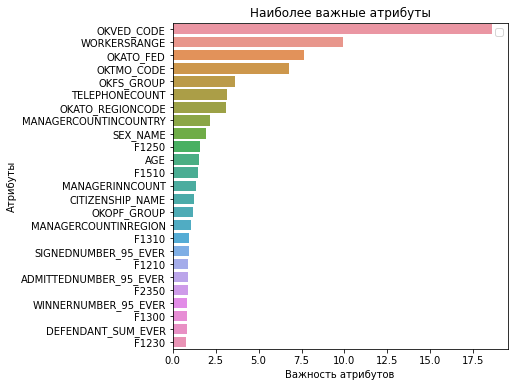

In [44]:
feature_importances(model_cb, X_train_cb)

## 4 Результаты

Формируем файл с результатами, используем модели lightgbm и catboost

In [45]:
res_cb = model_cb.predict_proba(test_data.drop(['id_contract', 'id_client', 'SIGN_DATE'], axis=1))[:, 1]
res_lgbm = model_lgbm.predict_proba(test_data_le.drop(['id_contract', 'id_client', 'SIGN_DATE'], axis=1))[:, 1]

In [46]:
df_cb = pd.DataFrame({'id_contract': test_data.id_contract.values, 'TARGET': res_cb})
df_lgbm = pd.DataFrame({'id_contract': test_data_le.id_contract.values, 'TARGET': res_lgbm})


df_cb.to_csv('../data/processed/res_cb.csv', sep=';', index=False)
df_lgbm.to_csv('../data/processed/res_lgbm.csv', sep=';', index=False)